In [2]:
import torch
print("ashish")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

ashish
cuda


In [8]:
# Add pruning code directory to system path
import sys
sys.path.append('../snip_snyflow_grasp_pruning')
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import init
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _pair
from Layers import layers



class Linear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__(in_features, out_features, bias)        
        self.register_buffer('weight_mask', torch.ones(self.weight.shape))
        if self.bias is not None:
            self.register_buffer('bias_mask', torch.ones(self.bias.shape))

    def forward(self, input):
        W = self.weight_mask * self.weight
        if self.bias is not None:
            b = self.bias_mask * self.bias
        else:
            b = self.bias
        return F.linear(input, W, b)


class Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        super(Conv2d, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, 
            dilation, groups, bias, padding_mode)
        self.register_buffer('weight_mask', torch.ones(self.weight.shape))
        if self.bias is not None:
            self.register_buffer('bias_mask', torch.ones(self.bias.shape))

    def _conv_forward(self, input, weight, bias):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input):
        W = self.weight_mask * self.weight
        if self.bias is not None:
            b = self.bias_mask * self.bias
        else:
            b = self.bias
        return self._conv_forward(input, W, b)


class BatchNorm1d(nn.BatchNorm1d):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True,
                 track_running_stats=True):
        super(BatchNorm1d, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)
        if self.affine:     
            self.register_buffer('weight_mask', torch.ones(self.weight.shape))
            self.register_buffer('bias_mask', torch.ones(self.bias.shape))

    def forward(self, input):
        self._check_input_dim(input)

        # exponential_average_factor is set to self.momentum
        # (when it is available) only so that if gets updated
        # in ONNX graph when this node is exported to ONNX.
        if self.momentum is None:
            exponential_average_factor = 0.0
        else:
            exponential_average_factor = self.momentum

        if self.training and self.track_running_stats:
            # TODO: if statement only here to tell the jit to skip emitting this when it is None
            if self.num_batches_tracked is not None:
                self.num_batches_tracked = self.num_batches_tracked + 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum
        if self.affine:
            W = self.weight_mask * self.weight
            b = self.bias_mask * self.bias
        else:
            W = self.weight
            b = self.bias

        return F.batch_norm(
            input, self.running_mean, self.running_var, W, b,
            self.training or not self.track_running_stats,
            exponential_average_factor, self.eps)


class BatchNorm2d(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True,
                 track_running_stats=True):
        super(BatchNorm2d, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)
        if self.affine:     
            self.register_buffer('weight_mask', torch.ones(self.weight.shape))
            self.register_buffer('bias_mask', torch.ones(self.bias.shape))

    def forward(self, input):
        self._check_input_dim(input)

        # exponential_average_factor is set to self.momentum
        # (when it is available) only so that if gets updated
        # in ONNX graph when this node is exported to ONNX.
        if self.momentum is None:
            exponential_average_factor = 0.0
        else:
            exponential_average_factor = self.momentum

        if self.training and self.track_running_stats:
            # TODO: if statement only here to tell the jit to skip emitting this when it is None
            if self.num_batches_tracked is not None:
                self.num_batches_tracked = self.num_batches_tracked + 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum
        if self.affine:
            W = self.weight_mask * self.weight
            b = self.bias_mask * self.bias
        else:
            W = self.weight
            b = self.bias

        return F.batch_norm(
            input, self.running_mean, self.running_var, W, b,
            self.training or not self.track_running_stats,
            exponential_average_factor, self.eps)


class Identity1d(nn.Module):
    def __init__(self, num_features):
        super(Identity1d, self).__init__()
        self.num_features = num_features
        self.weight = Parameter(torch.Tensor(num_features))
        self.register_buffer('weight_mask', torch.ones(self.weight.shape))
        self.reset_parameters()

    def reset_parameters(self):
        init.ones_(self.weight)

    def forward(self, input):
        W = self.weight_mask * self.weight
        return input * W


class Identity2d(nn.Module):
    def __init__(self, num_features):
        super(Identity2d, self).__init__()
        self.num_features = num_features
        self.weight = Parameter(torch.Tensor(num_features, 1, 1))
        self.register_buffer('weight_mask', torch.ones(self.weight.shape))
        self.reset_parameters()

    def reset_parameters(self):
        init.ones_(self.weight)

    def forward(self, input):
        W = self.weight_mask * self.weight
        return input * W





# VGG_MODEL

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class ConvModule(nn.Module):
    """A single convolutional module in a VGG network."""

    def __init__(self, in_filters, out_filters):
        super(ConvModule, self).__init__()
        self.conv = layers.Conv2d(in_filters, out_filters, kernel_size=3, padding=1)

    def forward(self, x):
        return F.relu(self.conv(x))

class ConvBNModule(nn.Module):
    """A single convolutional module in a VGG network."""

    def __init__(self, in_filters, out_filters):
        super(ConvBNModule, self).__init__()
        self.conv = layers.Conv2d(in_filters, out_filters, kernel_size=3, padding=1)
        self.bn = layers.BatchNorm2d(out_filters)

    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))

class VGG(nn.Module):
    """A VGG-style neural network designed for CIFAR-10."""

    def __init__(self, plan, conv, num_classes=10, dense_classifier=False):
        super(VGG, self).__init__()
        layer_list = []
        filters = 3

        for spec in plan:
            if spec == 'M':
                layer_list.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                layer_list.append(conv(filters, spec))
                filters = spec

        self.layers = nn.Sequential(*layer_list)        

        self.fc = layers.Linear(512, num_classes)
        if dense_classifier:
            self.fc = nn.Linear(512, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.layers(x)
        x = nn.AvgPool2d(2)(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (layers.Linear, nn.Linear, layers.Conv2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, layers.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

def _plan(num):
    if num == 11:
        plan = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512]
    elif num == 13:
        plan = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512]
    elif num == 16:
        plan = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512]
    elif num == 19:
        plan = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512]
    else:
        raise ValueError('Unknown VGG model: {}'.format(num))
    return plan

def _vgg(arch, plan, conv, num_classes, dense_classifier, pretrained):
    model = VGG(plan, conv, num_classes, dense_classifier)
    if pretrained:
        pretrained_path = 'Models/pretrained/{}-lottery.pt'.format(arch)
        pretrained_dict = torch.load(pretrained_path)
        model_dict = model.state_dict()
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
    return model

def vgg11(input_shape, num_classes, dense_classifier=False, pretrained=False):
    plan = _plan(11)
    return _vgg('vgg11_bn', plan, ConvModule, num_classes, dense_classifier, pretrained)

def vgg11_bn(input_shape, num_classes, dense_classifier=False, pretrained=False):
    plan = _plan(11)
    return _vgg('vgg11_bn', plan, ConvBNModule, num_classes, dense_classifier, pretrained)

def vgg13(input_shape, num_classes, dense_classifier=False, pretrained=False):
    plan = _plan(13)
    return _vgg('vgg13_bn', plan, ConvModule, num_classes, dense_classifier, pretrained)

def vgg13_bn(input_shape, num_classes, dense_classifier=False, pretrained=False):
    plan = _plan(13)
    return _vgg('vgg13_bn', plan, ConvBNModule, num_classes, dense_classifier, pretrained)

def vgg16(input_shape, num_classes, dense_classifier=False, pretrained=False):
    plan = _plan(16)
    return _vgg('vgg16_bn', plan, ConvModule, num_classes, dense_classifier, pretrained)

def vgg16_bn(input_shape, num_classes, dense_classifier=False, pretrained=False):
    plan = _plan(16)
    return _vgg('vgg16_bn', plan, ConvBNModule, num_classes, dense_classifier, pretrained)

def vgg19(input_shape, num_classes, dense_classifier=False, pretrained=False):
    plan = _plan(19)
    return _vgg('vgg19_bn', plan, ConvModule, num_classes, dense_classifier, pretrained)

def vgg19_bn(input_shape, num_classes, dense_classifier=False, pretrained=False):
    plan = _plan(19)
    return _vgg('vgg19_bn', plan, ConvBNModule, num_classes, dense_classifier, pretrained)


Files already downloaded and verified
Files already downloaded and verified


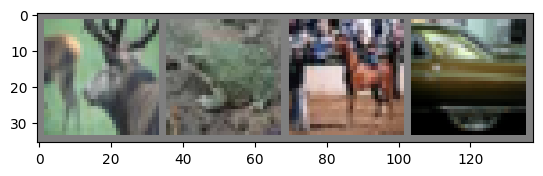

deer  frog  horse car  


In [10]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Download and transform CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../Data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../Data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [12]:
# Instantiate the VGG model
net = vgg19_bn((3, 32, 32), 10).to(device)

# Function to train the model
def train_model(net, trainloader, testloader, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(100 * correct / total)

        val_accuracy = test_model(net, testloader, return_accuracy=True)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.3f}, '
              f'Train Accuracy: {100 * correct / total:.2f}%, Val Accuracy: {val_accuracy:.2f}%')

    print('Finished Training')
    
    return train_losses, train_accuracies, val_accuracies

# Function to test the model
def test_model(net, testloader, return_accuracy=False):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if return_accuracy:
        return accuracy
    print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f}%')




# Let's Train the Model Without Compression

In [19]:
!python ../snip_snyflow_grasp_pruning/main.py \
  --dataset cifar10 \
  --model vgg16 \
  --pruner synflow \
  --compression 0.9 \
  --prune-bias True \
  --prune-batchnorm True \
  --prune-residual True \
  --reinitialize True \
  --gpu 0 \
  --expid vgg19_synflow_0.9C


Loading cifar10 dataset.
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Creating lottery-vgg16 model.
Pre-Train for 0 epochs.
0it [00:00, ?it/s]
Pruning with synflow for 1 epochs.
  0%|                                                     | 0/1 [00:00<?, ?it/s]0.12589254117941673
sparsity value
Epoch 1/1, Sparsity: 1853116.0/14719818 (0.1259)
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]
ashish
1853116.0 prunable parameters remaining, expected 1853115.2937185196
Post-Training for 10 epochs.
  0%|                                                    | 0/10 [00:00<?, ?it/s]Figure(1200x800)
New best model saved with accuracy: 31.73%
 10%|████▍                                       | 1/10 [00:14<02:13, 14.81s/it]Figure(1200x800)
New best model saved with accuracy: 48.60%
 20%|████████▊                                   | 2/10 [00:28<01:55, 14.40s/it]Figure(1200x800)
New best model saved with 

# Let's Train the Model with Compression Using SNIP algorithm

In [34]:
!python ../snip_snyflow_grasp_pruning/main.py \
  --dataset cifar10 \
  --model resnet110 \
  --pruner synflow \
  --compression 0.5 \
  --gpu 1 \
  --expid resnet32_0.9C 

Loading cifar10 dataset.
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Creating lottery-resnet110 model.
Pre-Train for 0 epochs.
0it [00:00, ?it/s]
Pruning with synflow for 1 epochs.
  0%|                                                     | 0/1 [00:00<?, ?it/s]0.31622776601683794
sparsity value
Epoch 1/1, Sparsity: 1722416.0/1722416 (1.0000)
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]
ashish
1722416.0 prunable parameters remaining, expected 544675.7638316579
ERROR: 1722416.0 prunable parameters remaining, expected 544675.7638316579
Post-Training for 10 epochs.
  0%|                                                    | 0/10 [00:11<?, ?it/s]
Traceback (most recent call last):
  File "../snip_snyflow_grasp_pruning/main.py", line 137, in <module>
    singleshot.run(args)
  File "/home/ashishr/my_project_github_check/snip_snyflow_grasp_pruning/Experiments/singleshot.py", line 50, in ru

In [20]:

# Load the saved model
pruned_model = vgg19_bn((3, 32, 32), 10).to(device)
pruned_model.load_state_dict(torch.load('/home/ashishr/my_project_github_check/Experiments_SNIP/vgg19_synflow-bn_0.9C/best_model.pth'))

# Test the network on the test data
test_model(pruned_model, testloader)

Accuracy of the network on the 10000 test images: 74.66%


In [161]:

# Load the saved model
original_model = vgg19_bn((3, 32, 32), 10).to(device)
original_model.load_state_dict(torch.load('Results/data/singleshot/vgg19-bn_0C/model.pt'))

# Test the network on the test data
test_model(original_model, testloader)

Accuracy of the network on the 10000 test images: 75.23%


In [87]:

# Load the saved model
net = vgg19_bn((3, 32, 32), 10).to(device)
net.load_state_dict(torch.load('Results/data/singleshot/vgg19-bn0.9C/model.pt'))

# Test the network on the test data
test_model(model, testloader)

Accuracy of the network on the 10000 test images: 77.18%


Accuracy of the network on the 10000 test images: 74.66%


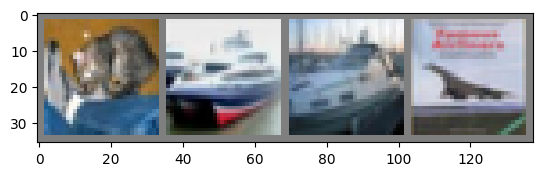

Predicted:  cat   ship  ship  ship 
GroundTruth:  cat   ship  ship  plane


In [21]:
# Load the saved model
net = vgg19_bn((3, 32, 32), 10).to(device)
net.load_state_dict(torch.load('/home/ashishr/my_project_github_check/Experiments_SNIP/vgg19_synflow-bn_0.9C/best_model.pth'))

# Test the network on the test data
test_model(net, testloader)

# Visualize some test images along with predicted and true labels
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Display images
imshow(torchvision.utils.make_grid(images.cpu()))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [15]:
import torch

def get_masks(module):
    """Returns an iterator over module masks, yielding the mask."""
    if hasattr(module, 'weight_mask'):
        yield module.weight_mask
    if hasattr(module, 'bias_mask'):
        yield module.bias_mask

def apply_masks(model):
    """Applies the mask to the parameters."""
    for module in model.modules():
        if hasattr(module, 'weight_mask'):
            module.weight.data.mul_(module.weight_mask)
        if hasattr(module, 'bias_mask'):
            module.bias.data.mul_(module.bias_mask)

def calculate_sparsity(model):
    sparsity_dict = {}
    total_params = 0
    sparse_params = 0
    
    for name, module in model.named_modules():
        module_total_params = 0
        module_sparse_params = 0
        has_param = False
        for pname, param in module.named_parameters(recurse=False):
            if param.requires_grad:
                param_total = param.numel()
                param_sparse = (param == 0).sum().item()
                
                module_total_params += param_total
                module_sparse_params += param_sparse
                total_params += param_total
                sparse_params += param_sparse
                has_param = True
                
        if has_param:  # Only include modules with parameters
            if module_total_params > 0:
                module_sparsity = module_sparse_params / module_total_params
            else:
                module_sparsity = 0
            sparsity_dict[name] = module_sparsity
    
    overall_sparsity = sparse_params / total_params
    return sparsity_dict, total_params, sparse_params, overall_sparsity

def print_sparsity(sparsity_dict, total_params, sparse_params, overall_sparsity):
    for module_name, sparsity in sparsity_dict.items():
        print(f"Module: {module_name}, Sparsity: {sparsity:.4f}")
    print(f"Total Trainable Parameters: {total_params}")
    print(f"Sparse Parameters: {sparse_params}")
    print(f"Overall Sparsity: {overall_sparsity:.4f}")
    print(f"Percentage of Pruned Parameters: {overall_sparsity * 100:.2f}%")


# Apply Mask to the weights

In [16]:
apply_masks(pruned_model)

In [17]:
# Calculate and print the sparsity
sparsity_dict, total_params, sparse_params, overall_sparsity = calculate_sparsity(pruned_model)
print_sparsity(sparsity_dict, total_params, sparse_params, overall_sparsity)

Module: layers.0.conv, Sparsity: 0.0363
Module: layers.0.bn, Sparsity: 0.5000
Module: layers.1.conv, Sparsity: 0.0311
Module: layers.1.bn, Sparsity: 0.5000
Module: layers.3.conv, Sparsity: 0.0597
Module: layers.3.bn, Sparsity: 0.5000
Module: layers.4.conv, Sparsity: 0.1124
Module: layers.4.bn, Sparsity: 0.5000
Module: layers.6.conv, Sparsity: 0.2229
Module: layers.6.bn, Sparsity: 0.5000
Module: layers.7.conv, Sparsity: 0.4287
Module: layers.7.bn, Sparsity: 0.5000
Module: layers.8.conv, Sparsity: 0.4279
Module: layers.8.bn, Sparsity: 0.5000
Module: layers.9.conv, Sparsity: 0.4285
Module: layers.9.bn, Sparsity: 0.5000
Module: layers.11.conv, Sparsity: 0.7442
Module: layers.11.bn, Sparsity: 0.5000
Module: layers.12.conv, Sparsity: 0.9715
Module: layers.12.bn, Sparsity: 0.5000
Module: layers.13.conv, Sparsity: 0.9716
Module: layers.13.bn, Sparsity: 0.5000
Module: layers.14.conv, Sparsity: 0.9714
Module: layers.14.bn, Sparsity: 0.5000
Module: layers.16.conv, Sparsity: 0.9449
Module: layers.

# 1. Weight Distribution Histograms

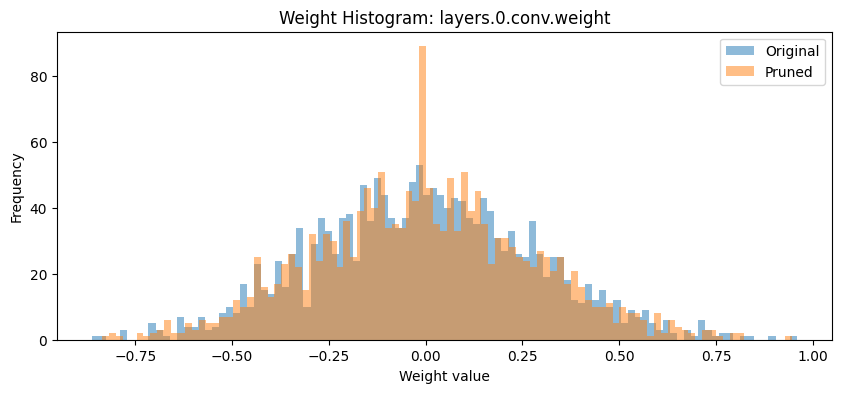

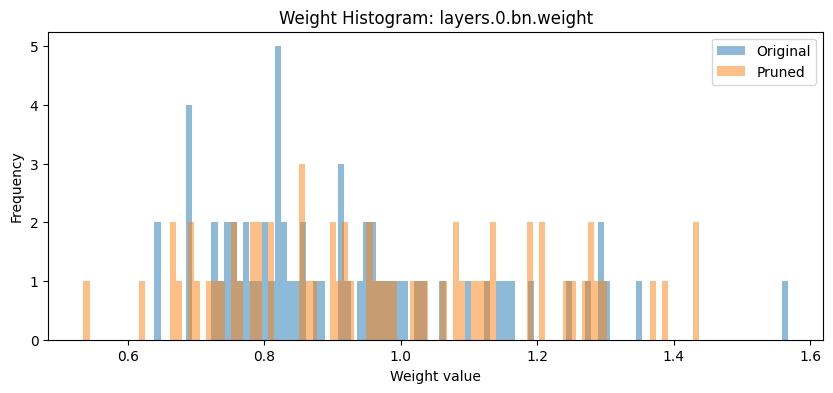

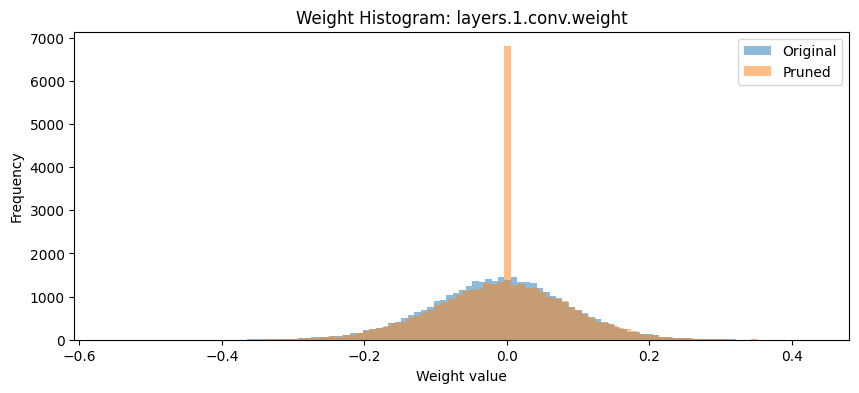

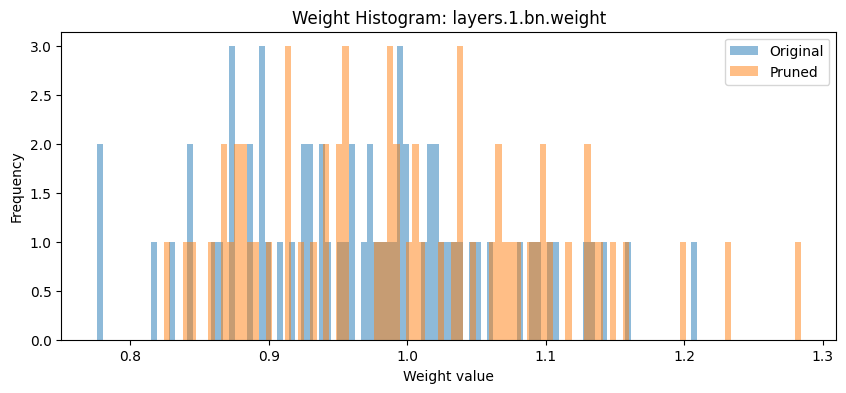

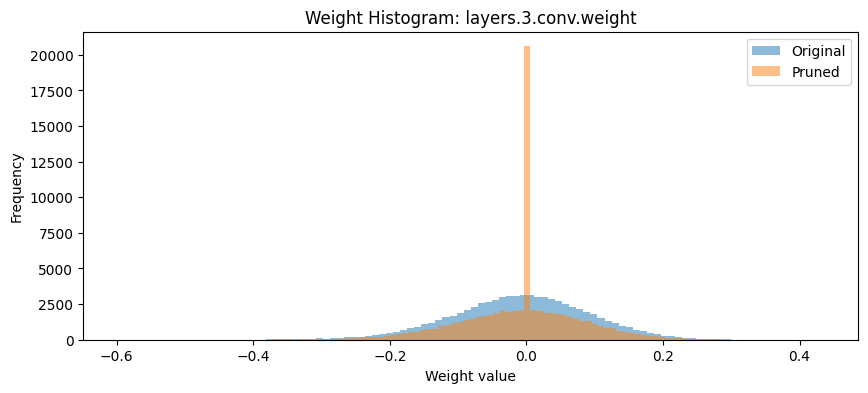

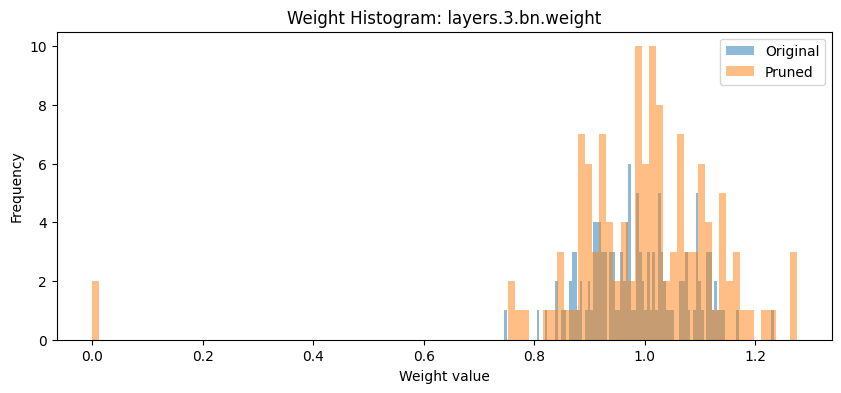

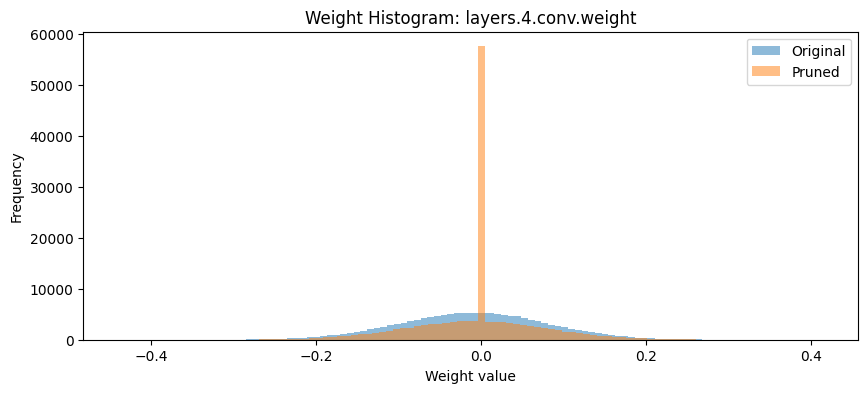

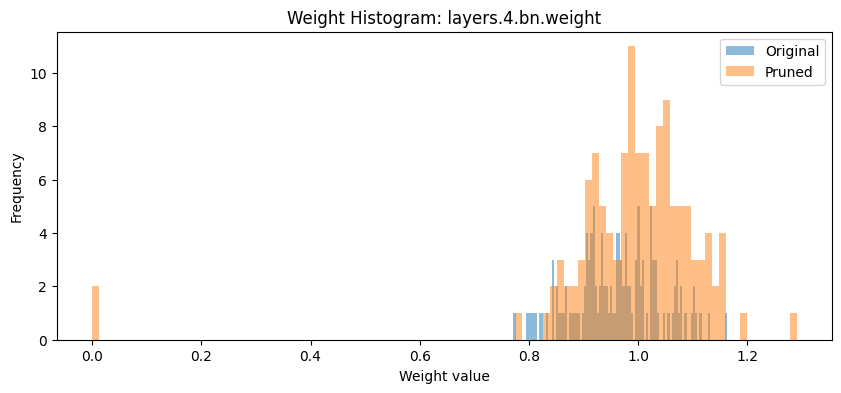

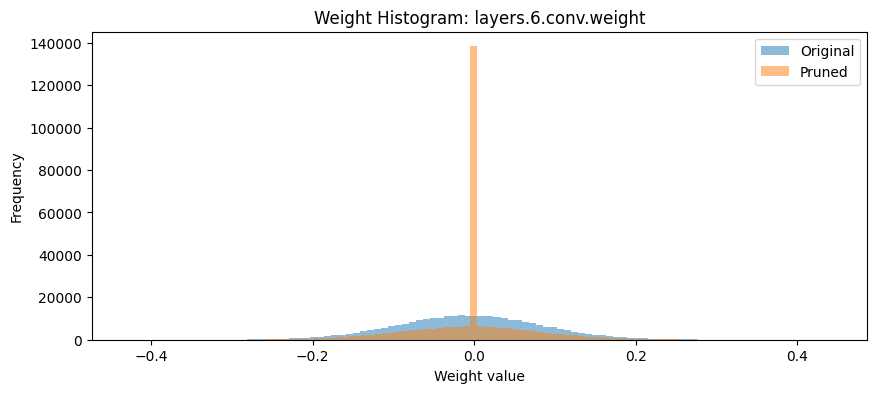

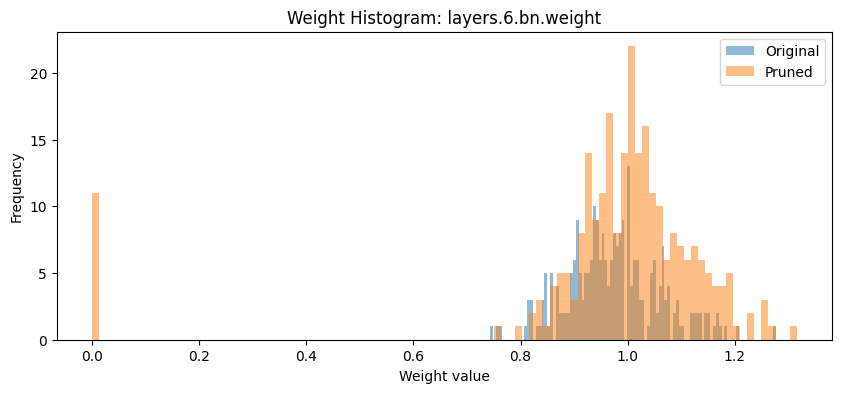

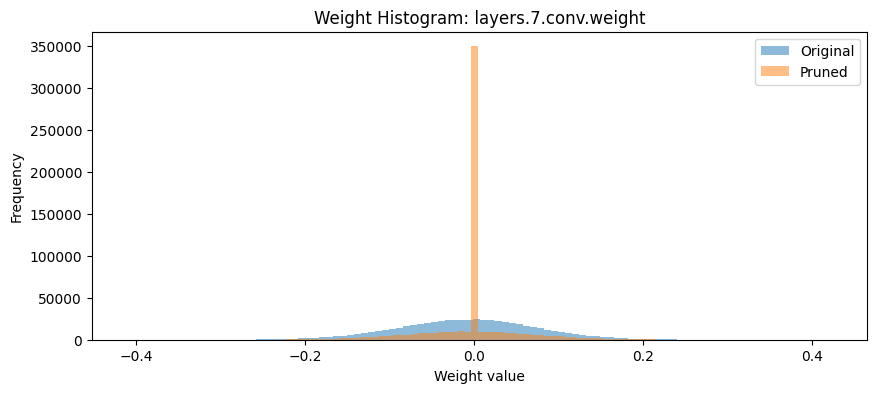

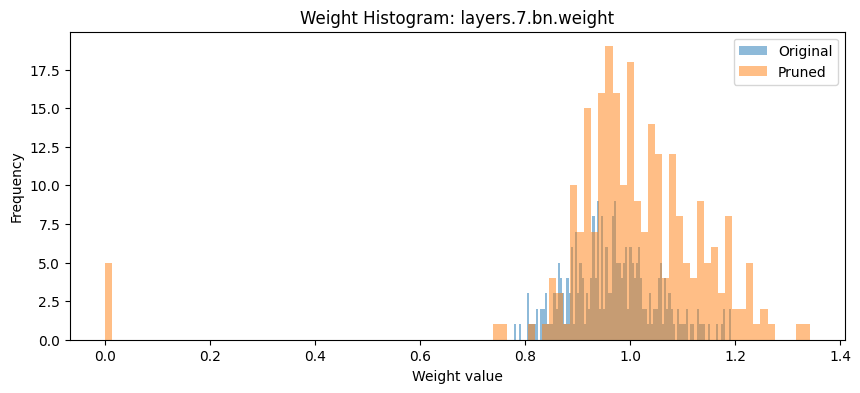

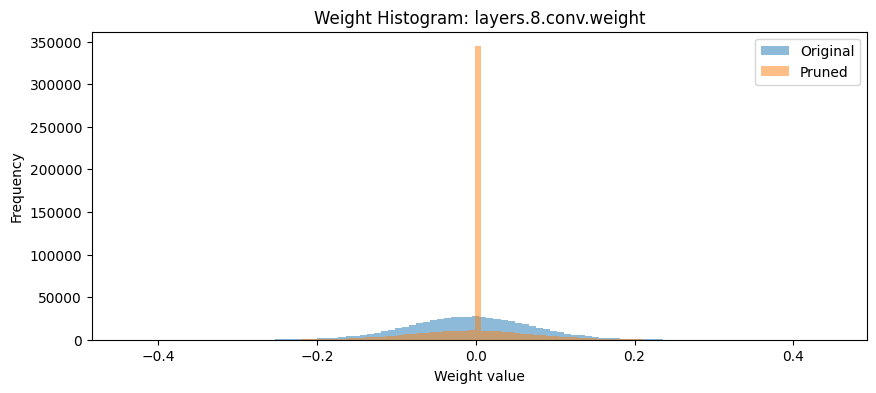

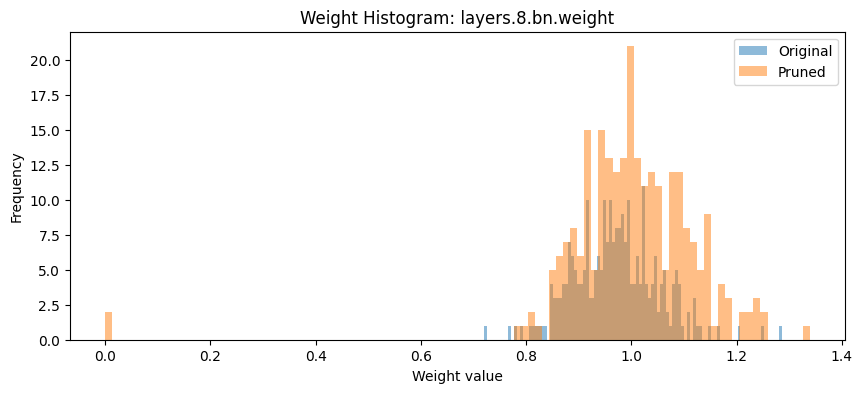

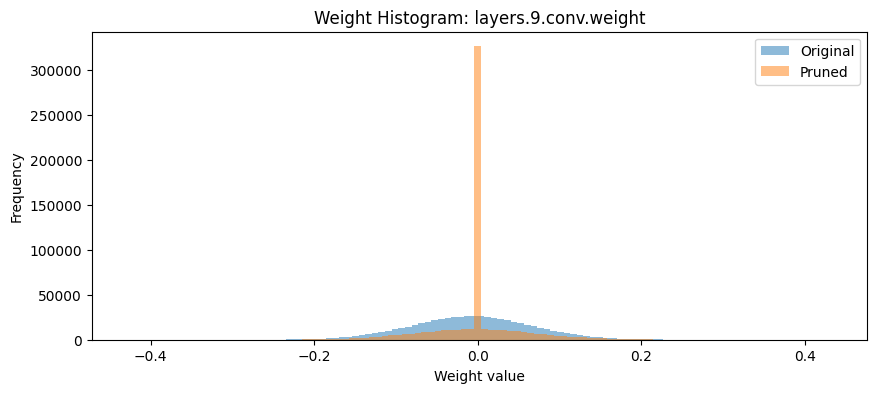

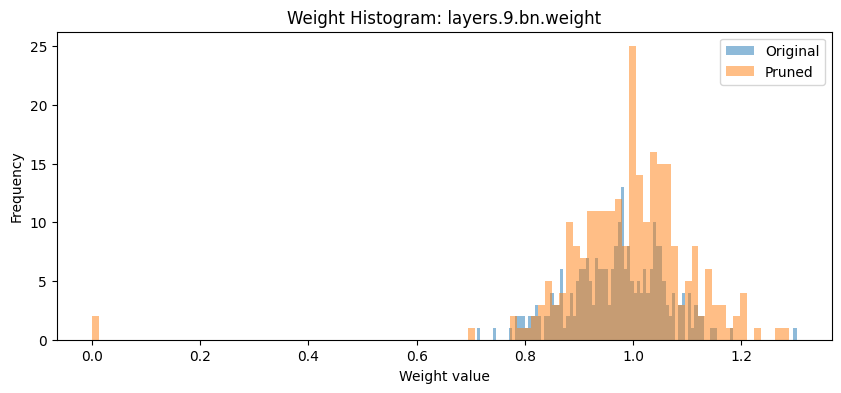

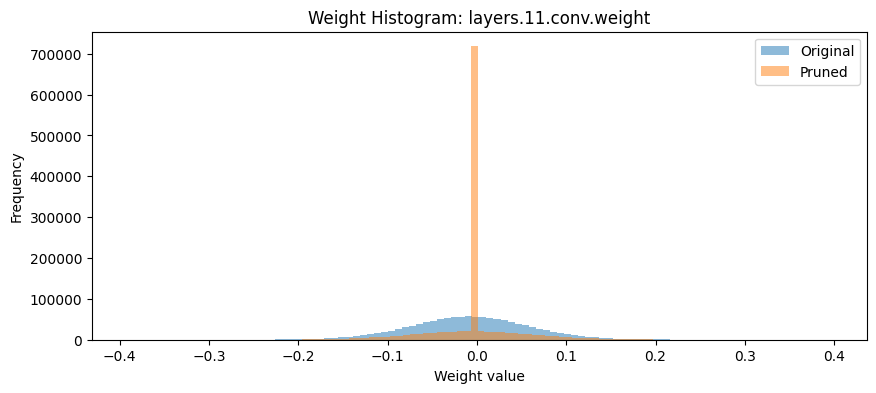

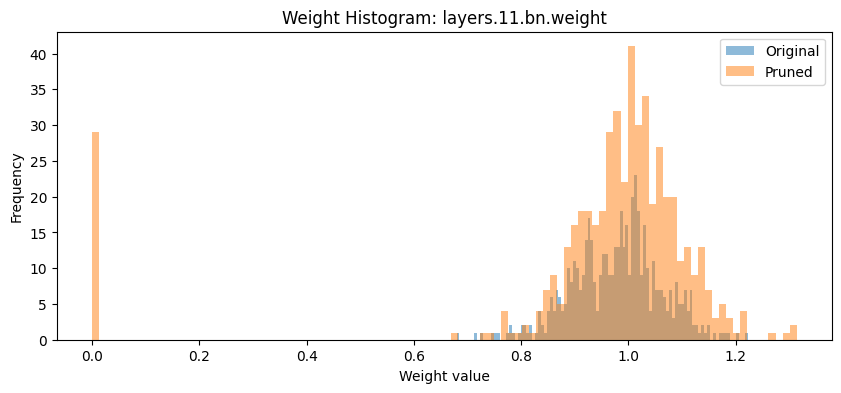

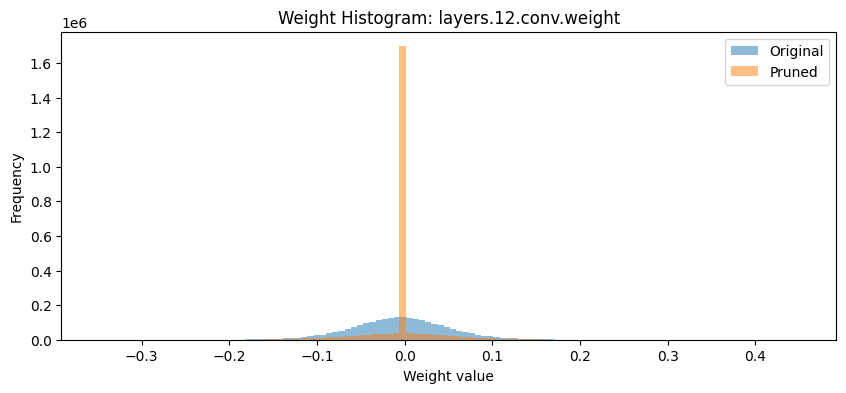

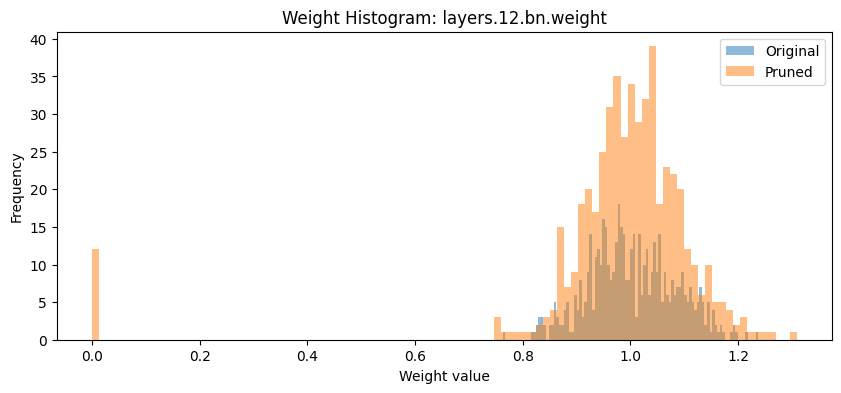

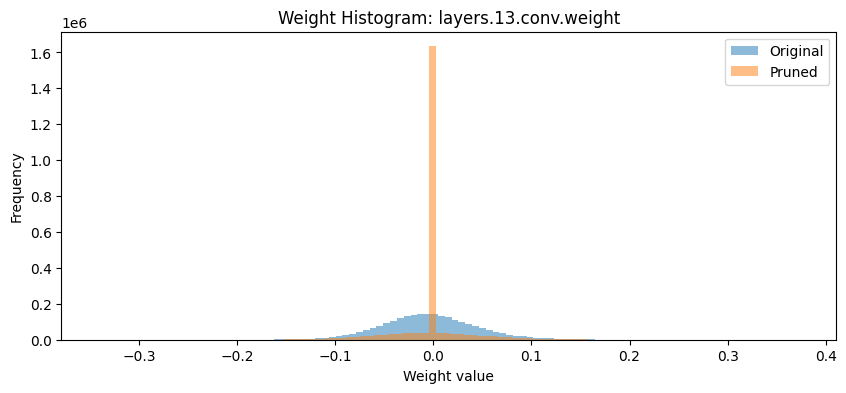

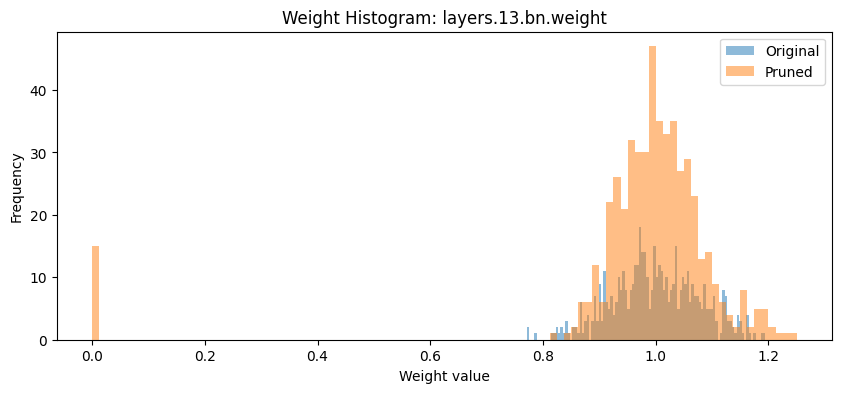

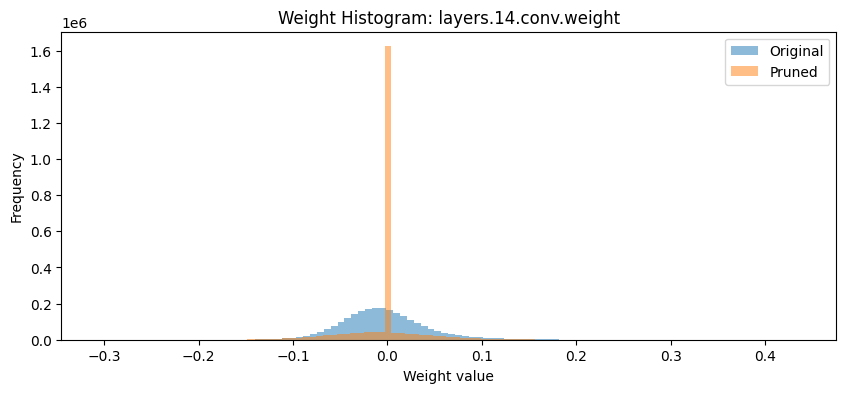

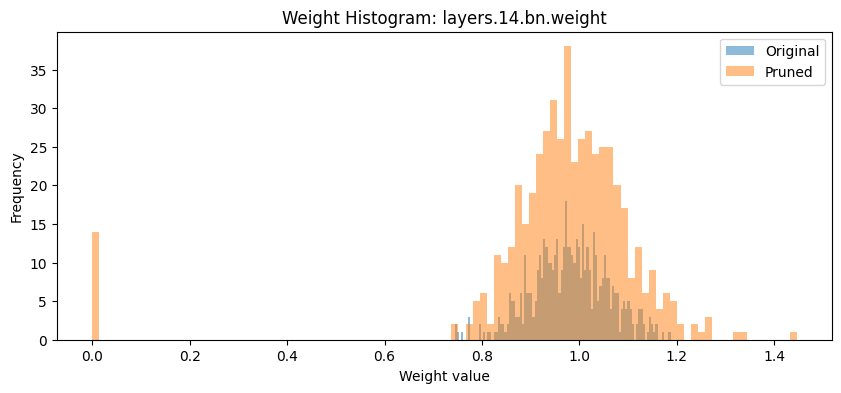

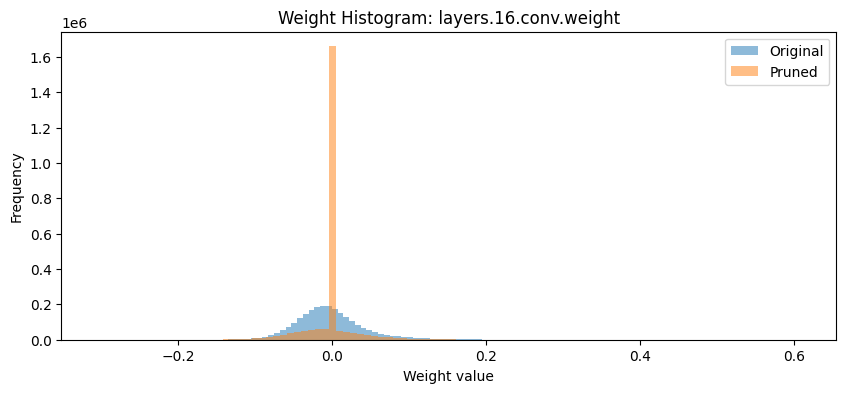

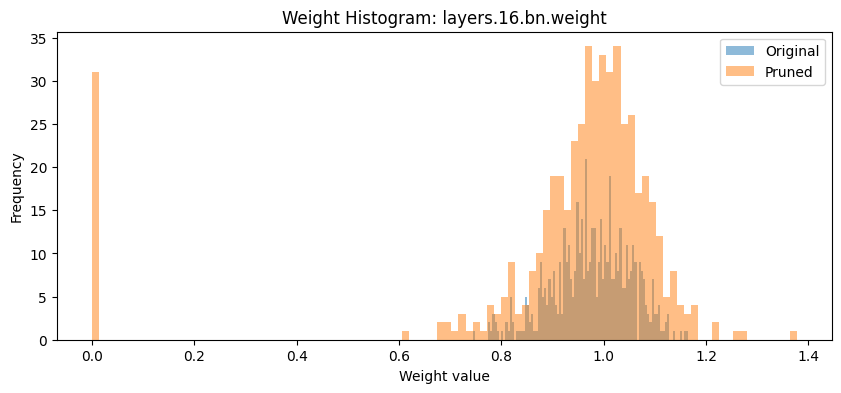

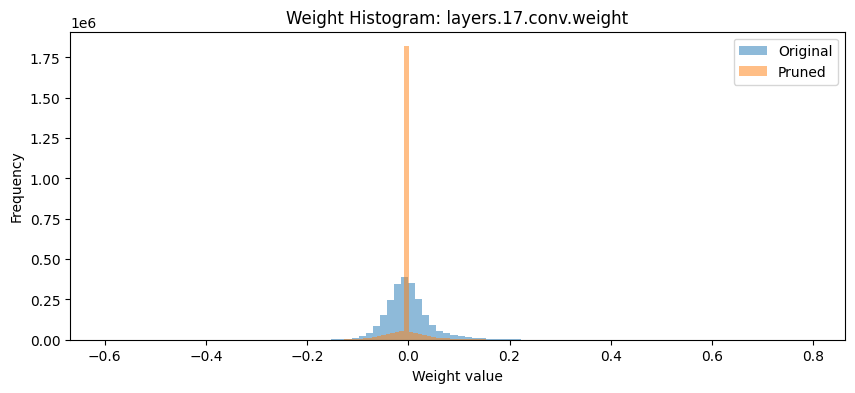

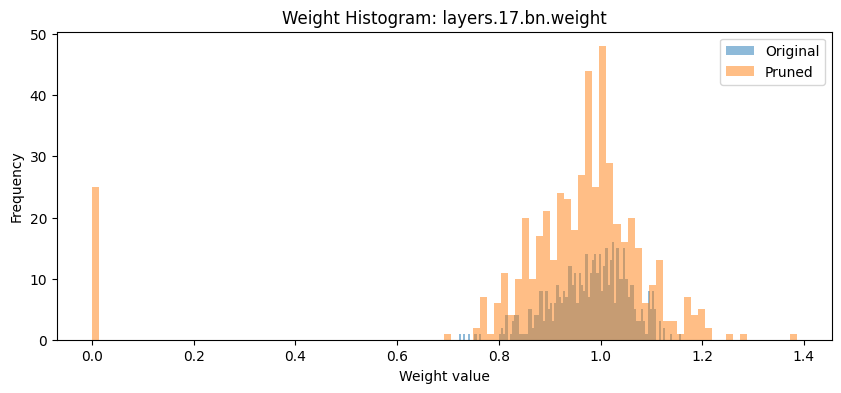

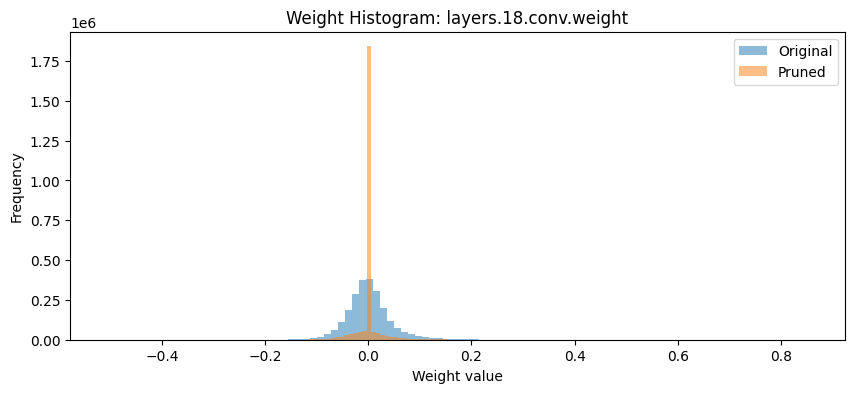

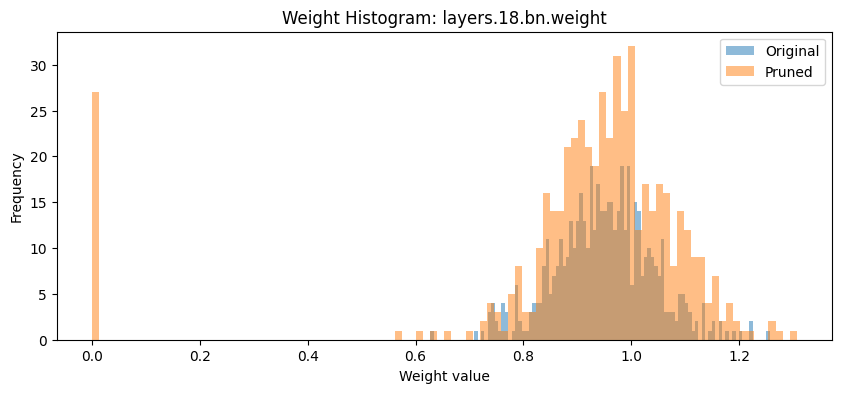

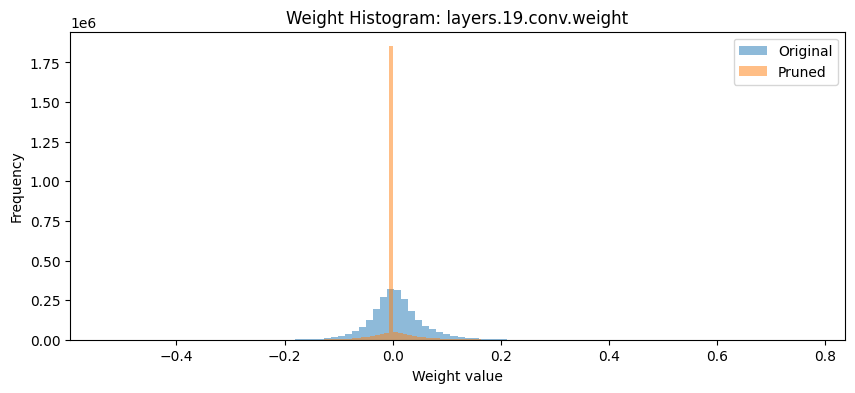

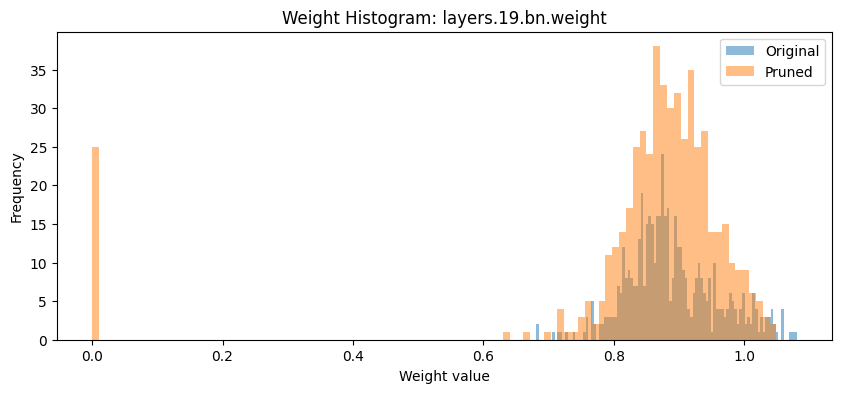

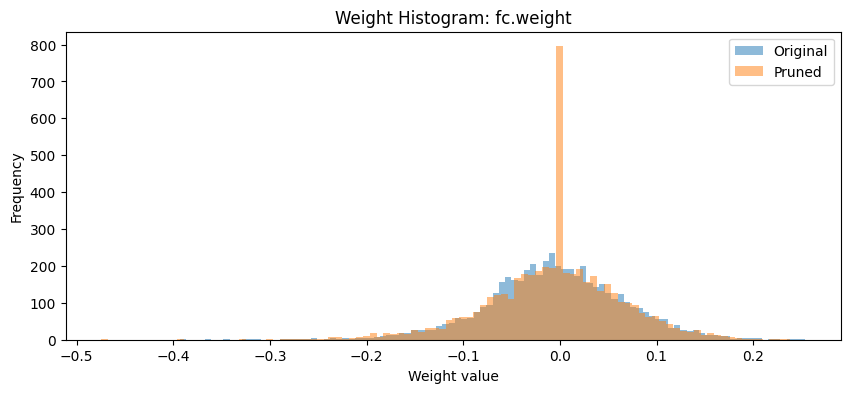

In [184]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


# Function to plot weight histograms before and after pruning
def plot_weight_histograms(original_model, pruned_model):
    for (name1, param1), (name2, param2) in zip(original_model.named_parameters(), pruned_model.named_parameters()):
        if 'weight' in name1 and 'weight' in name2:
            plt.figure(figsize=(10, 4))
            plt.hist(param1.cpu().detach().numpy().flatten(), bins=100, alpha=0.5, label='Original')
            plt.hist(param2.cpu().detach().numpy().flatten(), bins=100, alpha=0.5, label='Pruned')
            plt.title(f'Weight Histogram: {name1}')
            plt.xlabel('Weight value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.show()

# Plot weight histograms for both models
plot_weight_histograms(original_model, pruned_model)

# Average Sparsity by Layer Type

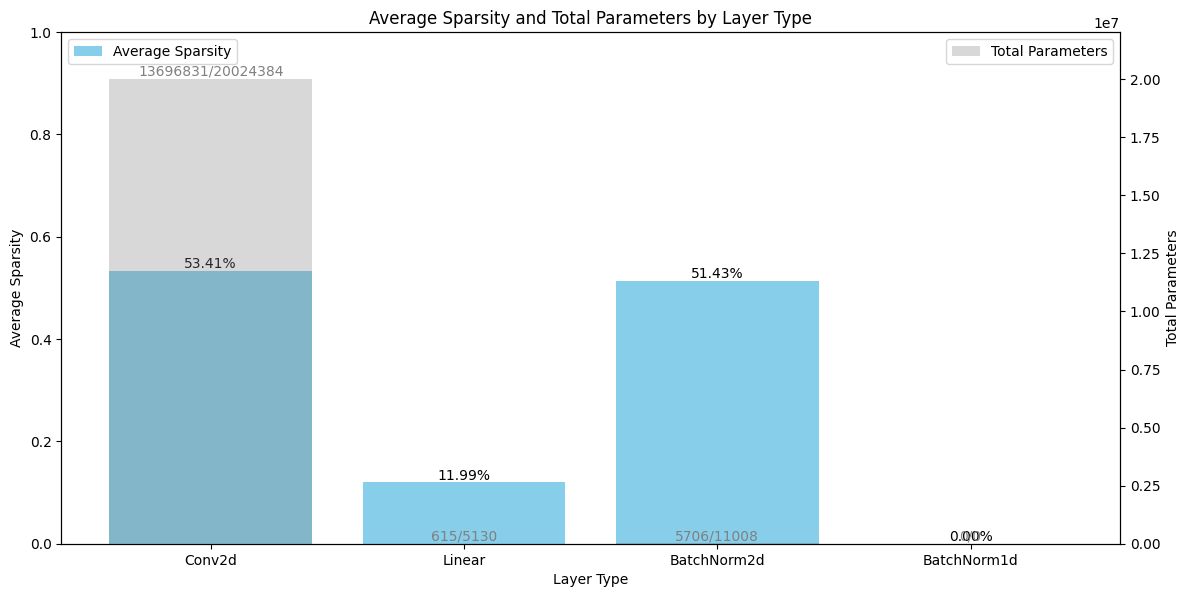

In [182]:


# Define a function to calculate the sparsity
def calculate_sparsity(model):
    sparsity_dict = {}
    total_params = 0
    sparse_params = 0
    
    for name, module in model.named_modules():
        module_total_params = 0
        module_sparse_params = 0
        has_param = False
        for pname, param in module.named_parameters(recurse=False):
            if param.requires_grad:
                param_total = param.numel()
                param_sparse = (param == 0).sum().item()
                
                module_total_params += param_total
                module_sparse_params += param_sparse
                total_params += param_total
                sparse_params += param_sparse
                has_param = True
                
        if has_param:  # Only include modules with parameters
            if module_total_params > 0:
                module_sparsity = module_sparse_params / module_total_params
            else:
                module_sparsity = 0
            sparsity_dict[name] = (module_sparsity, module_total_params, module_sparse_params)
    
    overall_sparsity = sparse_params / total_params
    return sparsity_dict, total_params, sparse_params, overall_sparsity

# Define a function to aggregate sparsity by layer type
def aggregate_sparsity(sparsity_dict, model):
    layer_sparsity = {
        'Conv2d': [],
        'Linear': [],
        'BatchNorm2d': [],
        'BatchNorm1d': []
    }
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            layer_sparsity['Conv2d'].append(sparsity_dict[name])
        elif isinstance(module, nn.Linear):
            layer_sparsity['Linear'].append(sparsity_dict[name])
        elif isinstance(module, nn.BatchNorm2d):
            layer_sparsity['BatchNorm2d'].append(sparsity_dict[name])
        elif isinstance(module, nn.BatchNorm1d):
            layer_sparsity['BatchNorm1d'].append(sparsity_dict[name])
    
    # Average sparsity for each layer type
    aggregated_sparsity = {}
    for layer, sparsities in layer_sparsity.items():
        if sparsities:
            avg_sparsity = np.mean([s[0] for s in sparsities])
            total_params = sum([s[1] for s in sparsities])
            sparse_params = sum([s[2] for s in sparsities])
            aggregated_sparsity[layer] = (avg_sparsity, total_params, sparse_params)
        else:
            aggregated_sparsity[layer] = (0.0, 0, 0)
    
    return aggregated_sparsity

# Define a function to plot the aggregated sparsity
def plot_aggregated_sparsity(aggregated_sparsity):
    layer_types = list(aggregated_sparsity.keys())
    sparsity_values = [s[0] for s in aggregated_sparsity.values()]
    total_params = [s[1] for s in aggregated_sparsity.values()]
    sparse_params = [s[2] for s in aggregated_sparsity.values()]
    sparse_percentages = [sparsity * 100 for sparsity in sparsity_values]
    
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax2 = ax1.twinx()
    ax1.bar(layer_types, sparsity_values, color='skyblue', label='Average Sparsity')
    ax2.bar(layer_types, total_params, alpha=0.3, color='gray', label='Total Parameters')
    
    ax1.set_xlabel('Layer Type')
    ax1.set_ylabel('Average Sparsity')
    ax2.set_ylabel('Total Parameters')

    for i, (sparsity, total, sparse, percent) in enumerate(zip(sparsity_values, total_params, sparse_params, sparse_percentages)):
        ax1.text(i, sparsity, f'{percent:.2f}%', ha='center', va='bottom')
        ax2.text(i, total, f'{sparse}/{total}', ha='center', va='bottom', color='gray')

    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, max(total_params) * 1.1)

    fig.tight_layout()
    plt.title('Average Sparsity and Total Parameters by Layer Type')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

# Calculate and plot sparsity
sparsity_dict, total_params, sparse_params, overall_sparsity = calculate_sparsity(pruned_model)
aggregated_sparsity = aggregate_sparsity(sparsity_dict, model)
plot_aggregated_sparsity(aggregated_sparsity)


# Shift in Distribution:

A noticeable shift in the distribution towards zero indicates effective pruning, where less important weights have been zeroed out.
This shift reflects a model that is more focused on significant features and has reduced computational overhead.

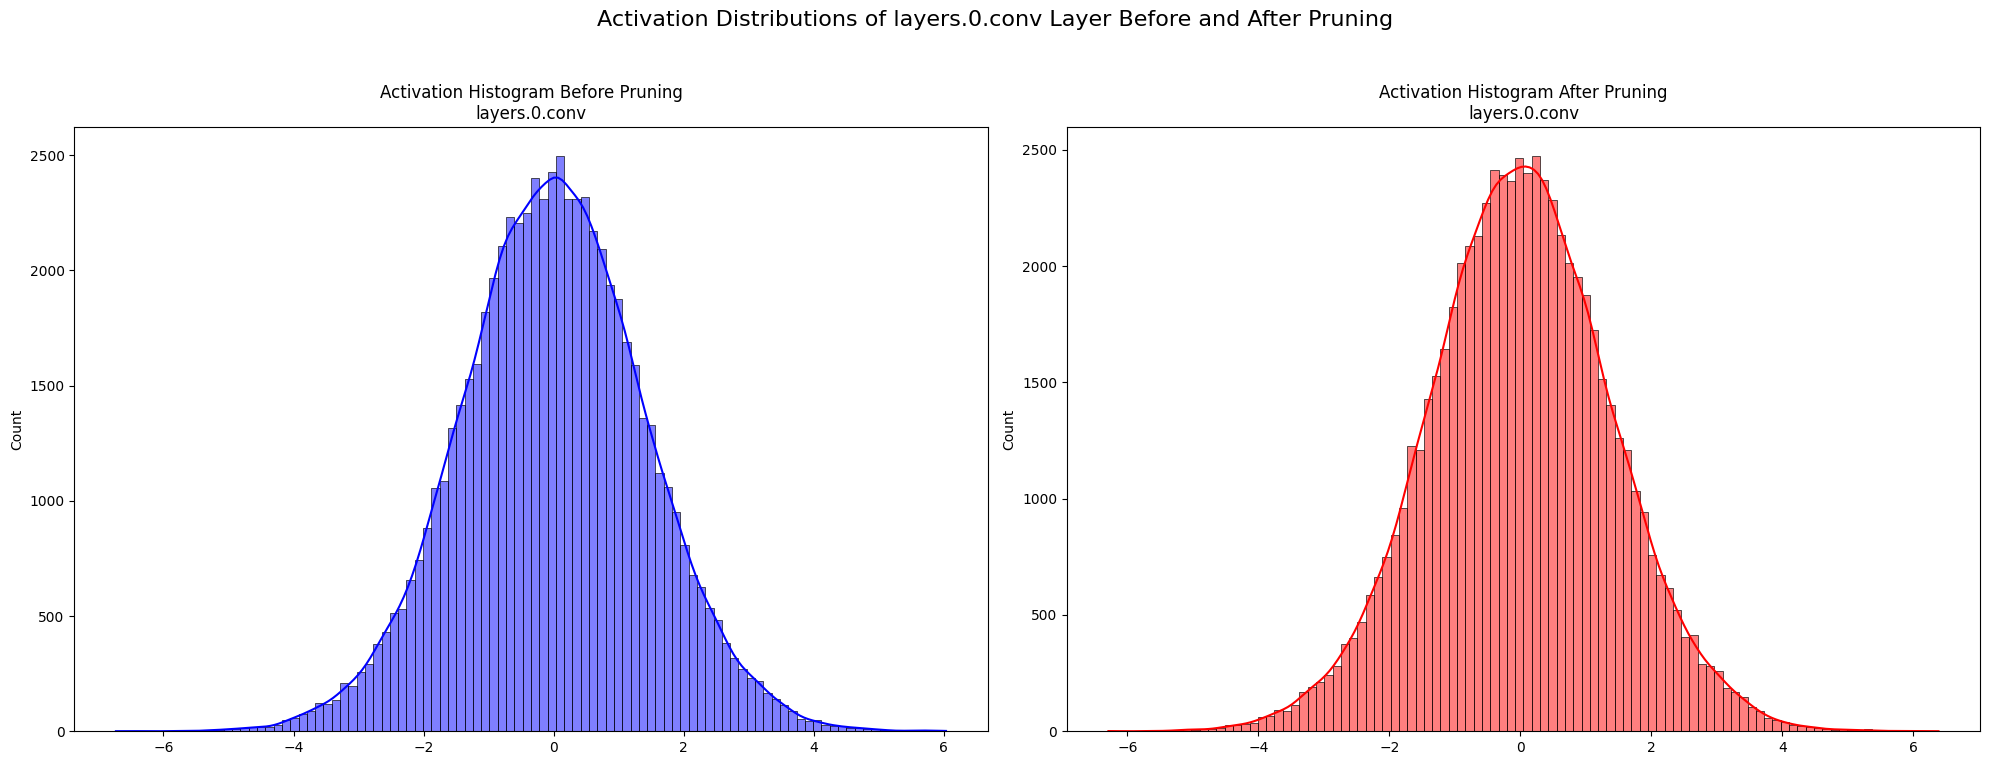

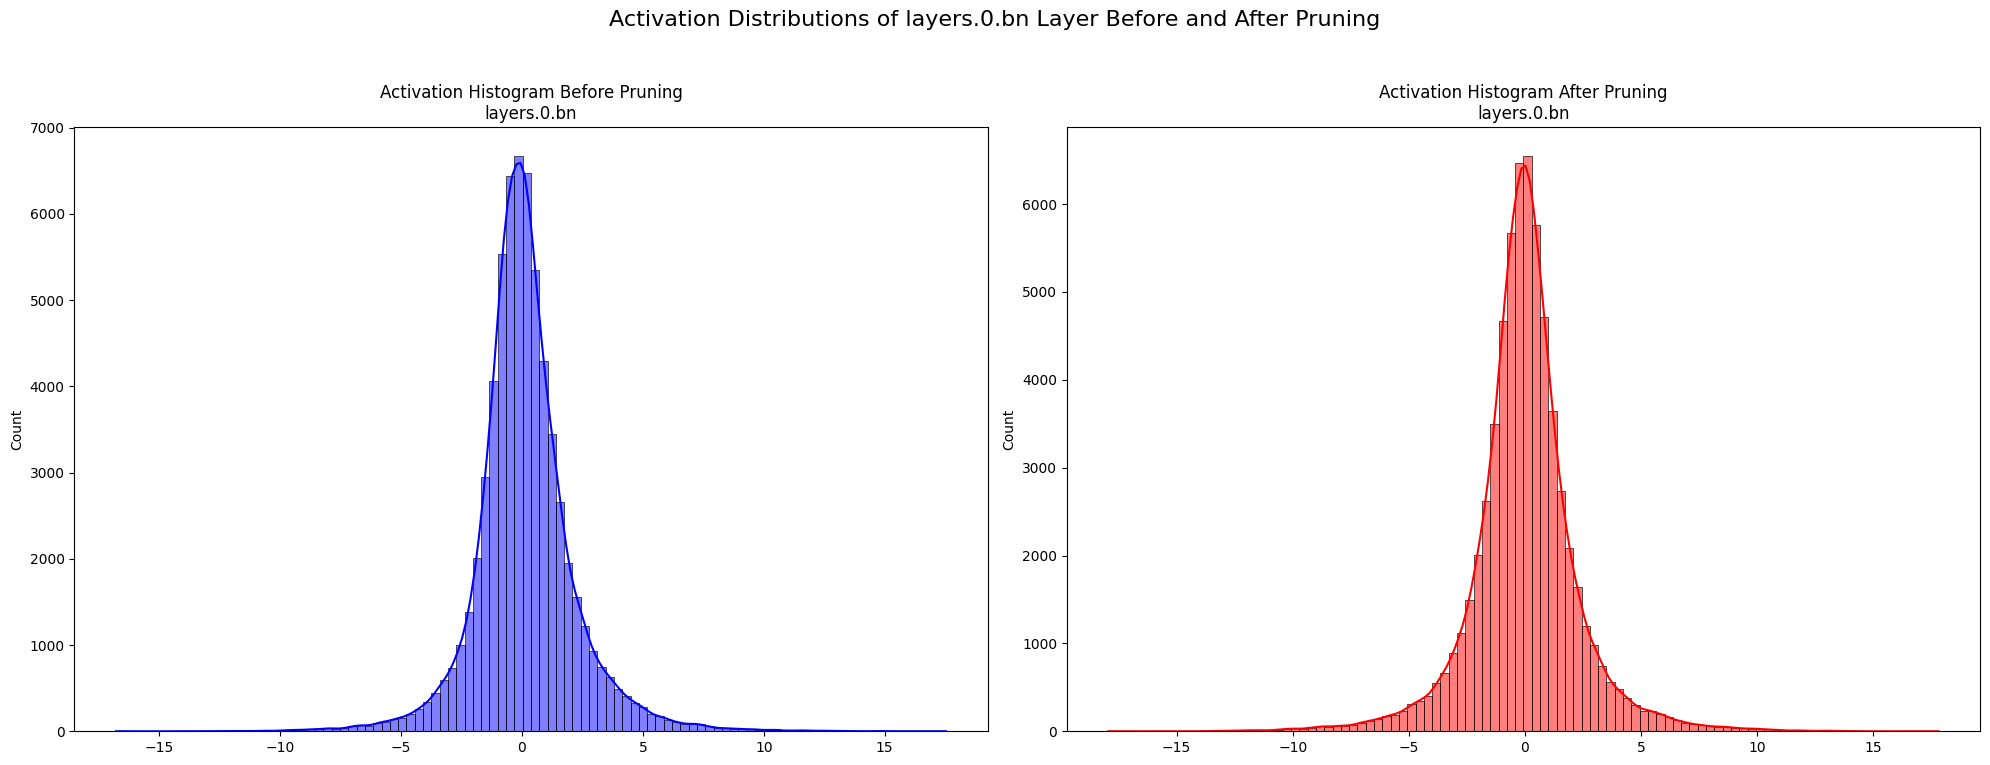

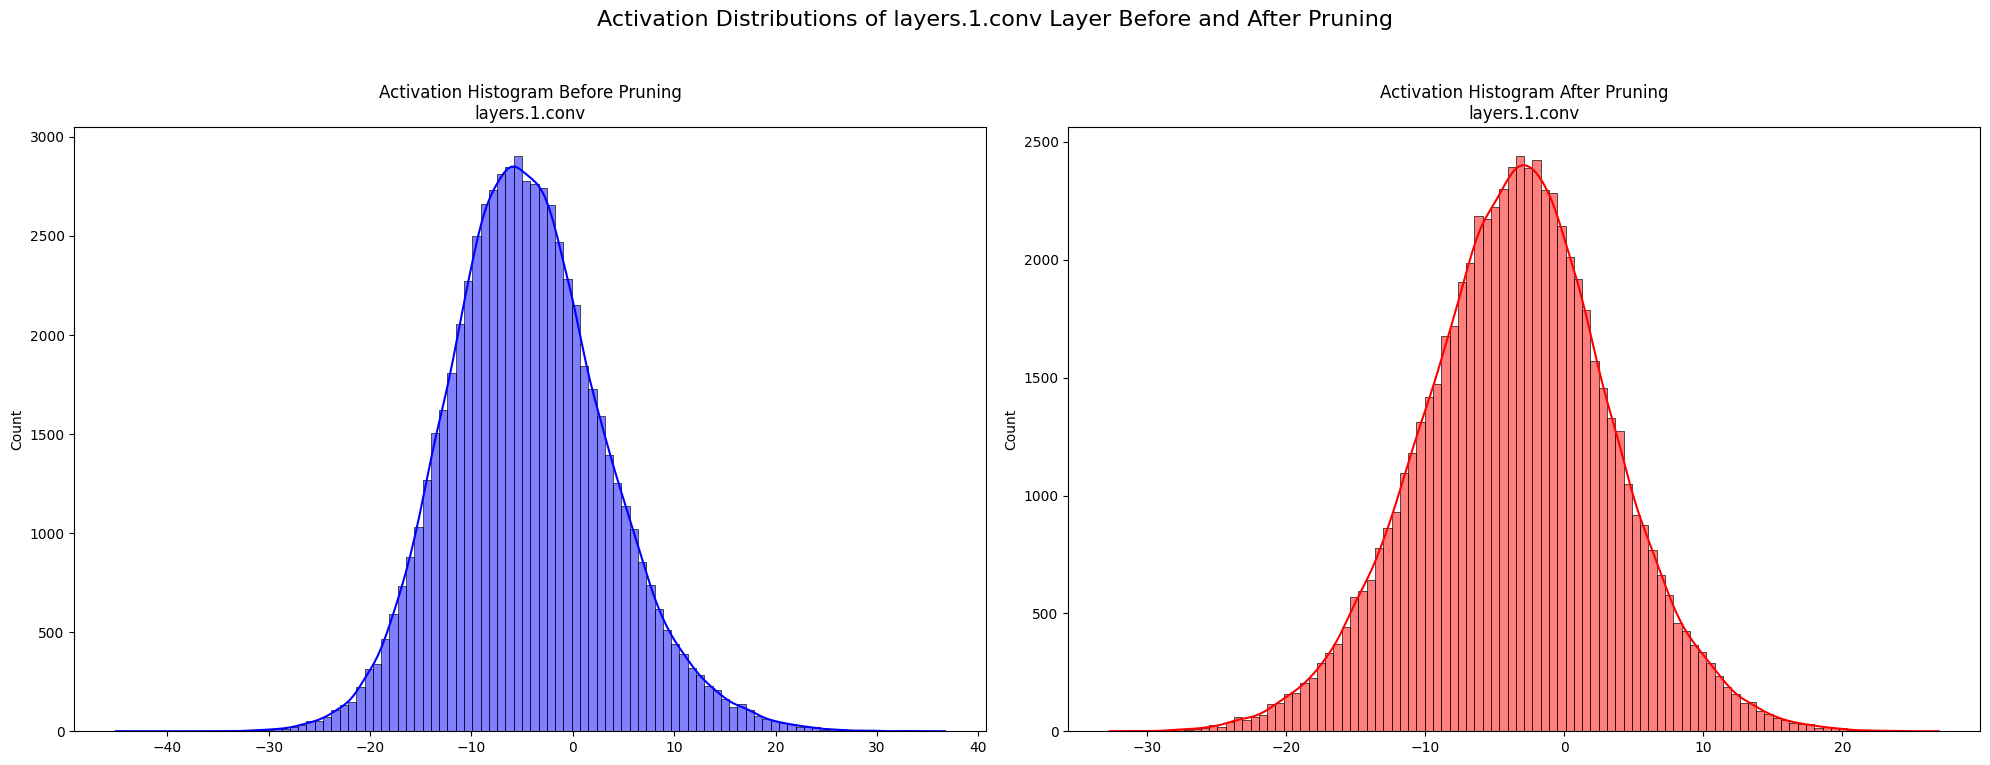

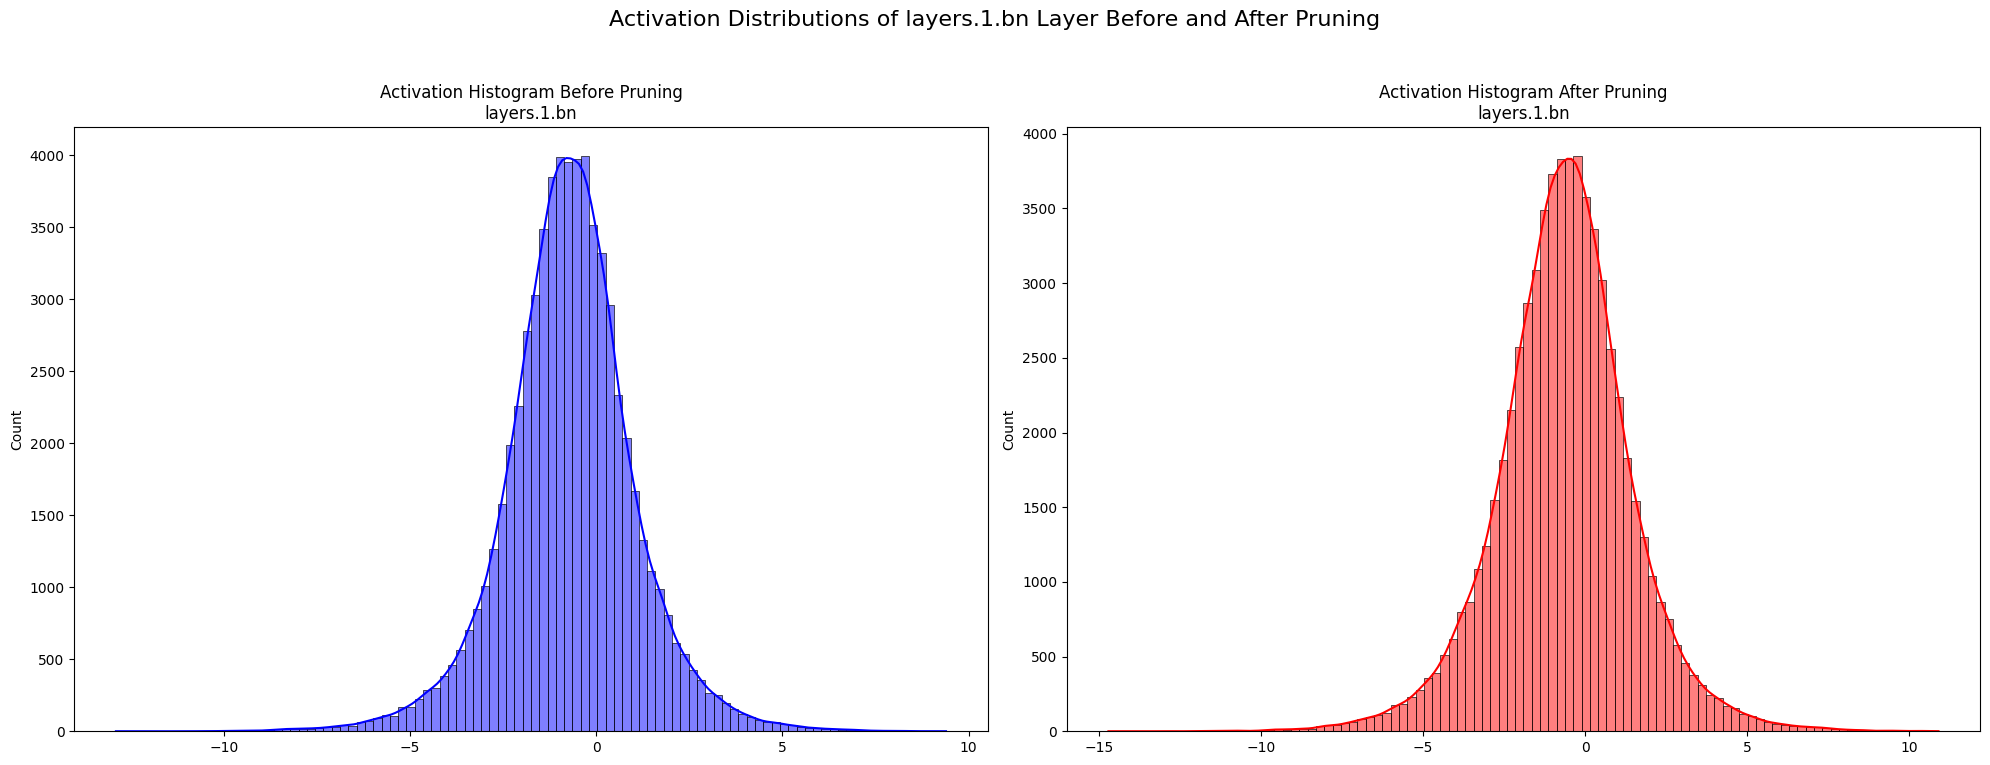

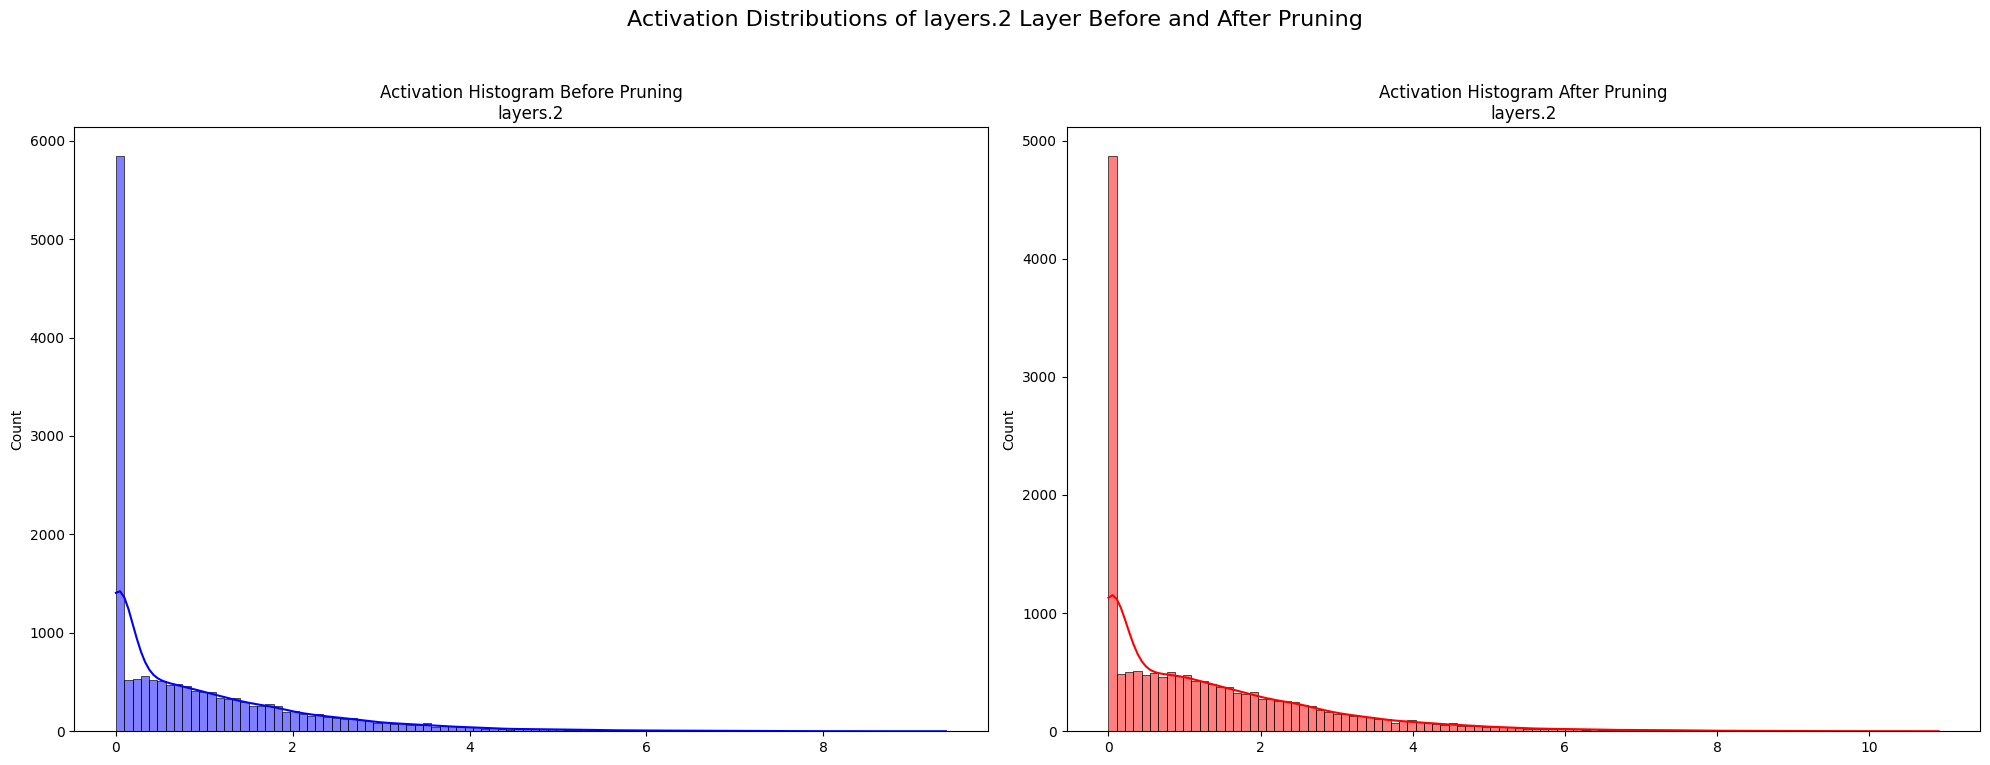

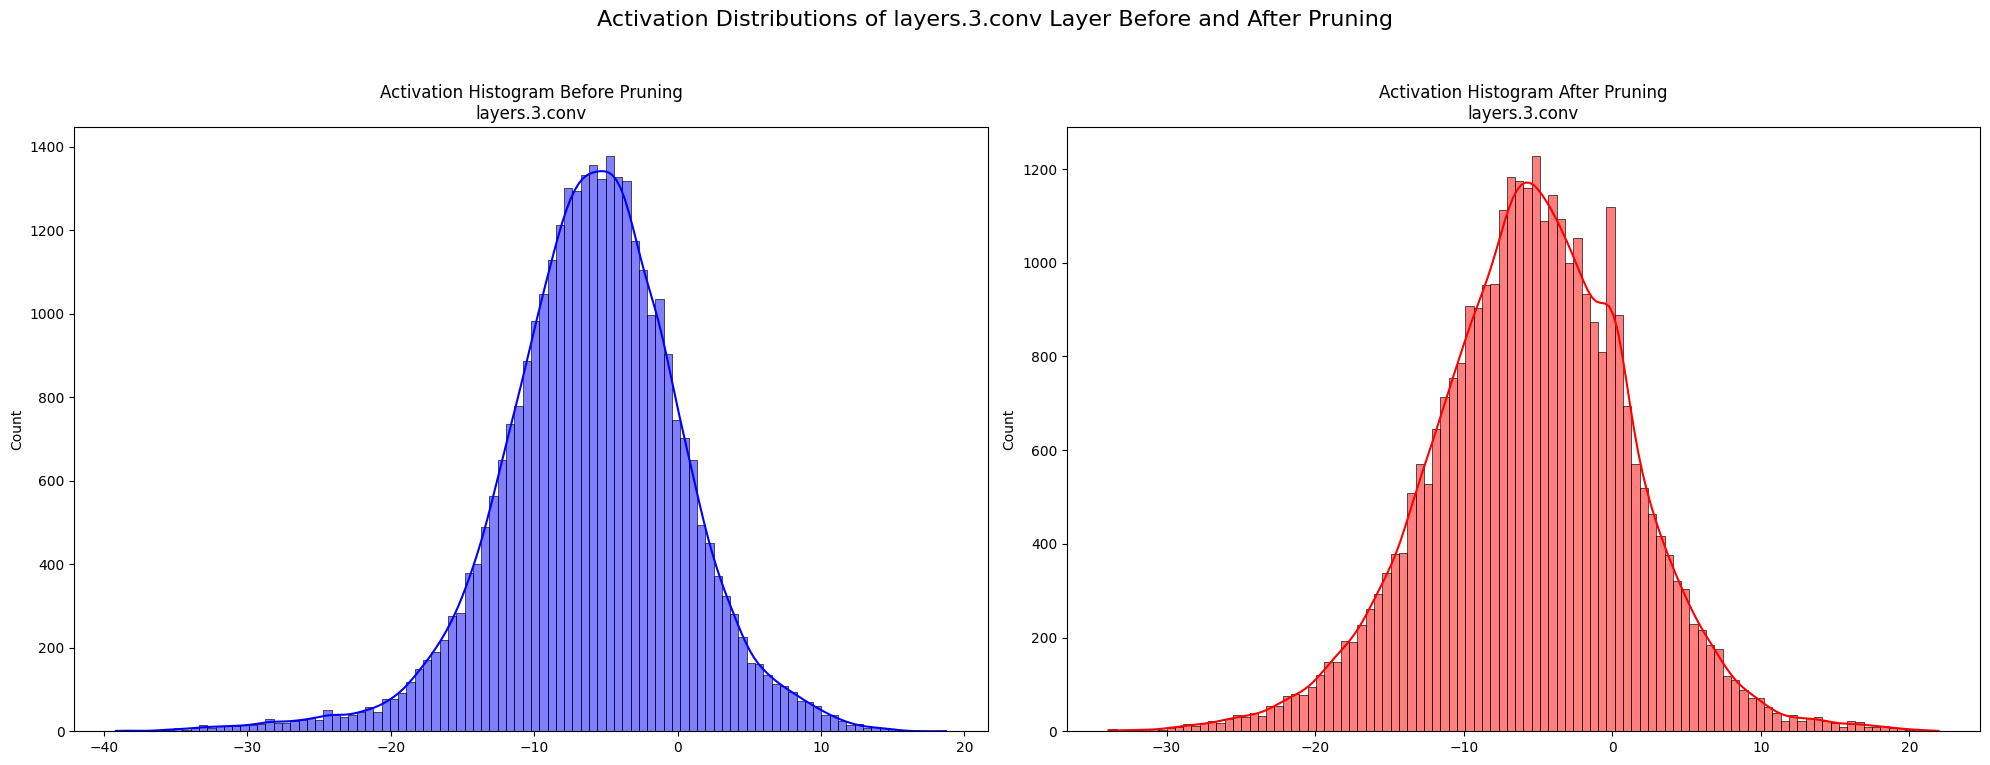

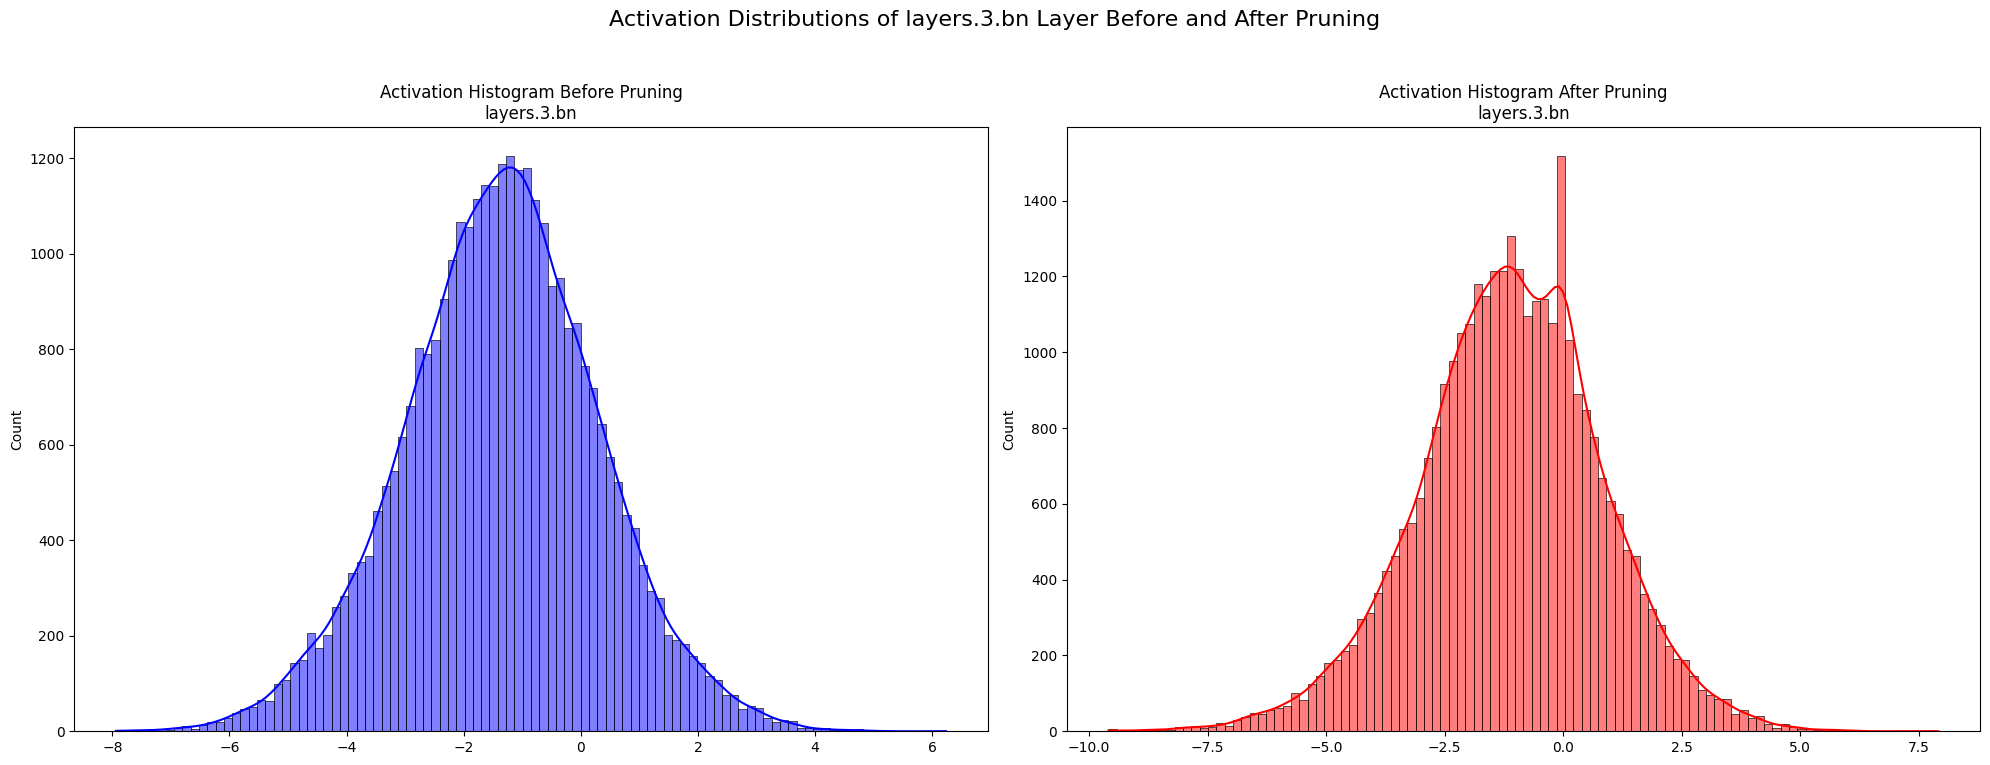

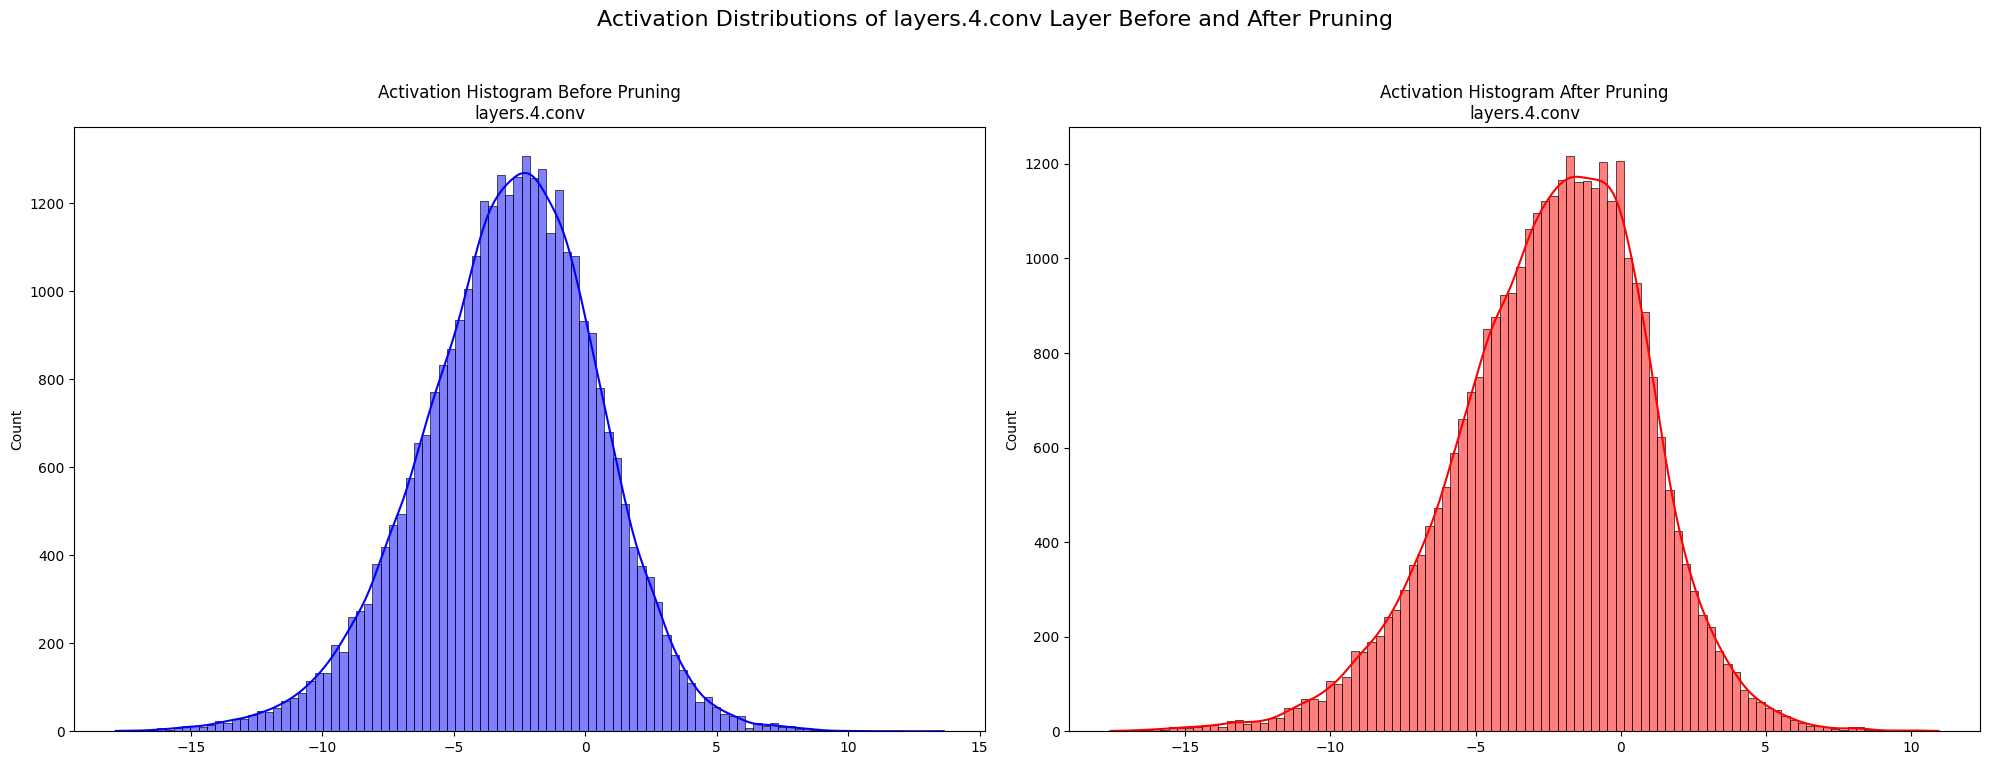

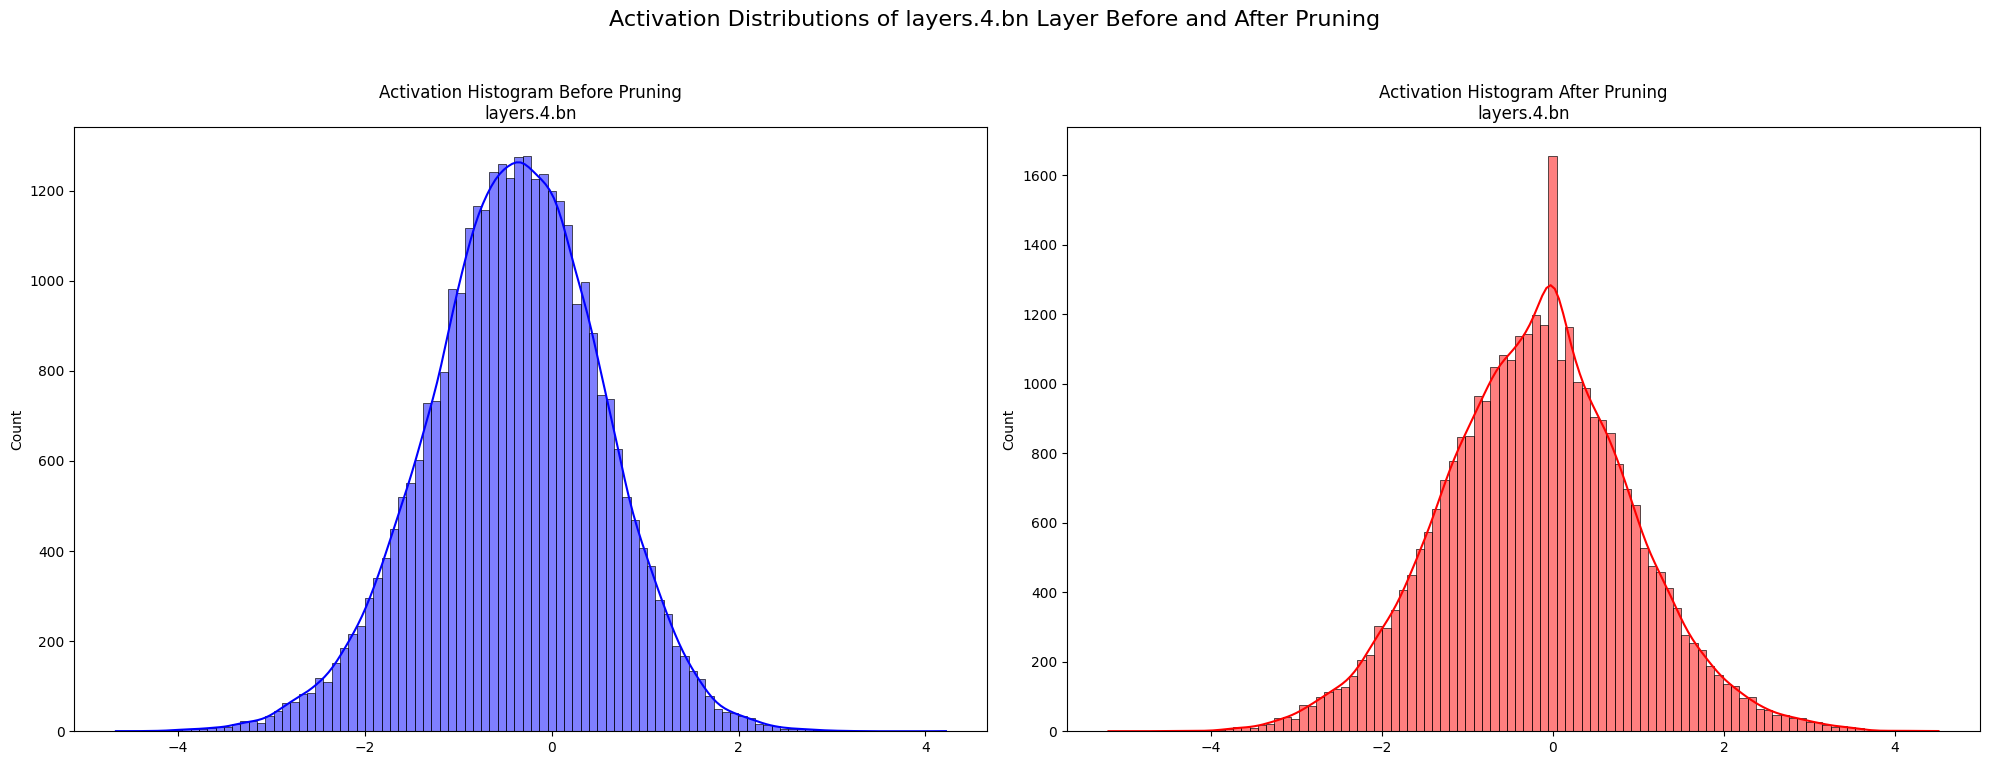

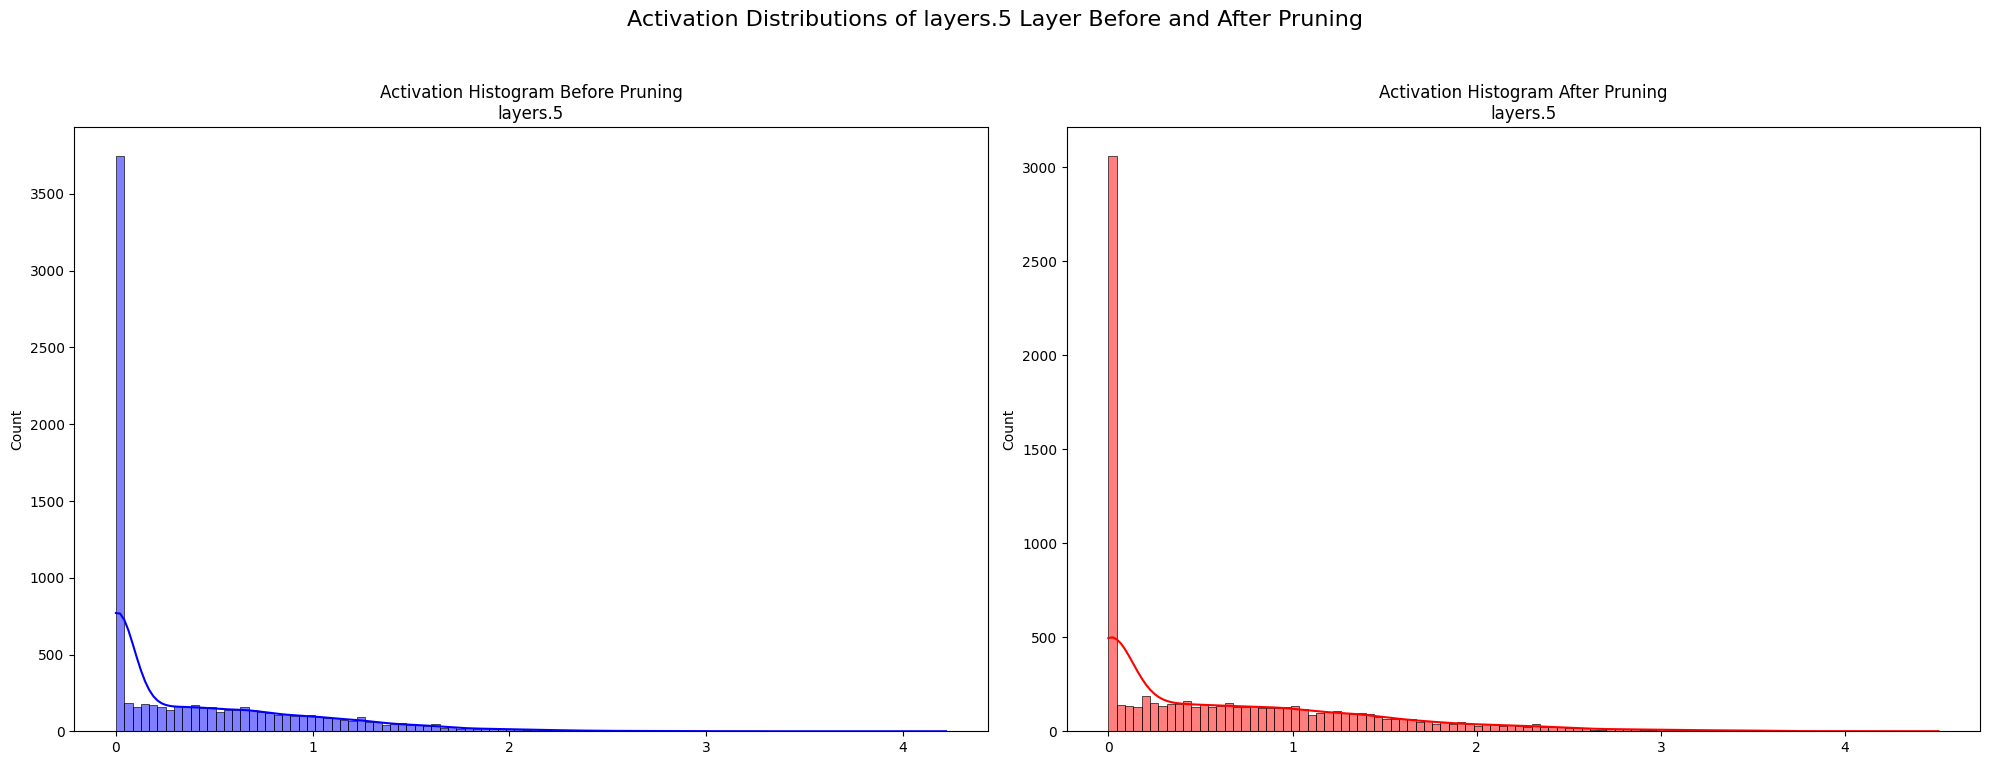

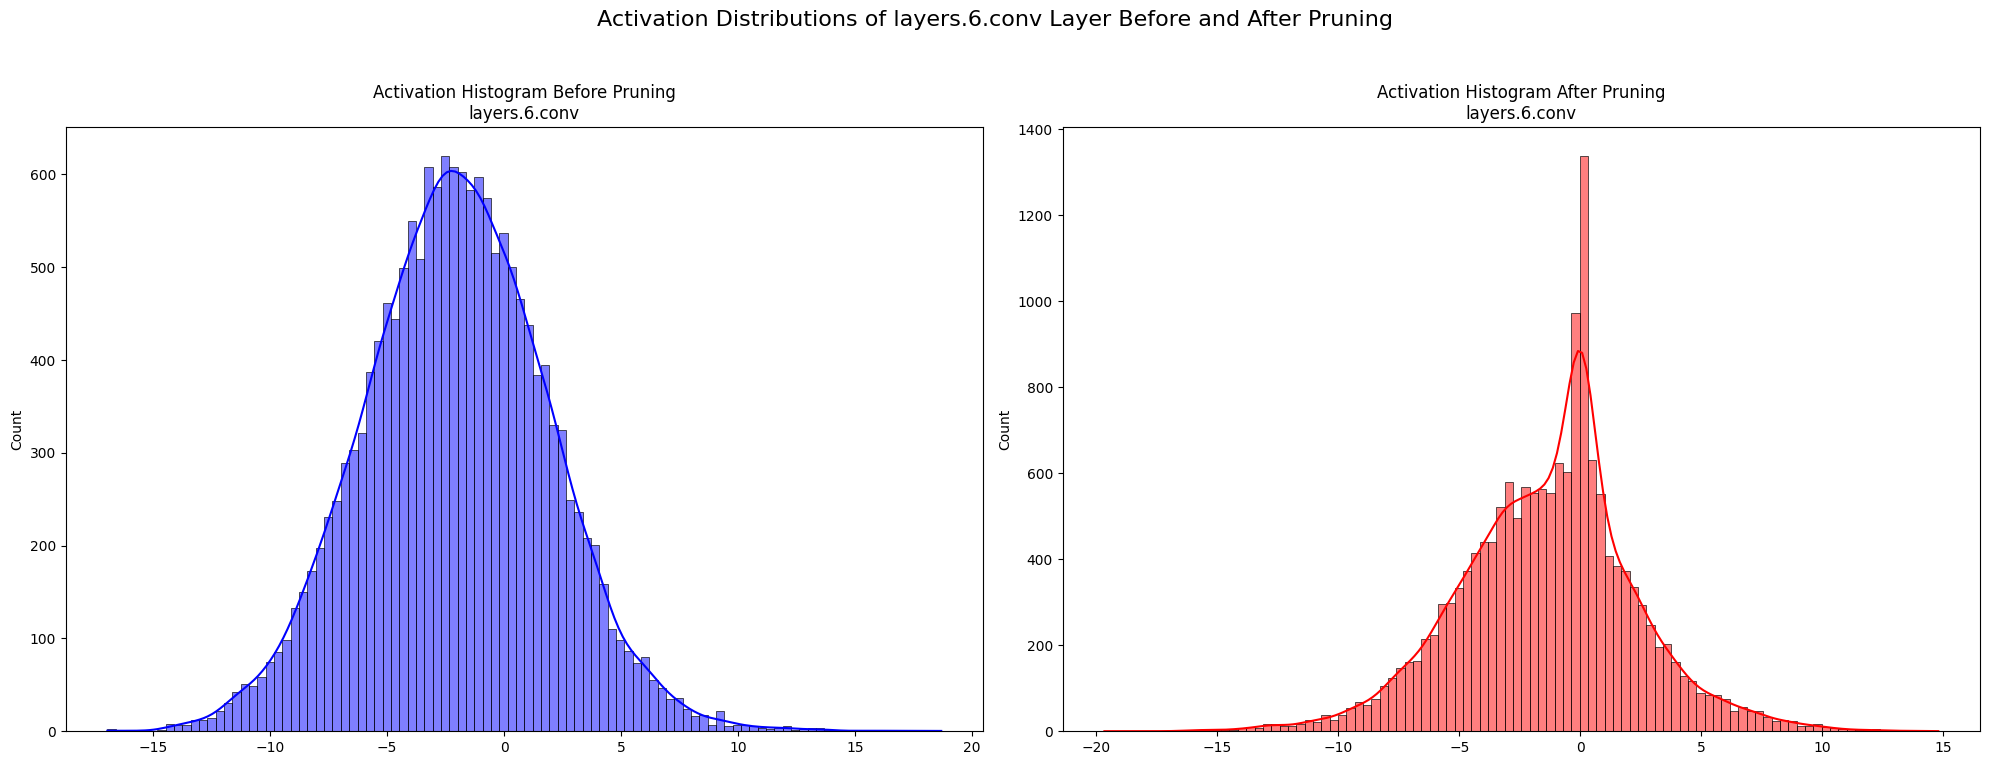

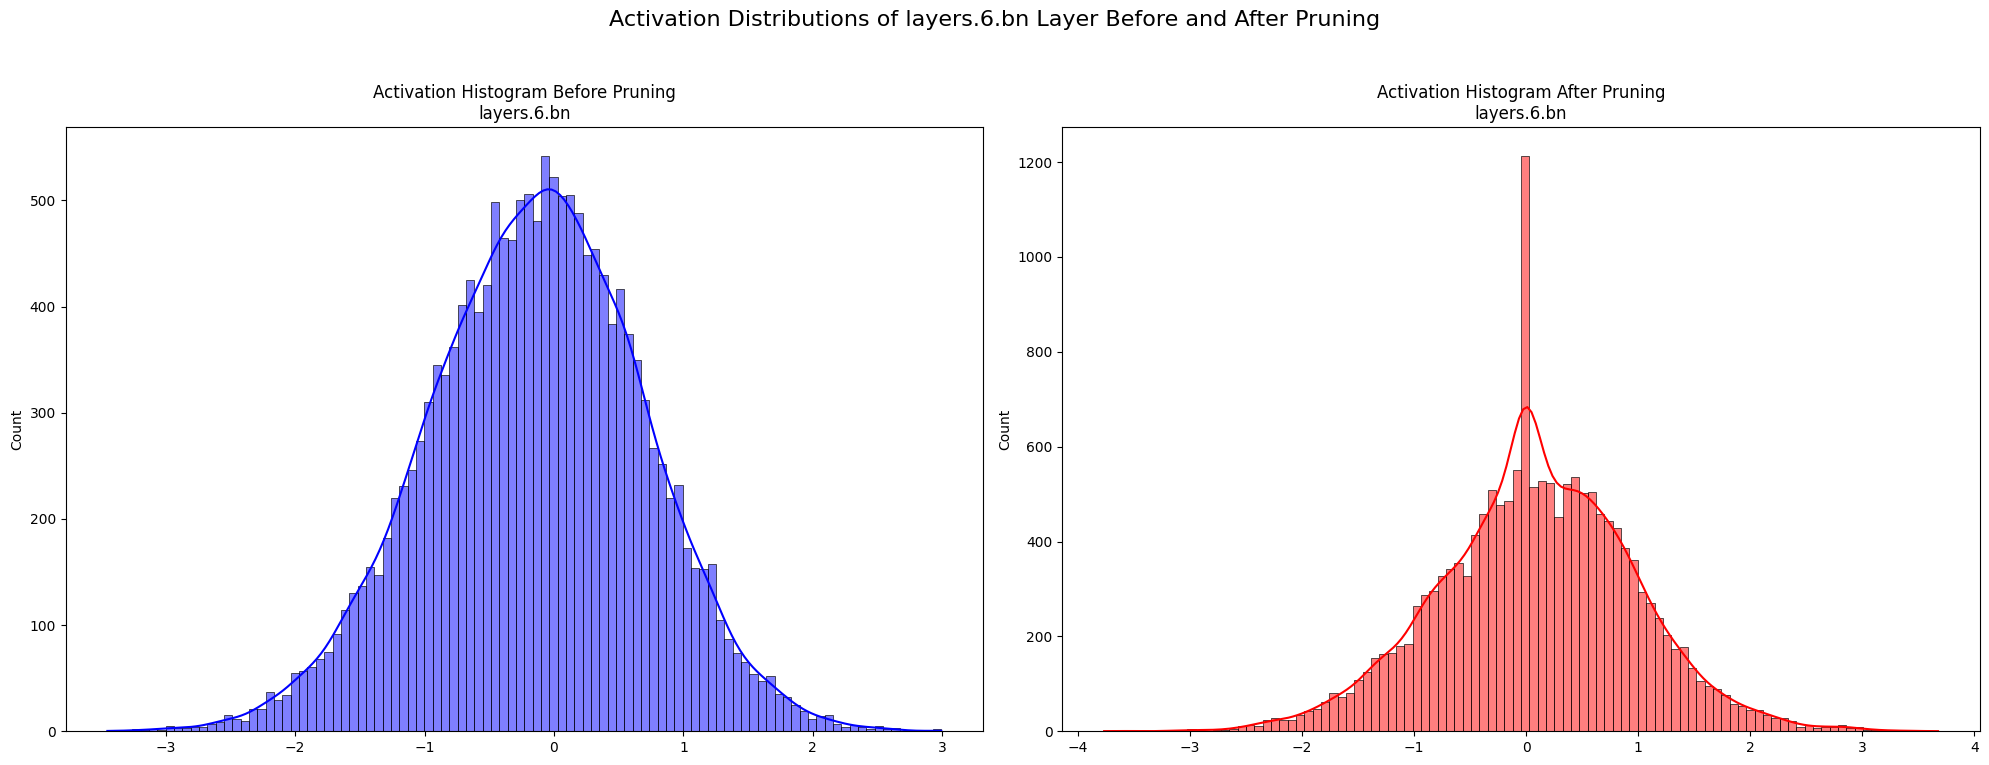

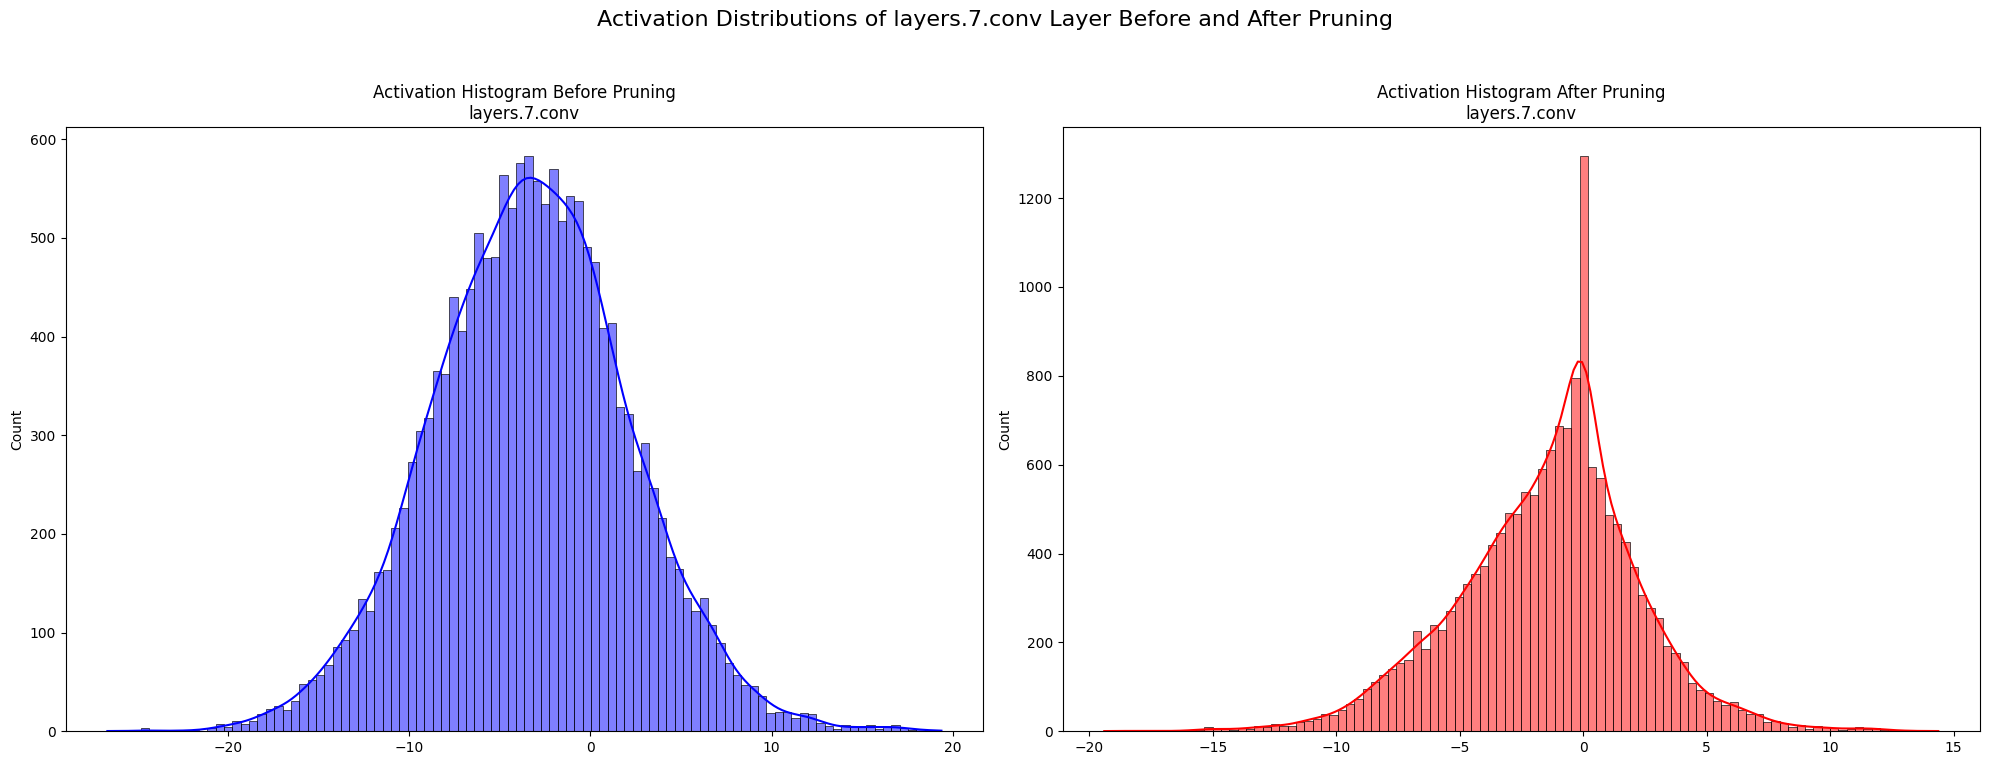

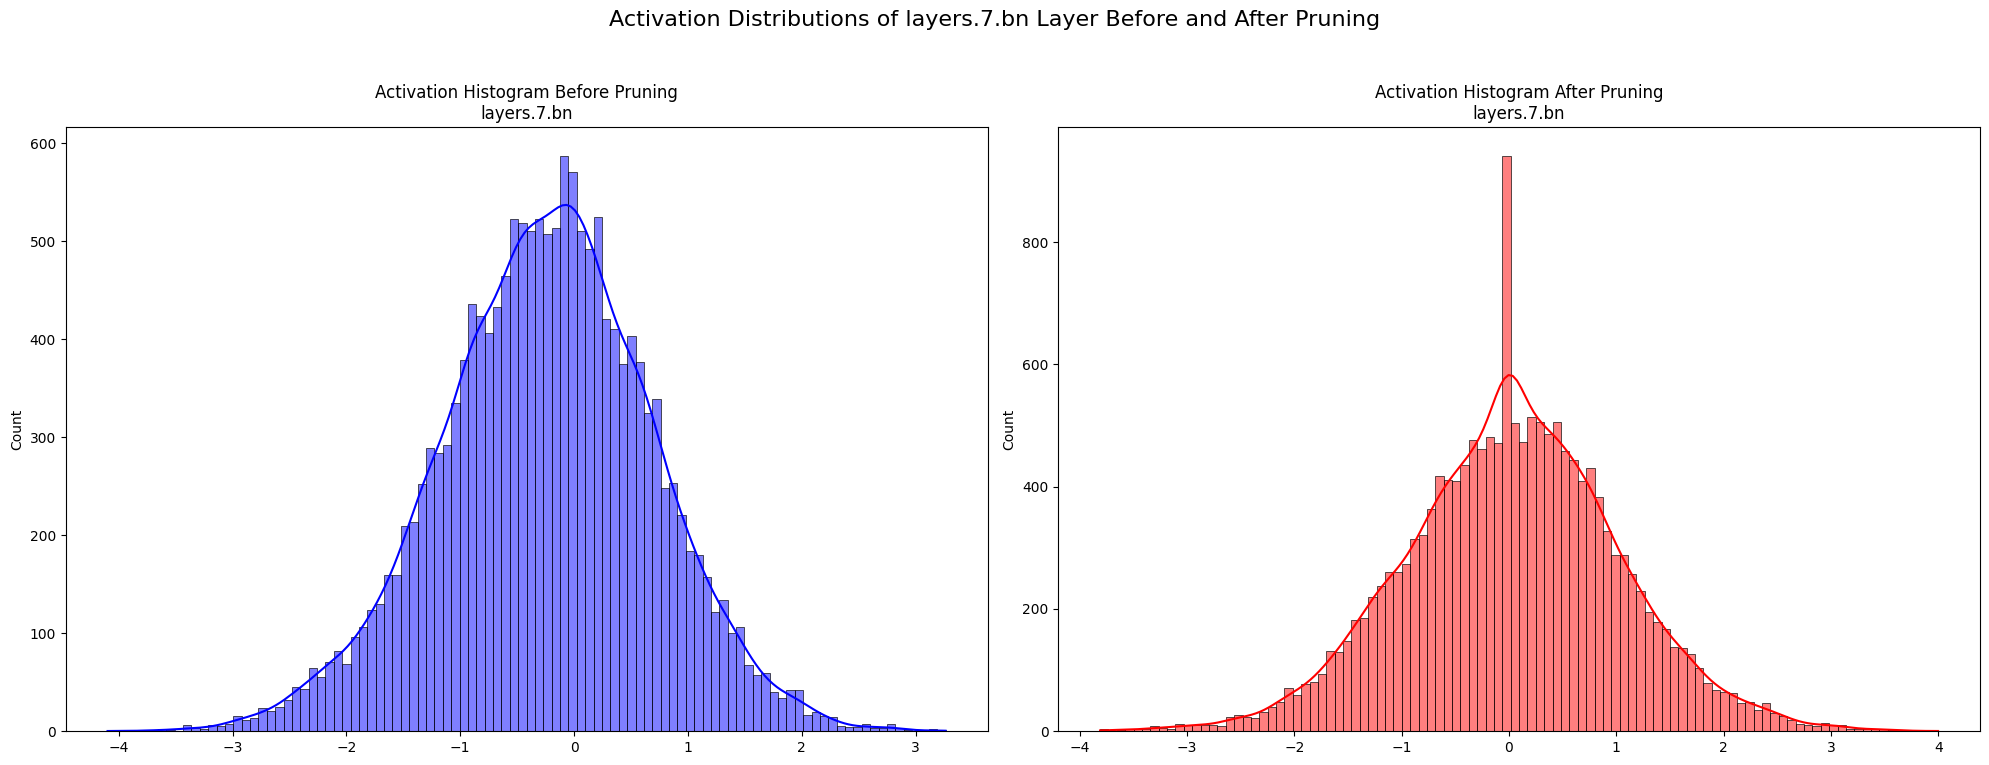

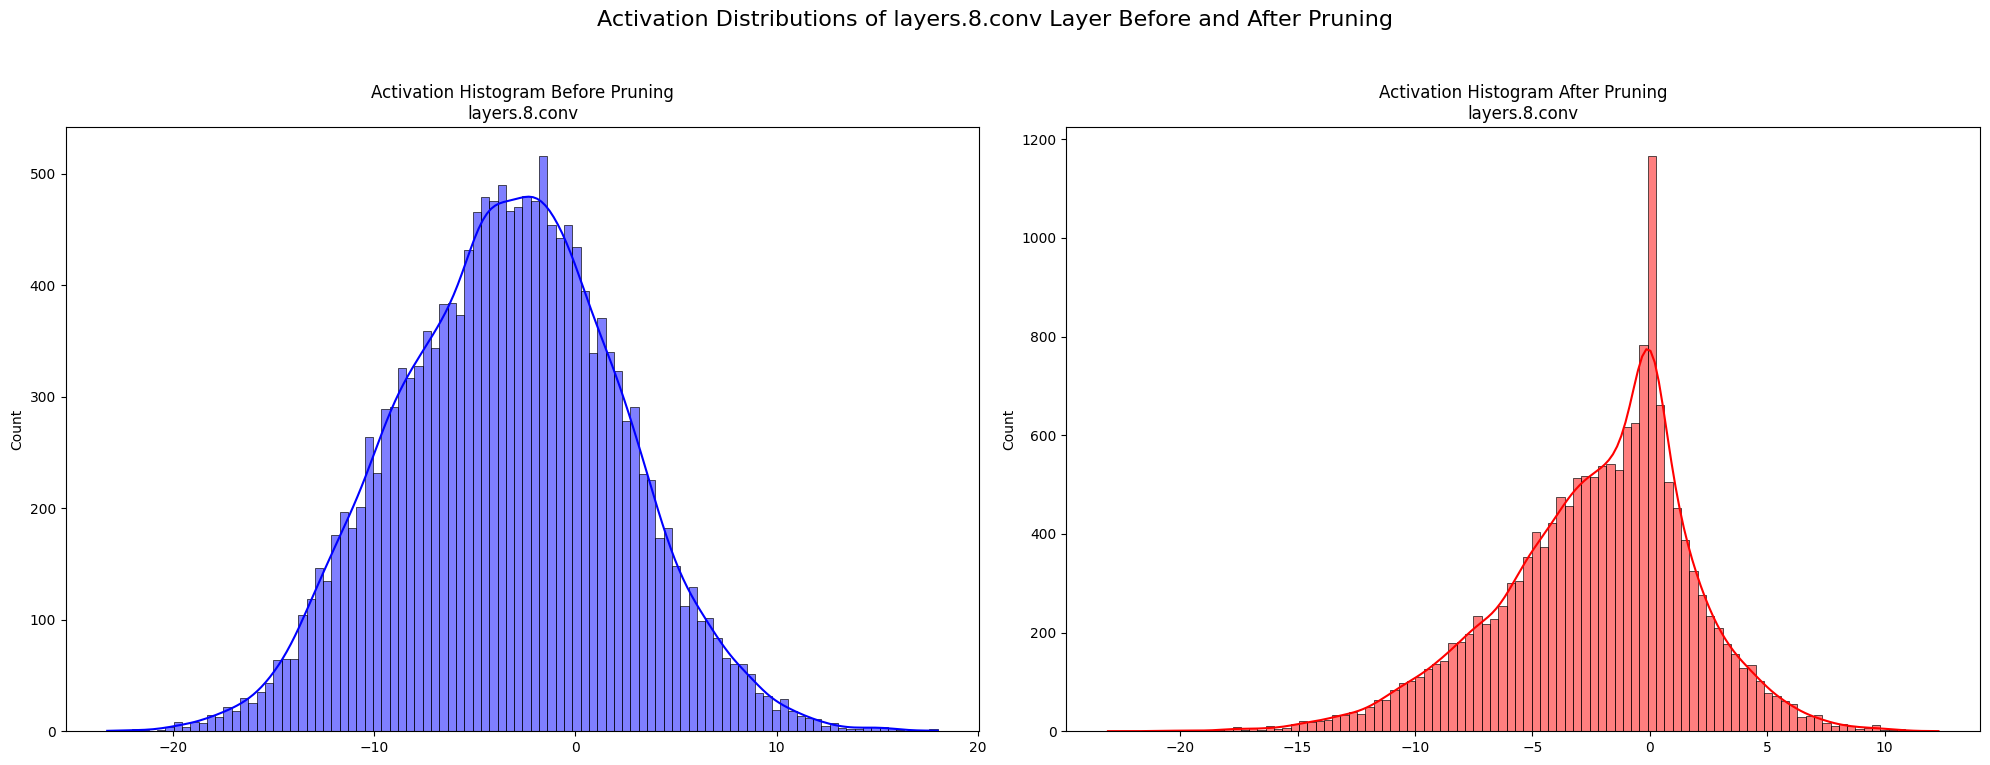

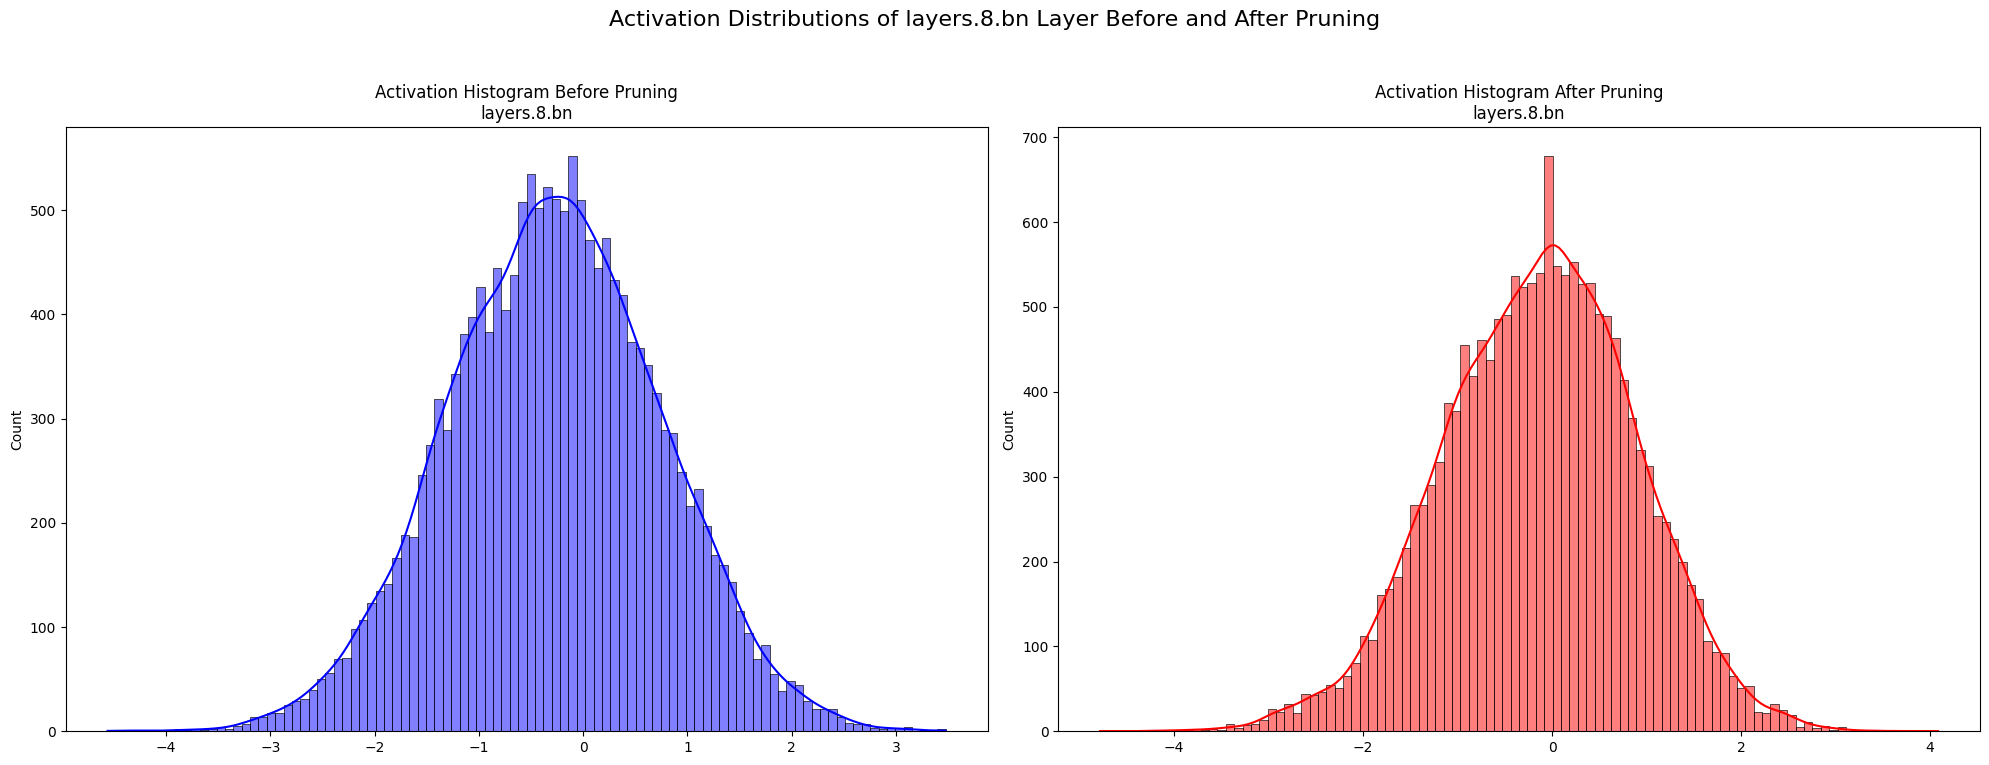

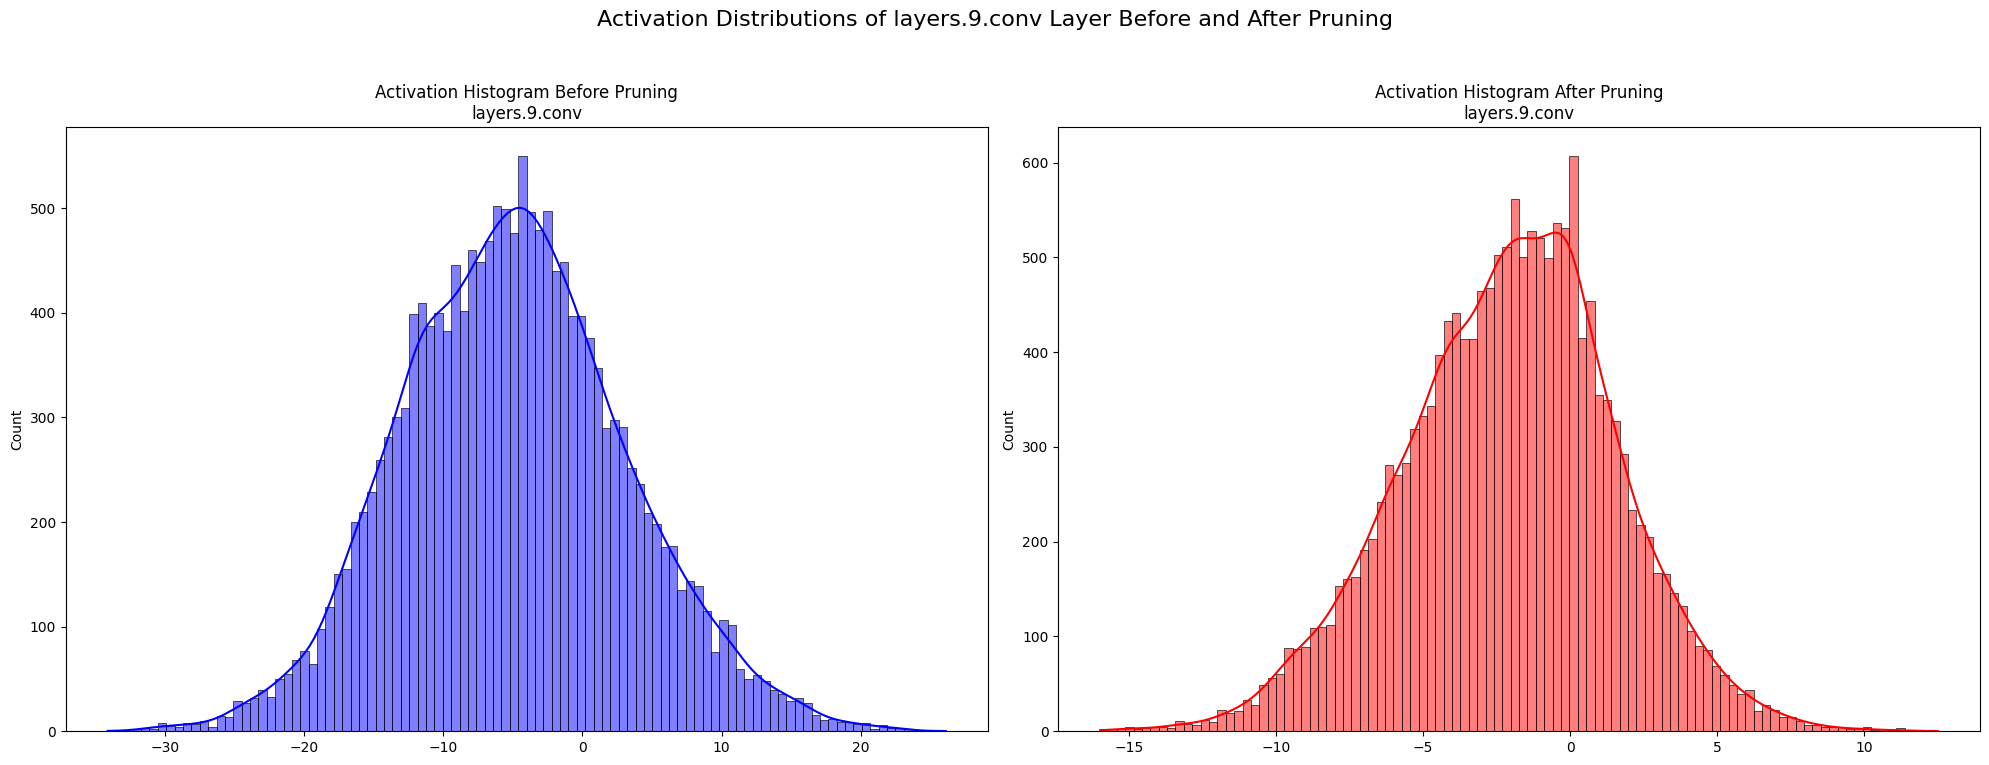

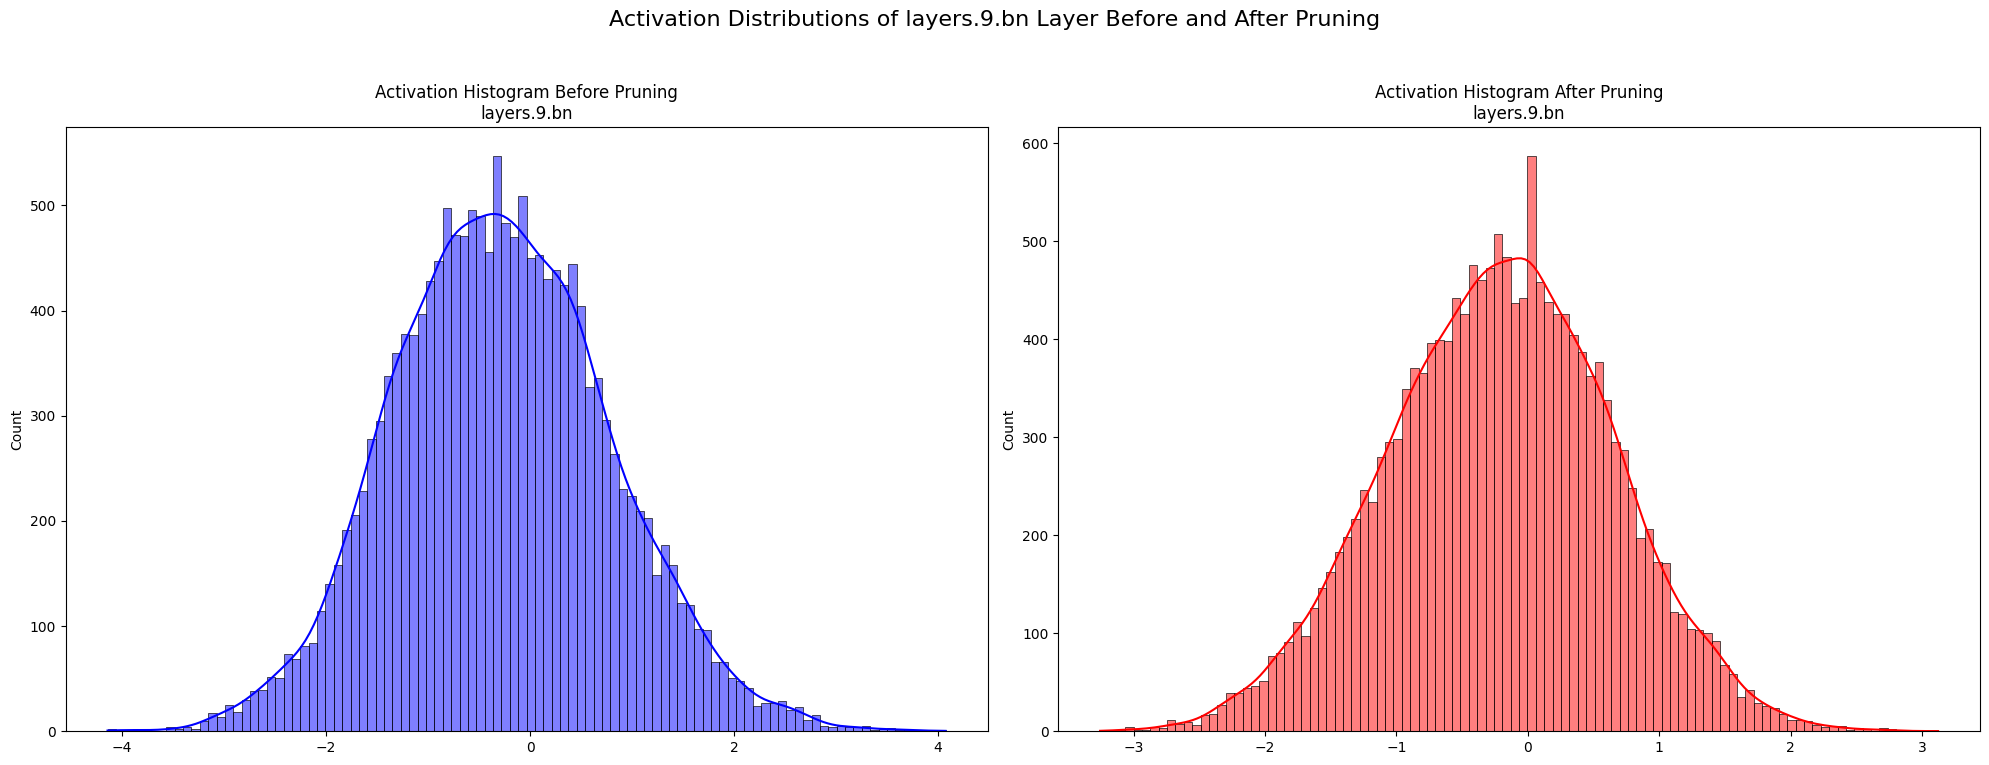

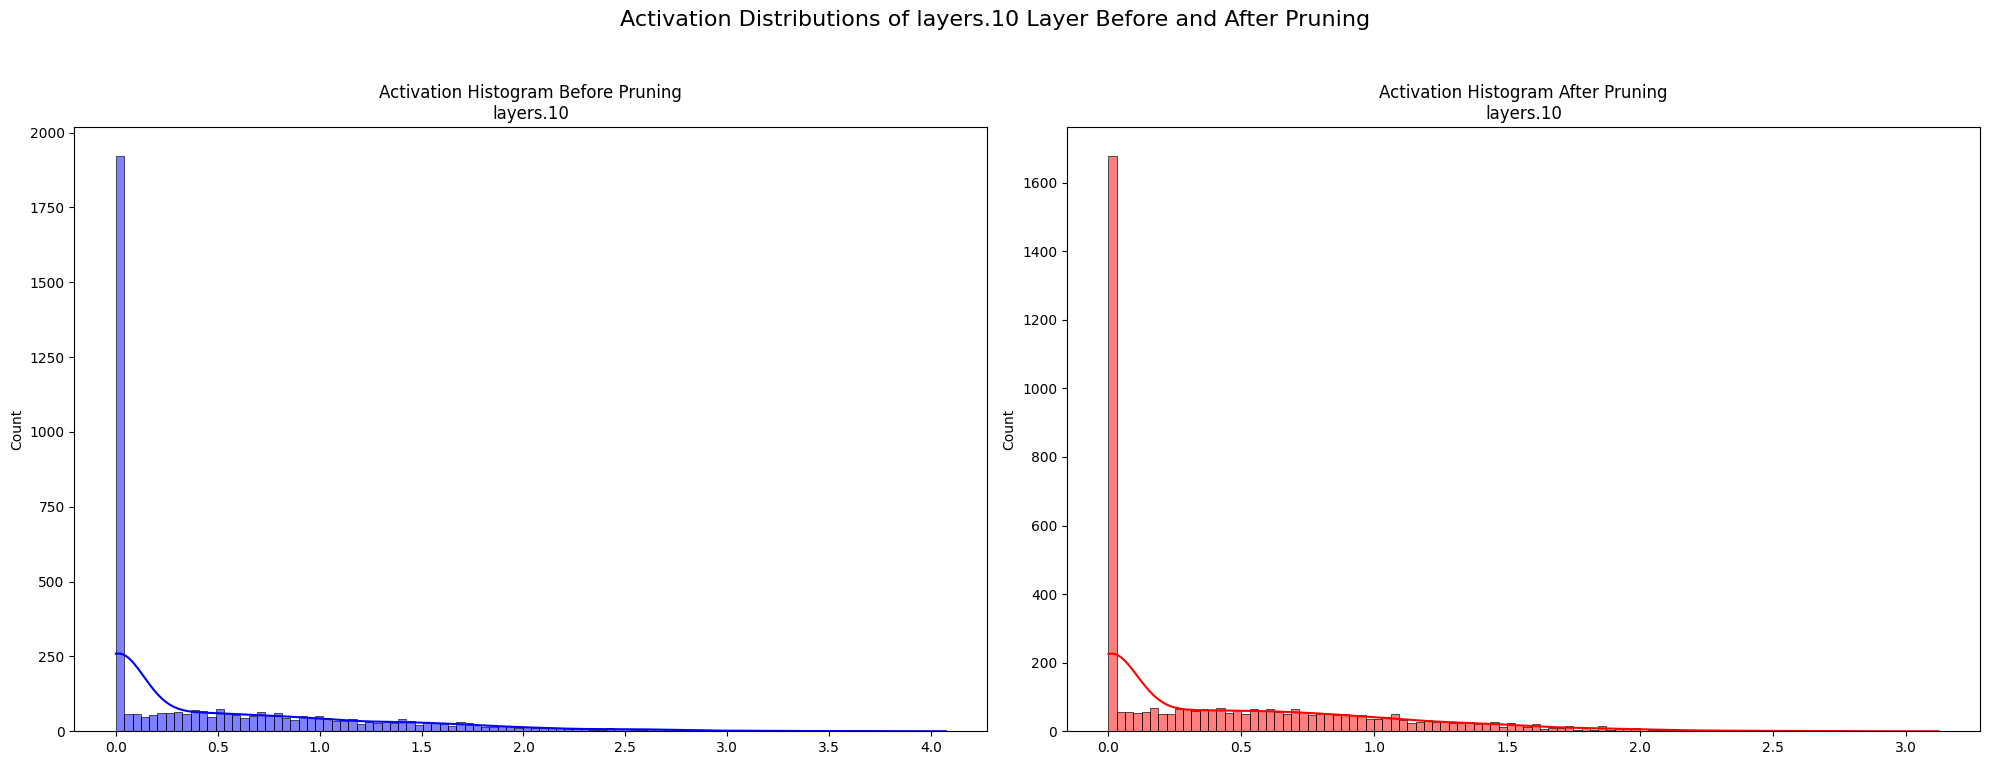

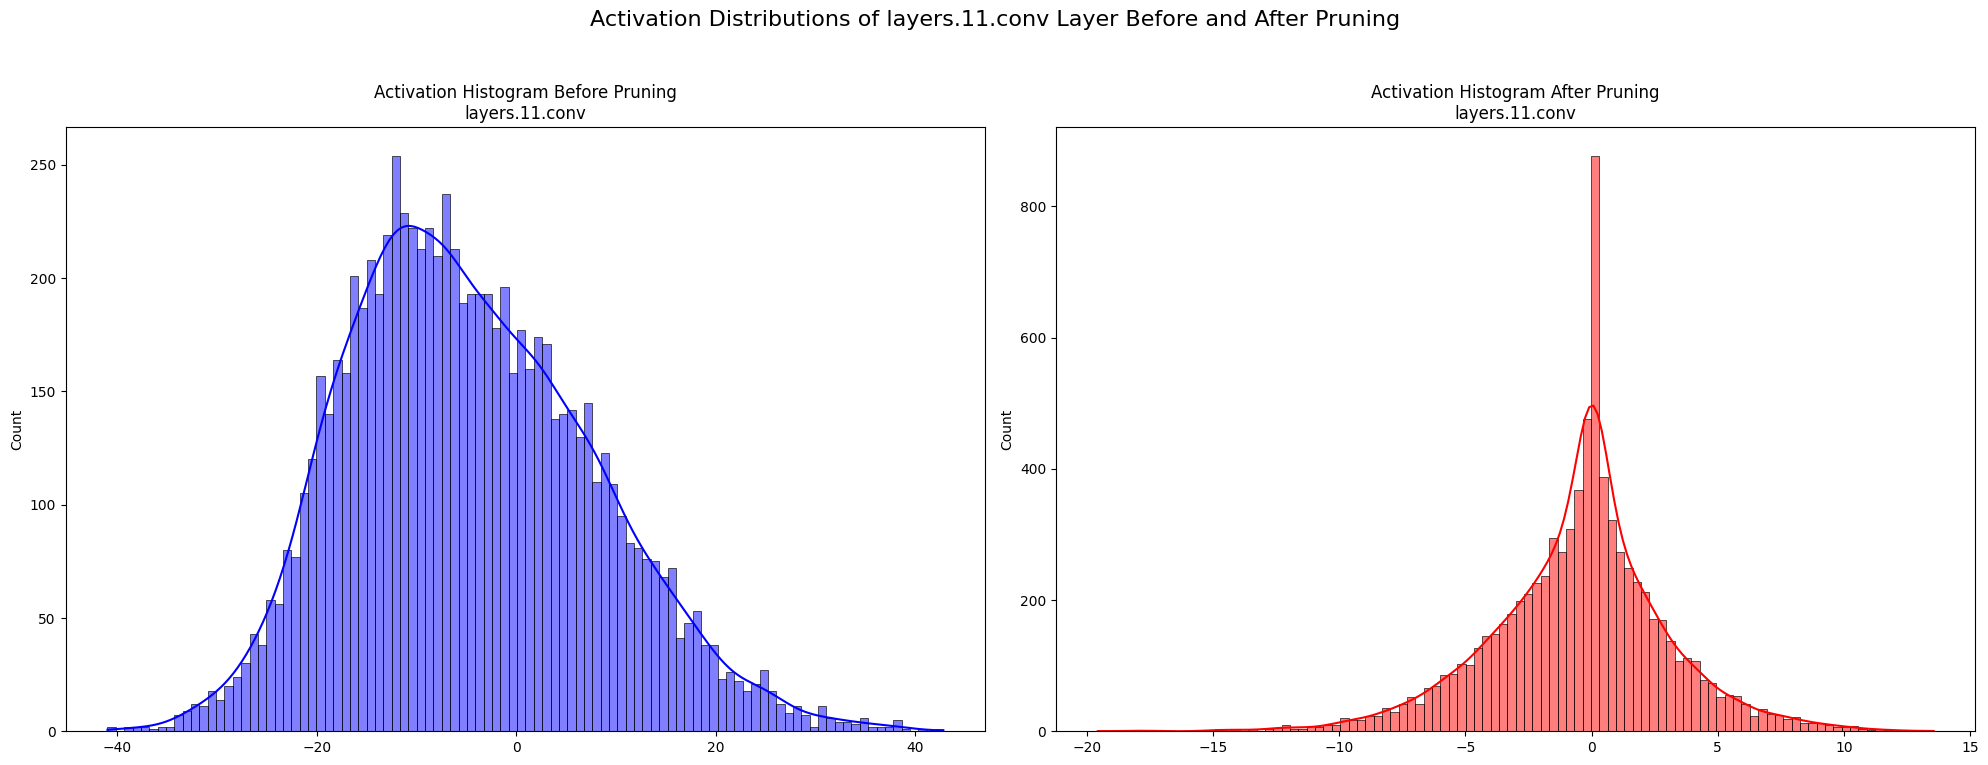

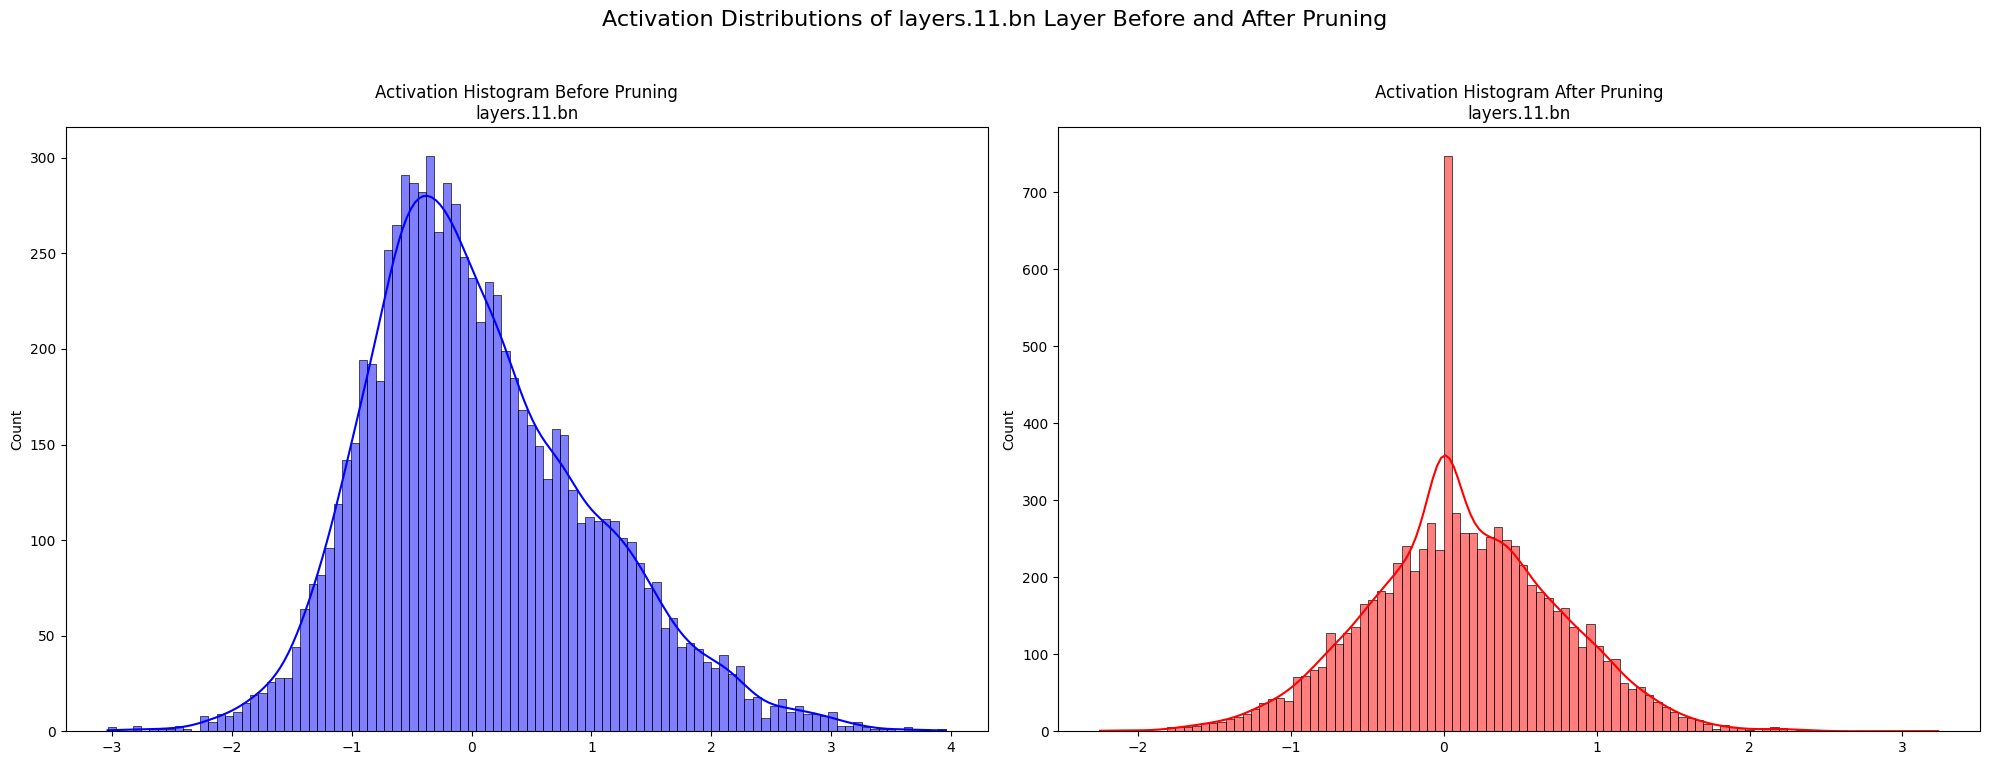

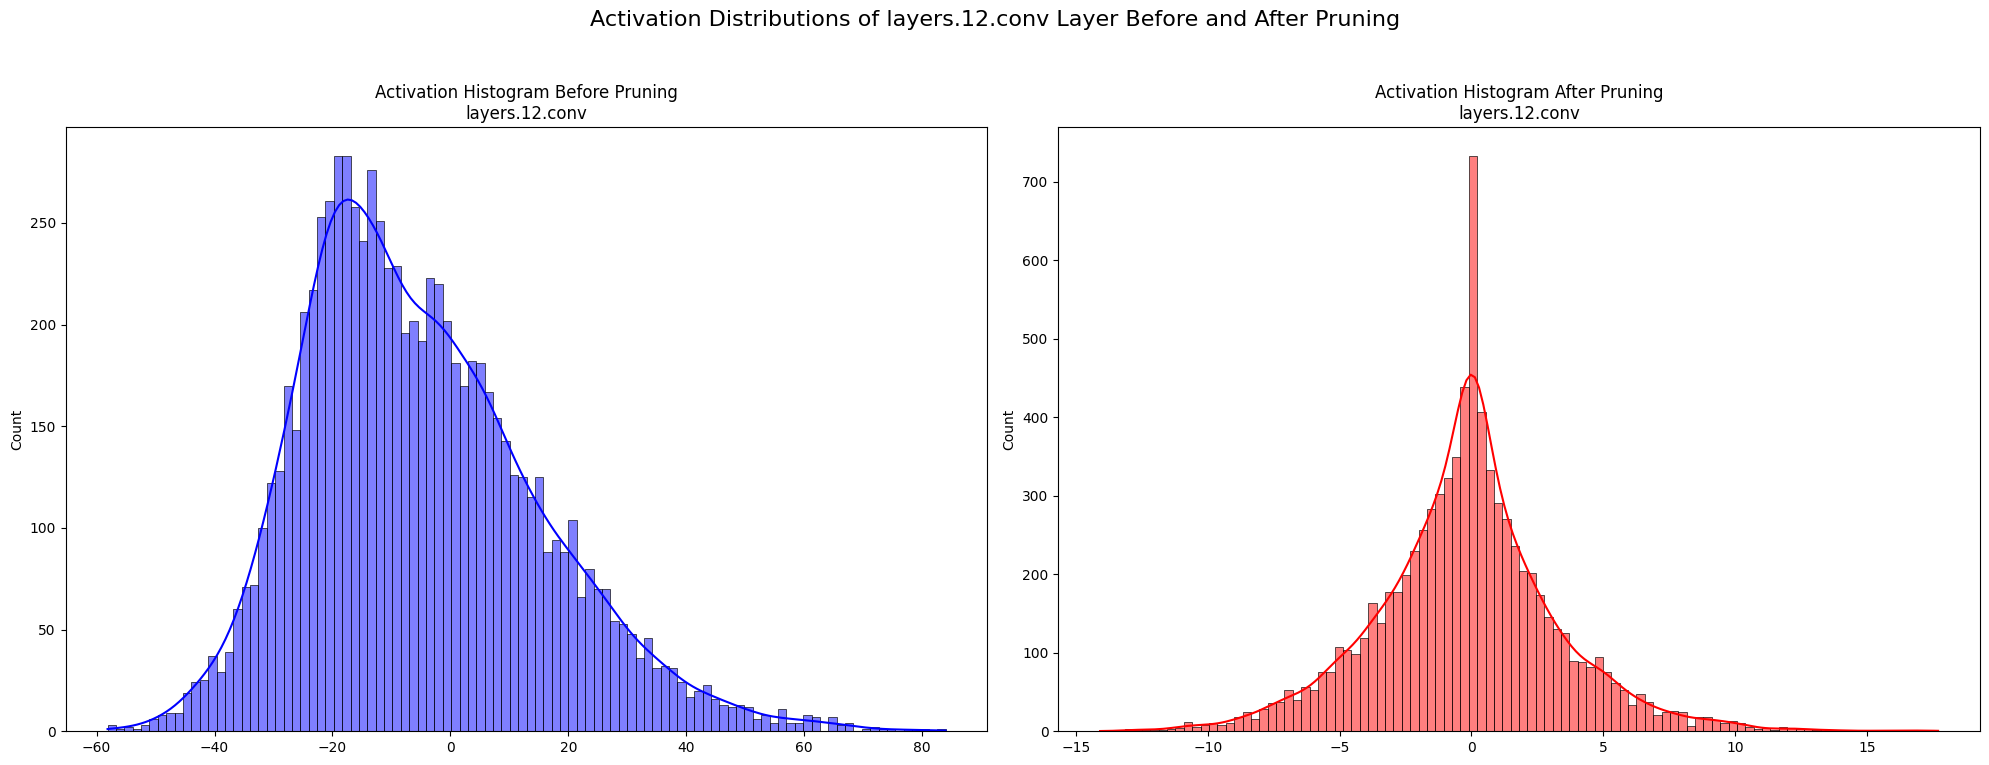

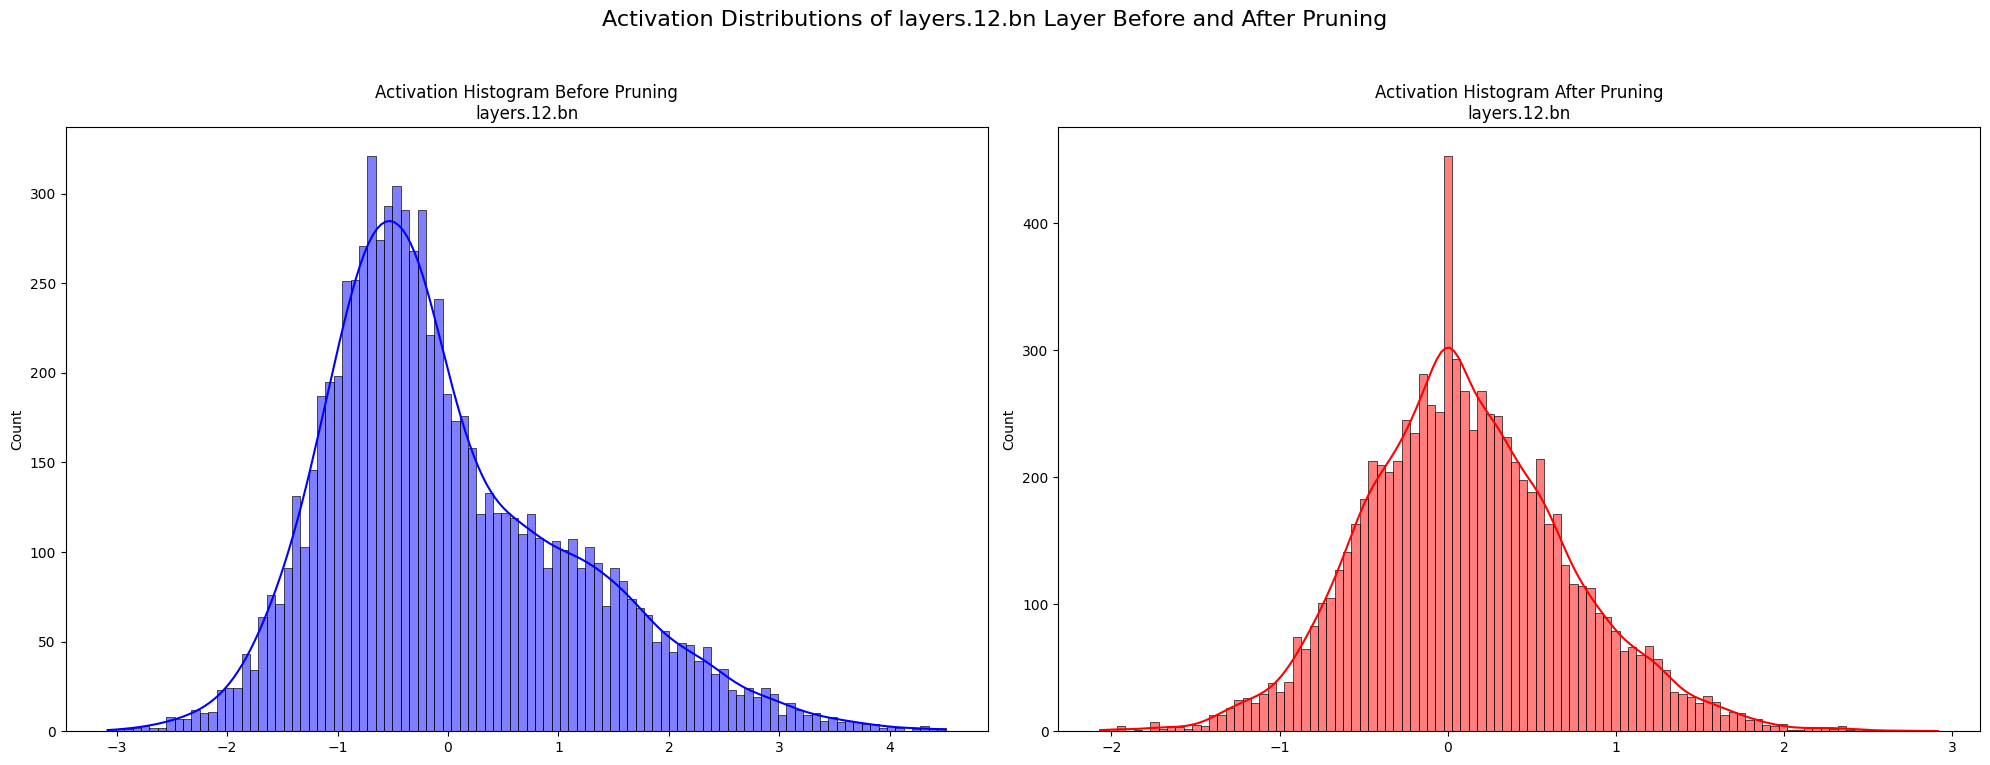

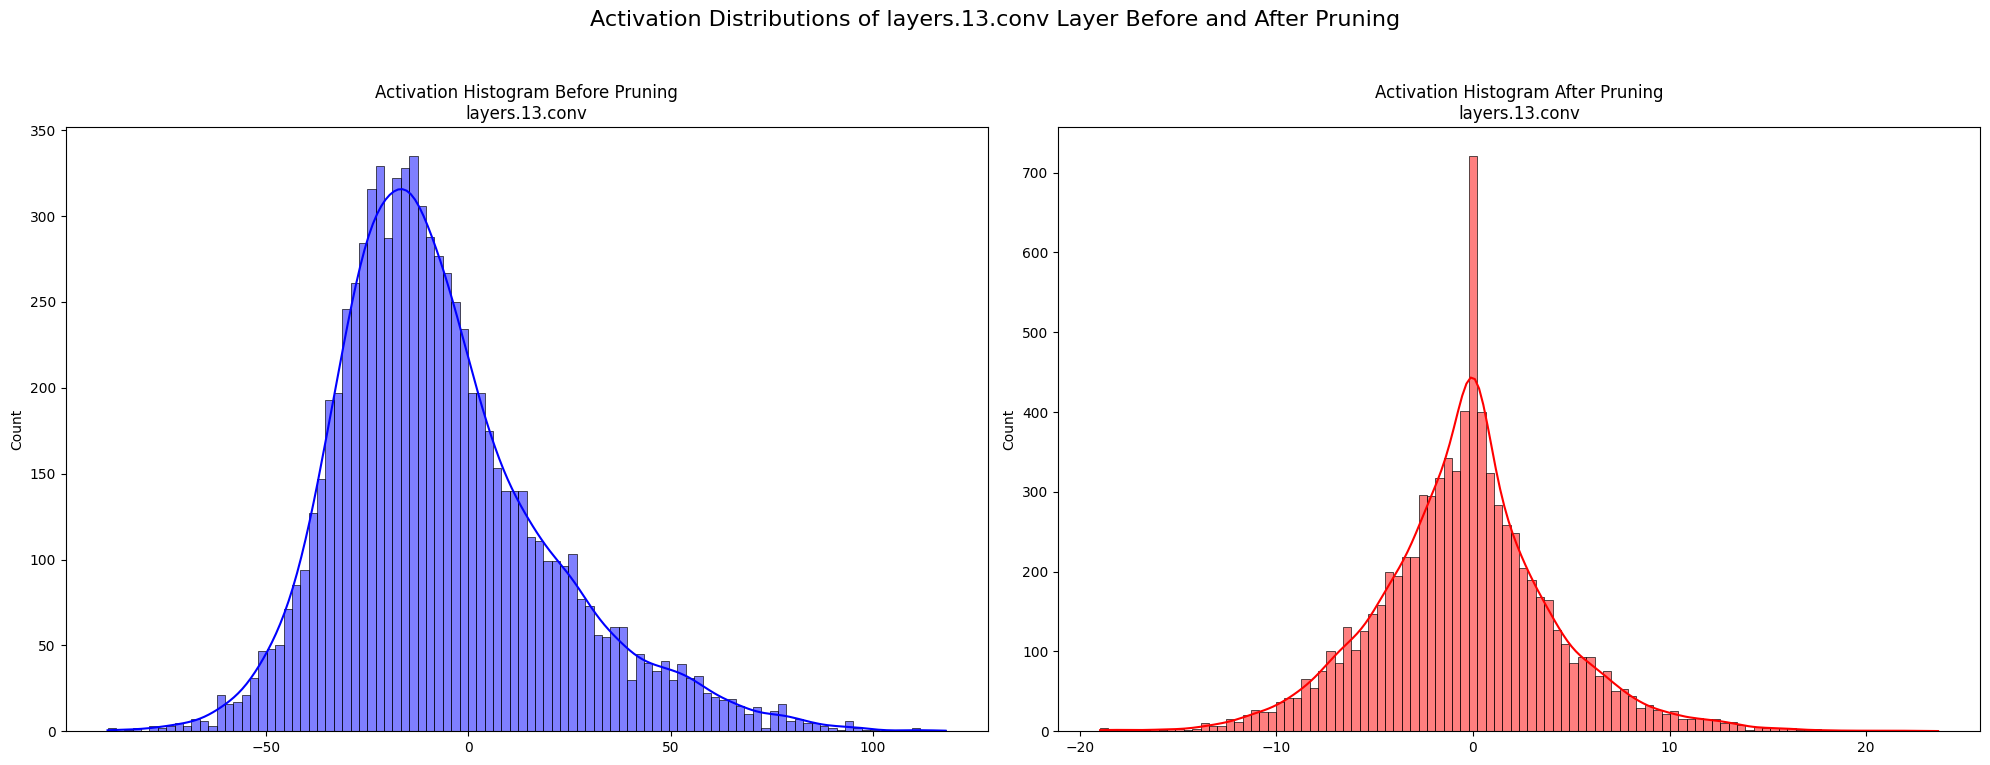

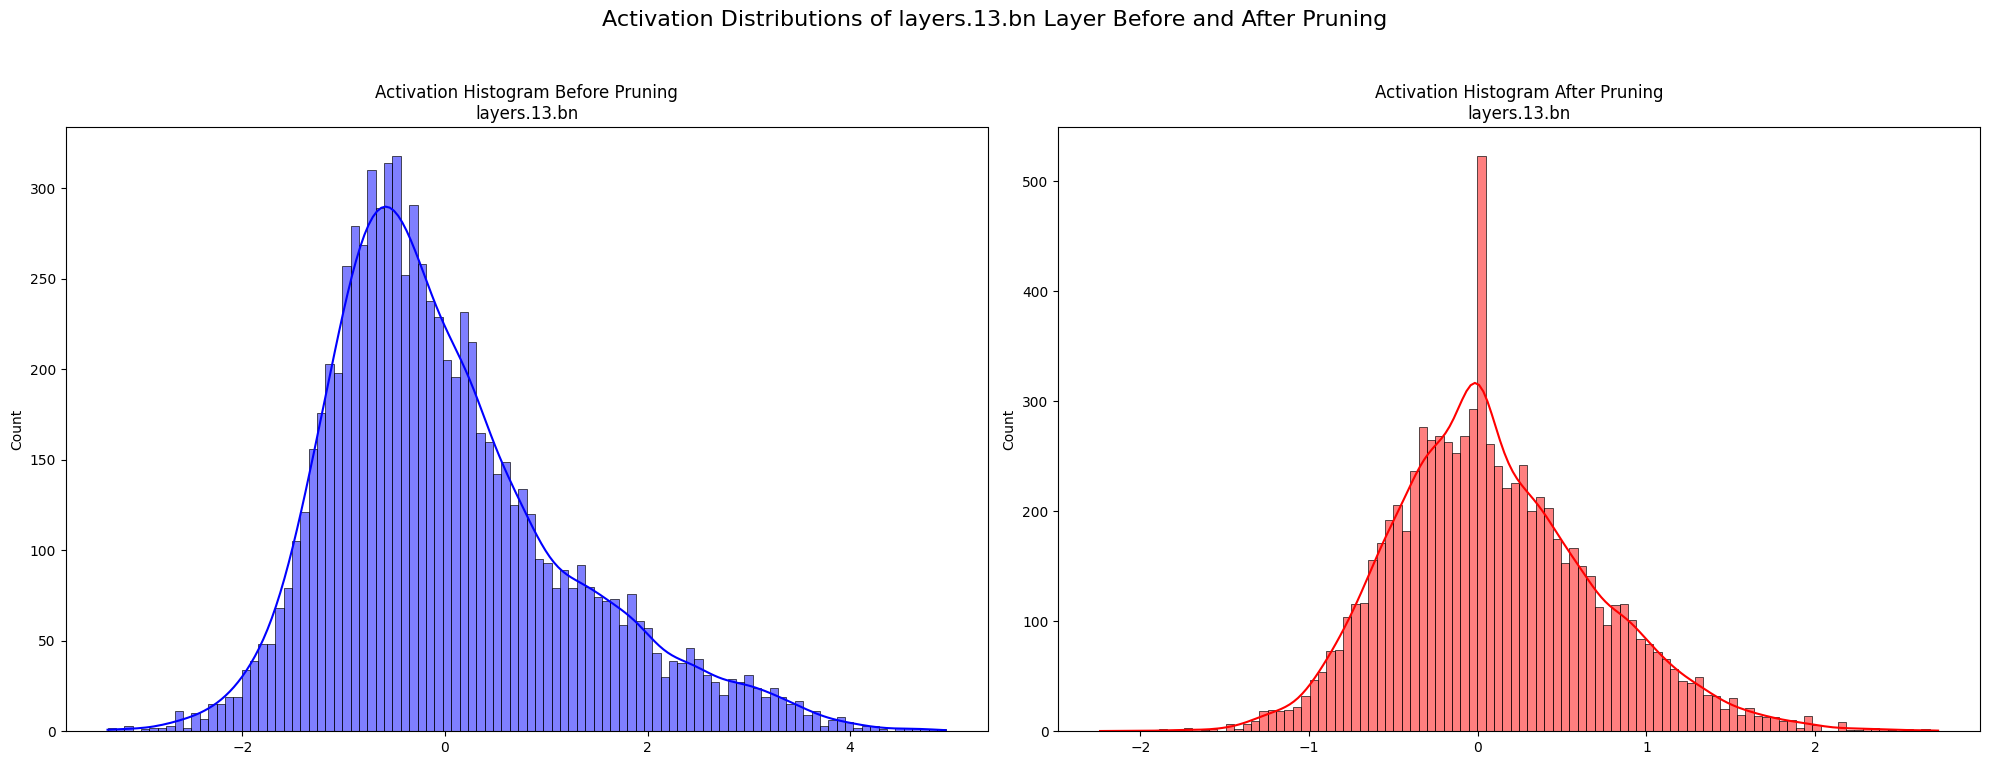

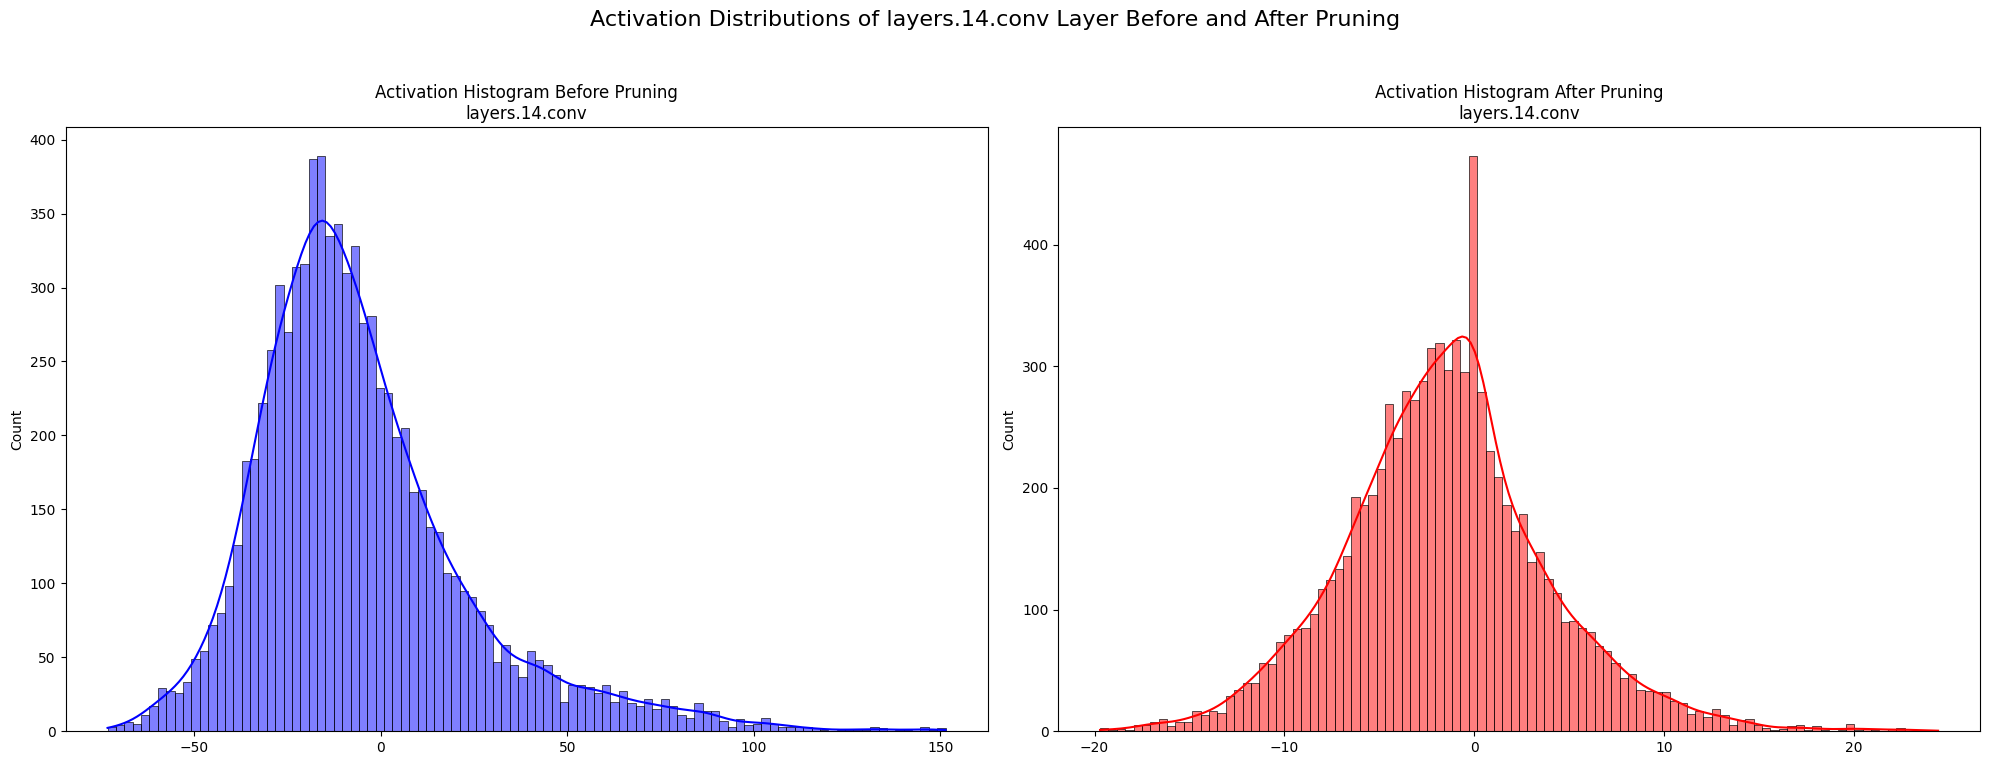

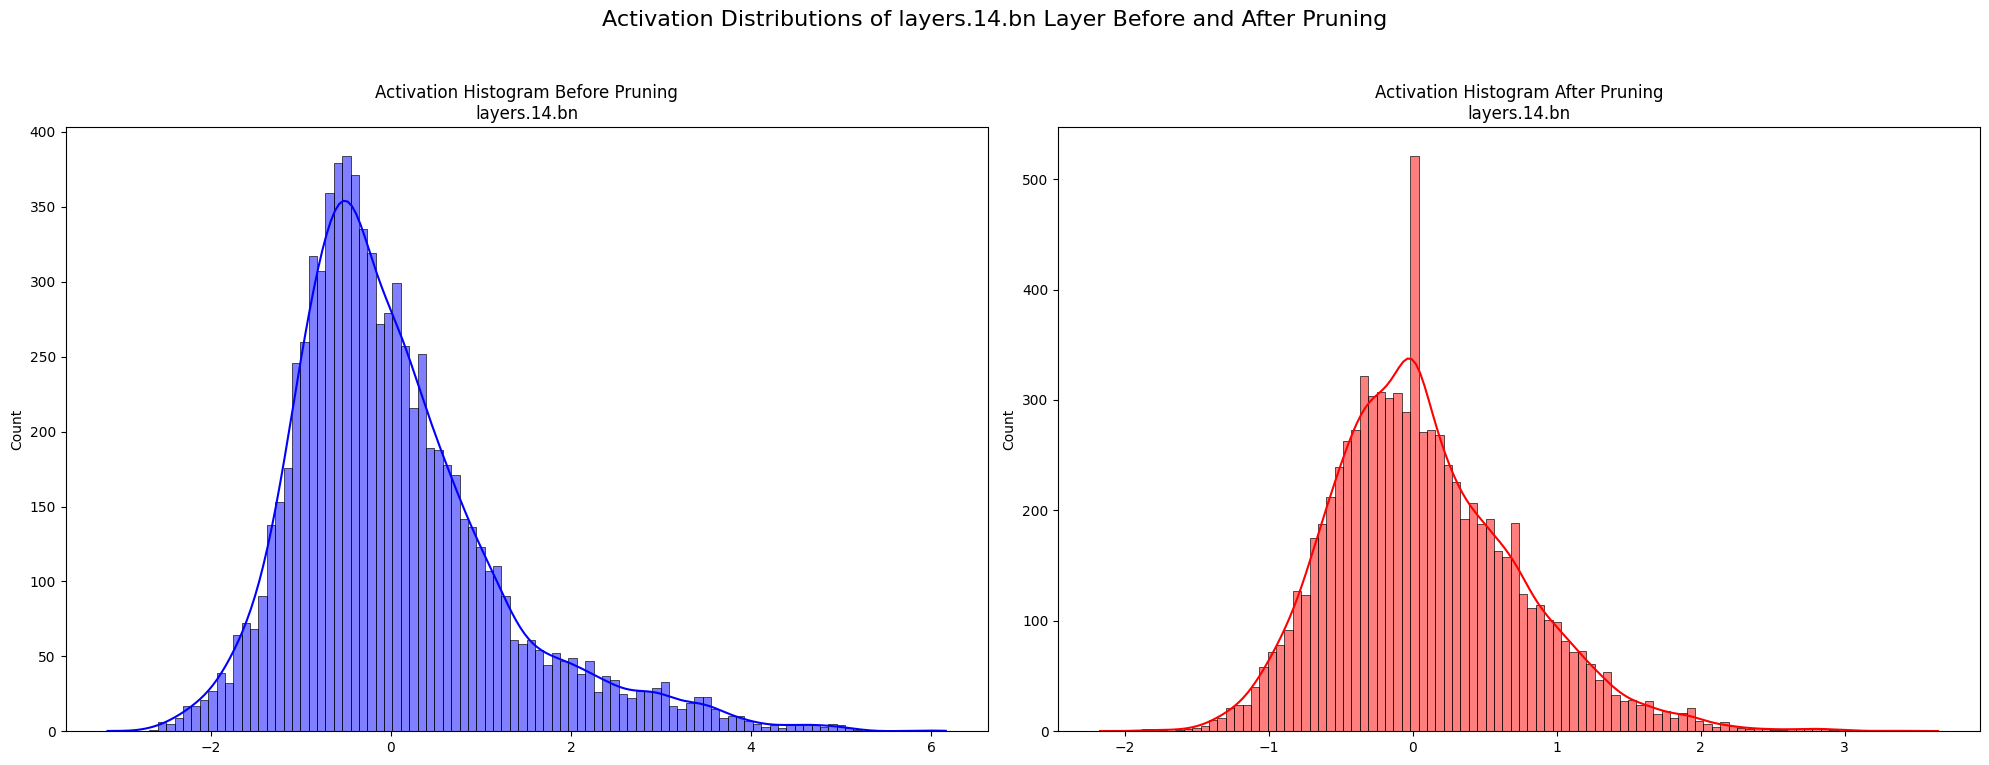

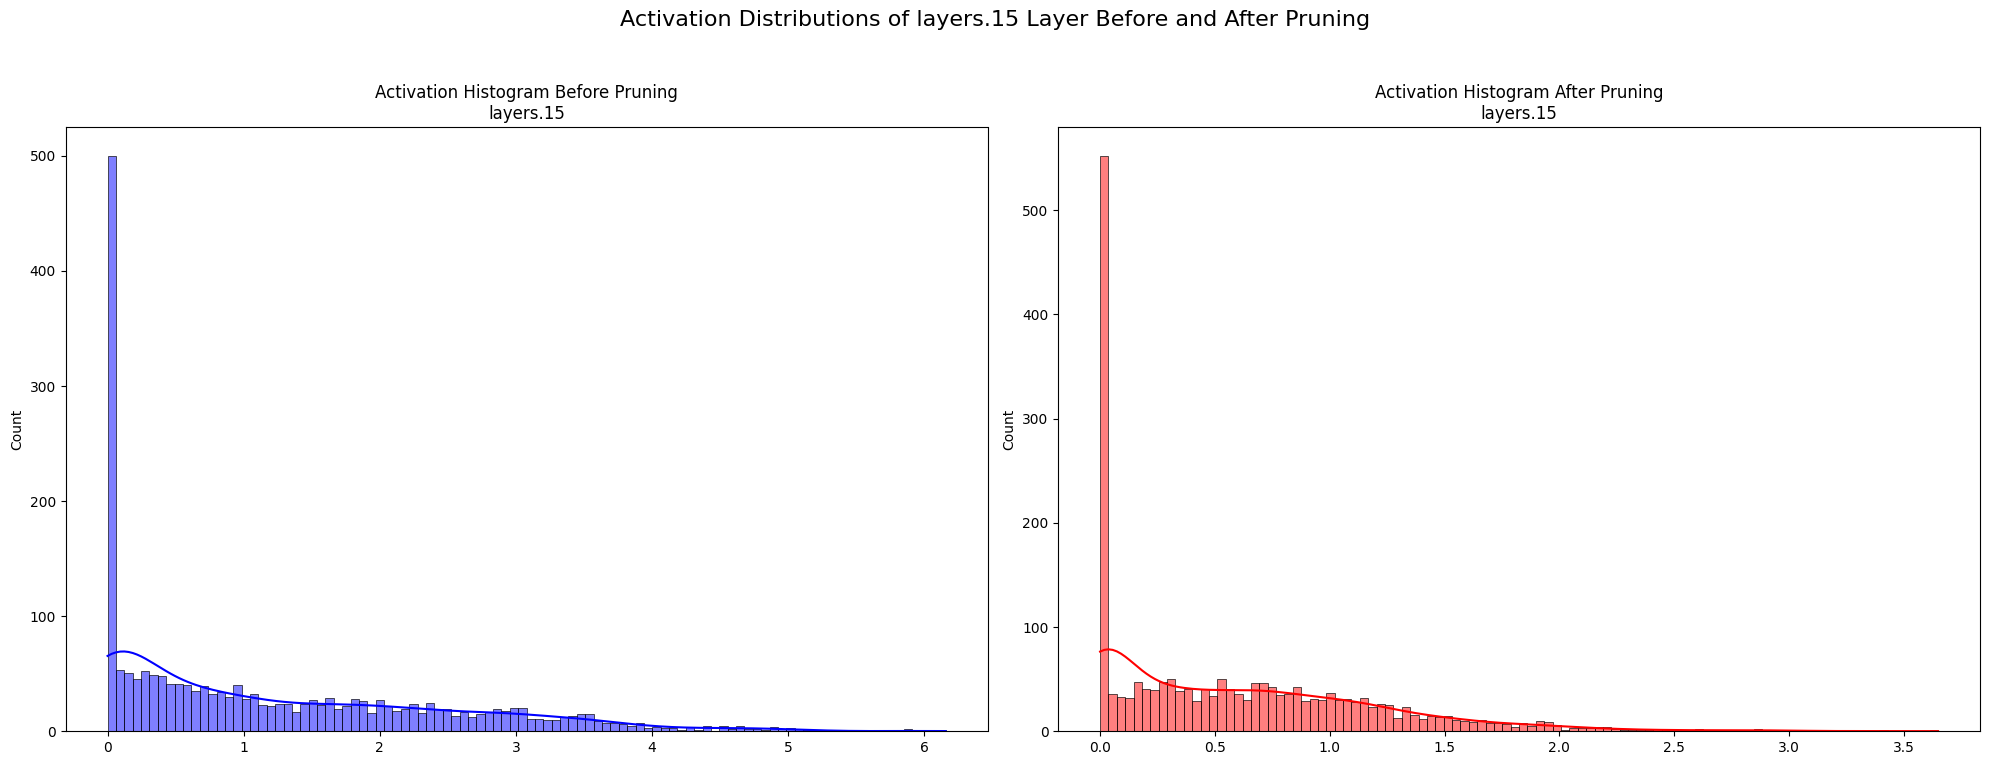

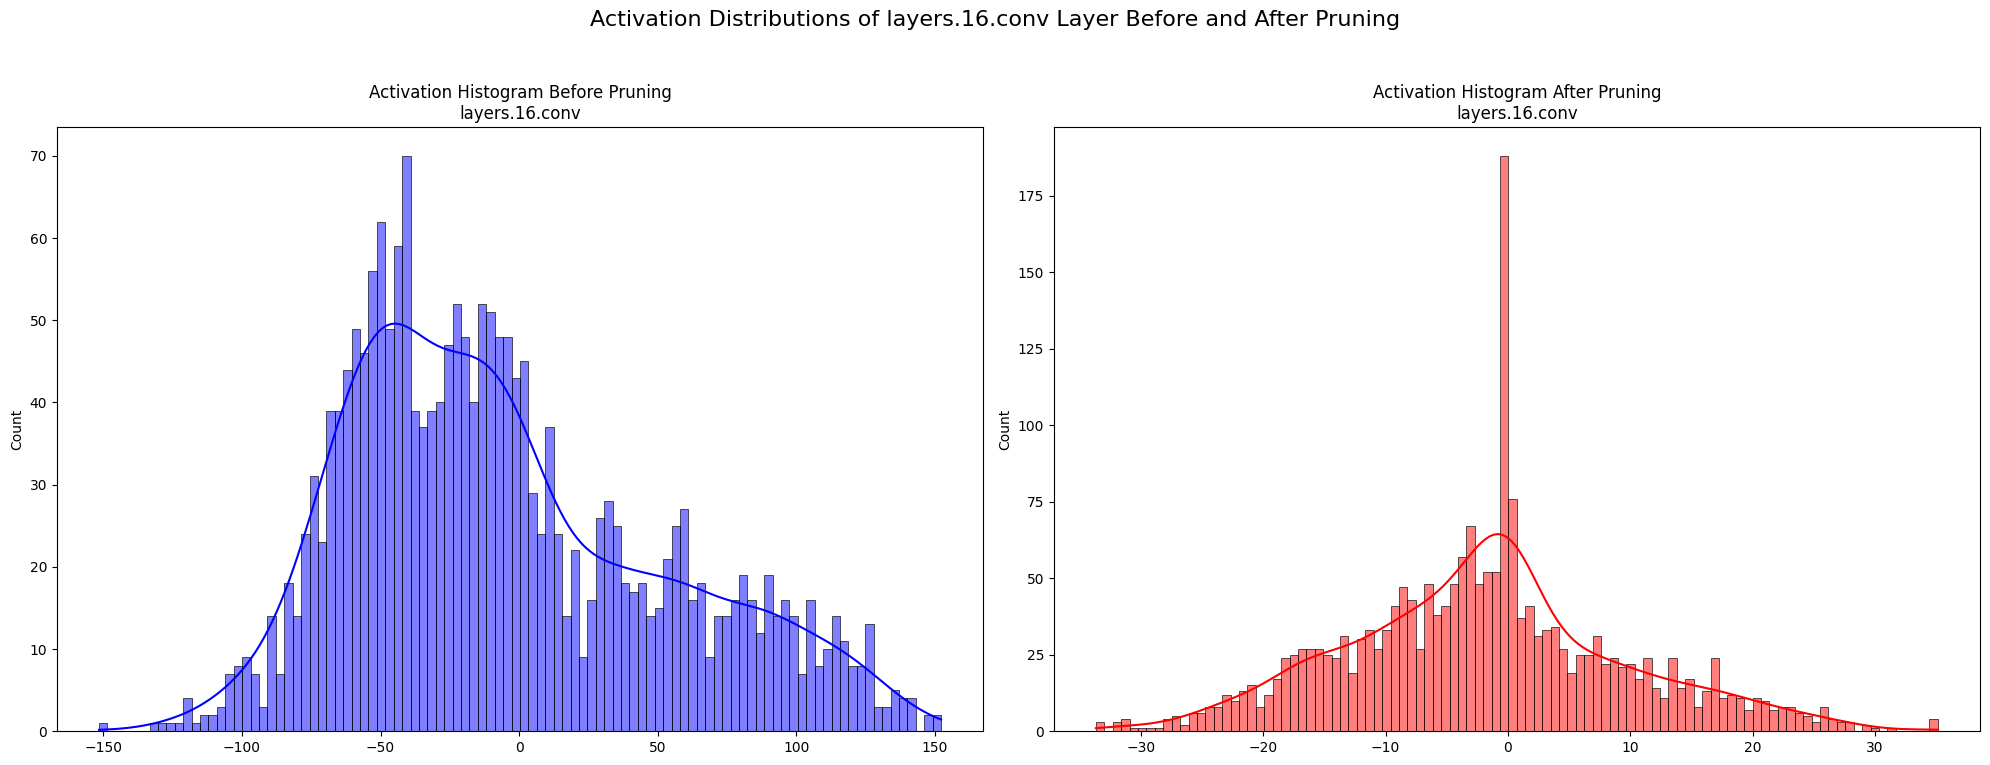

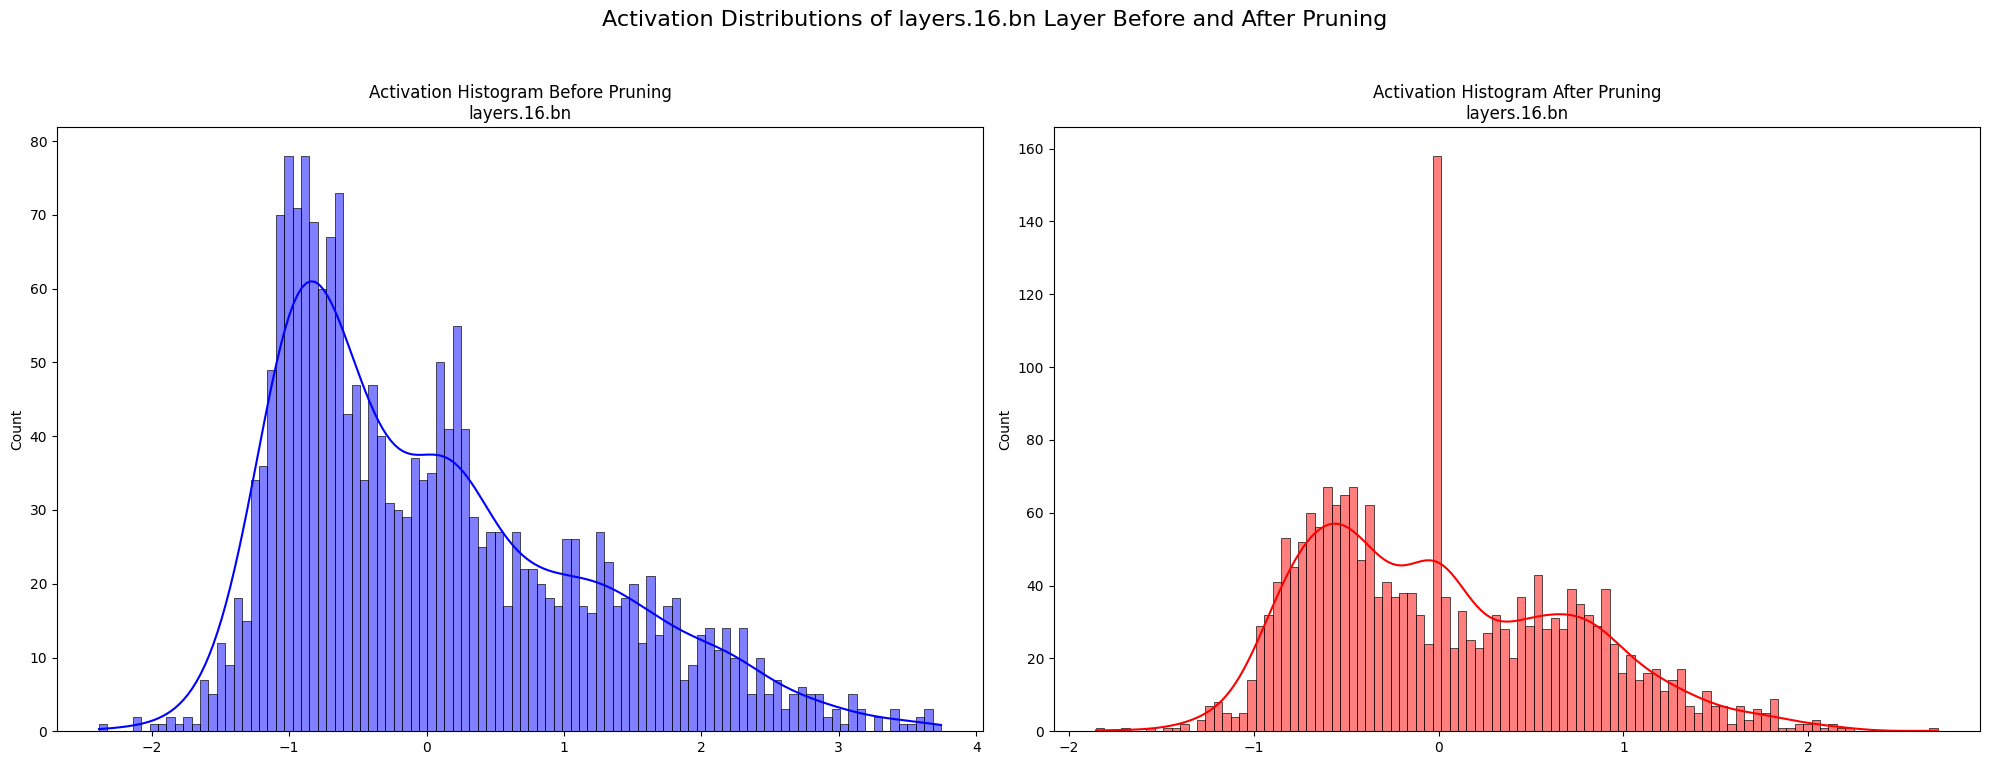

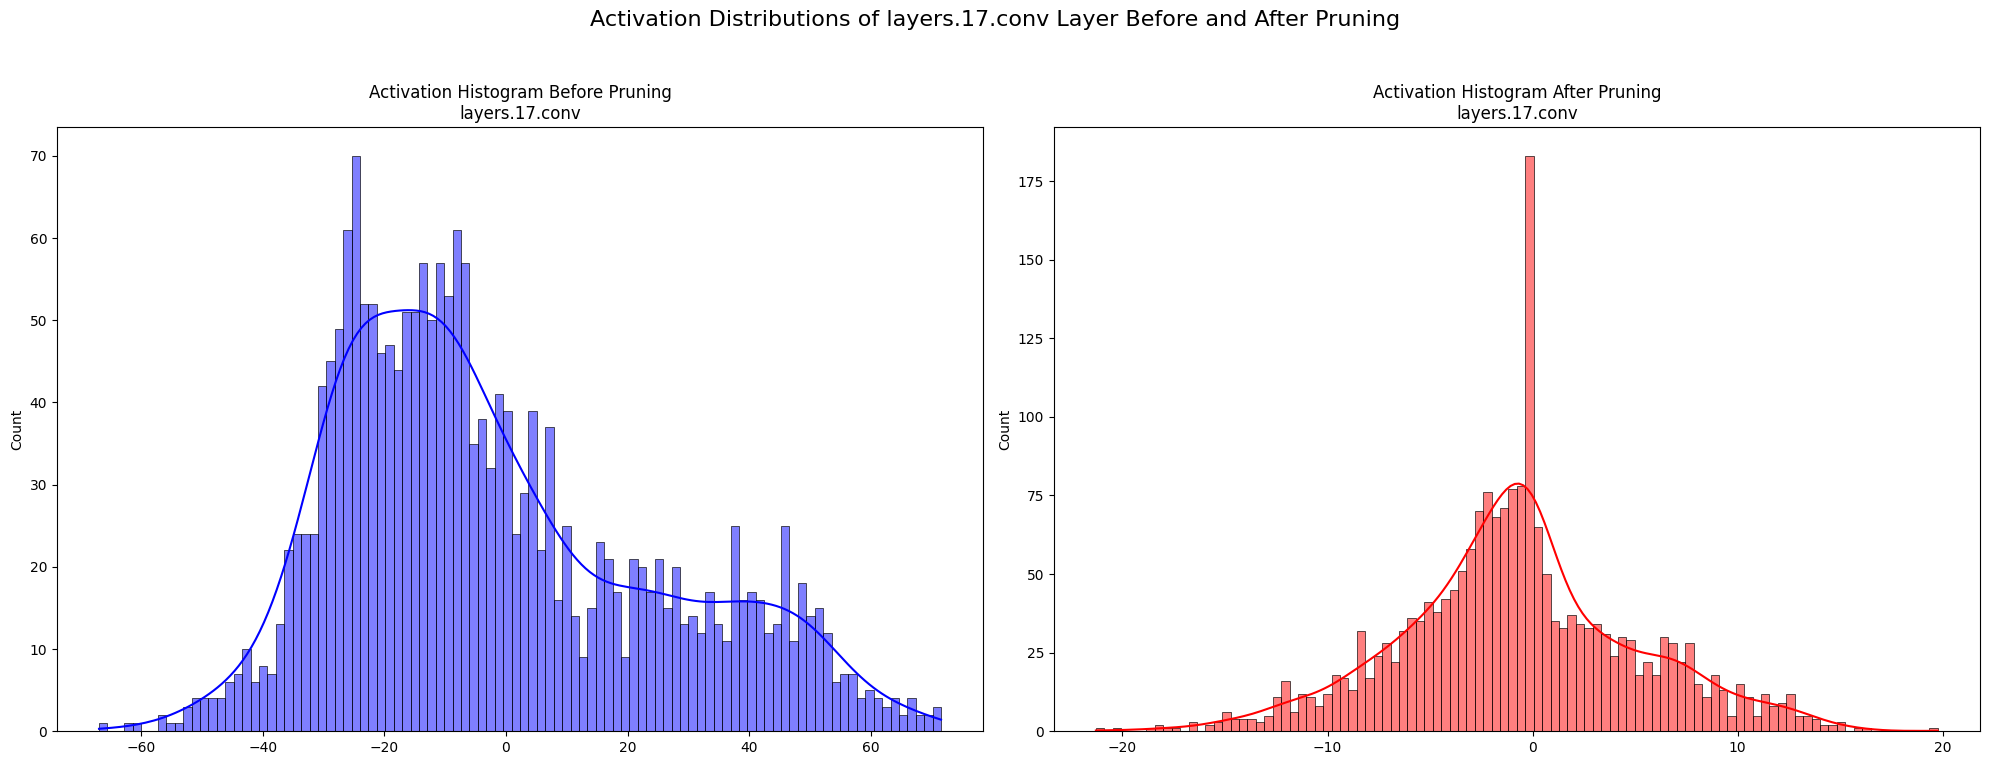

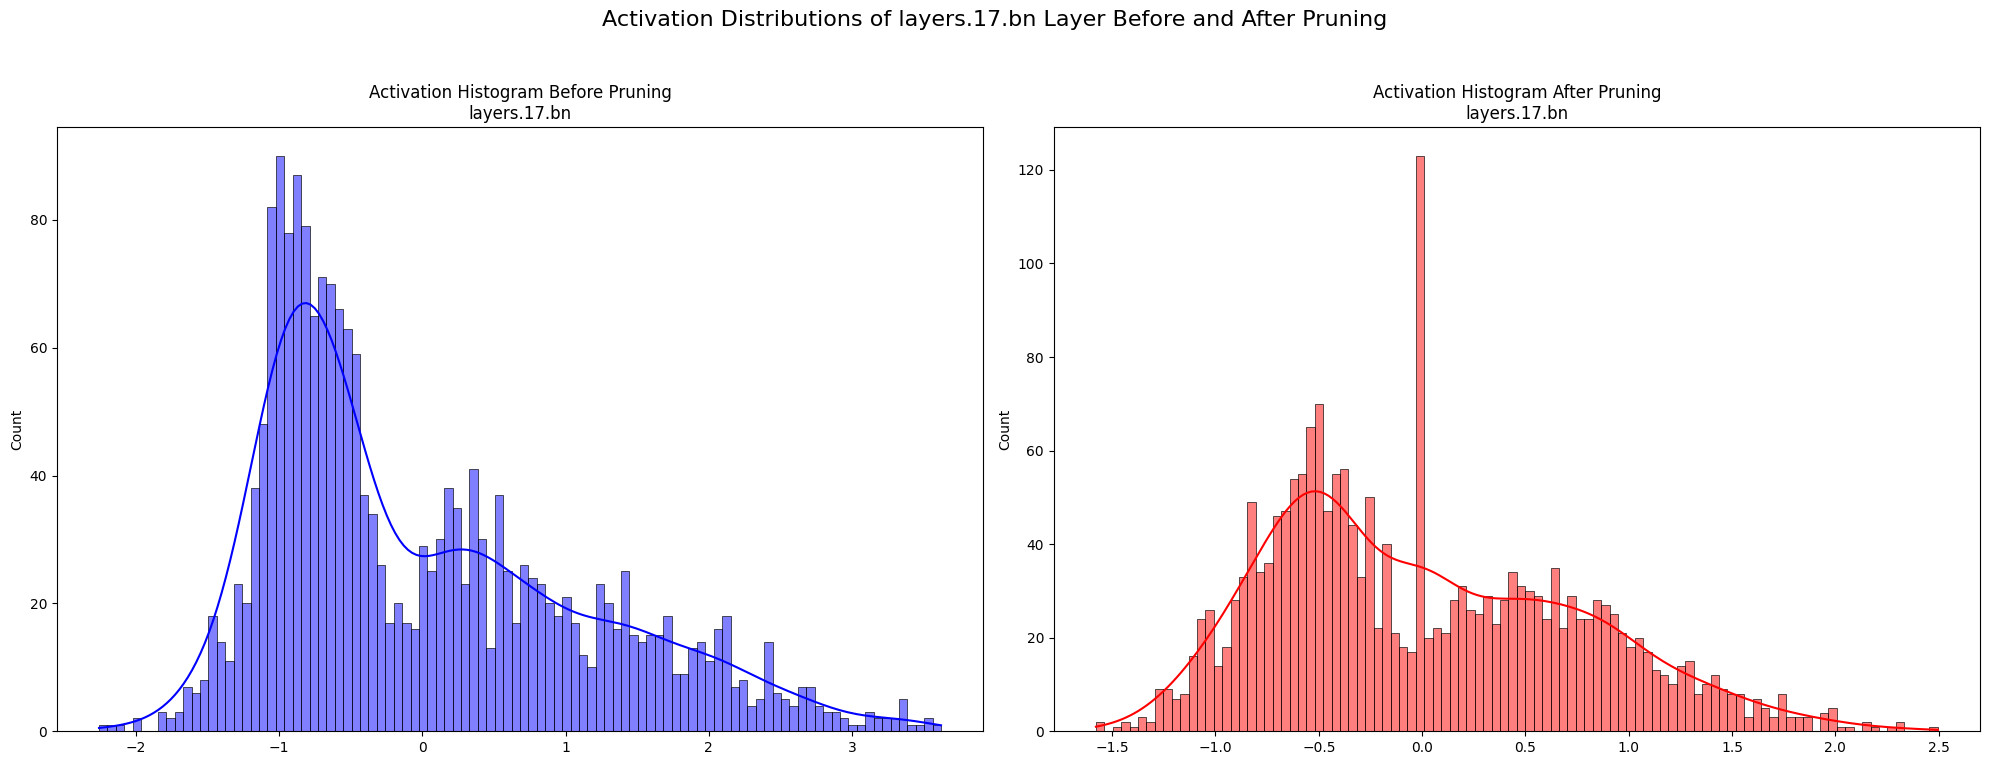

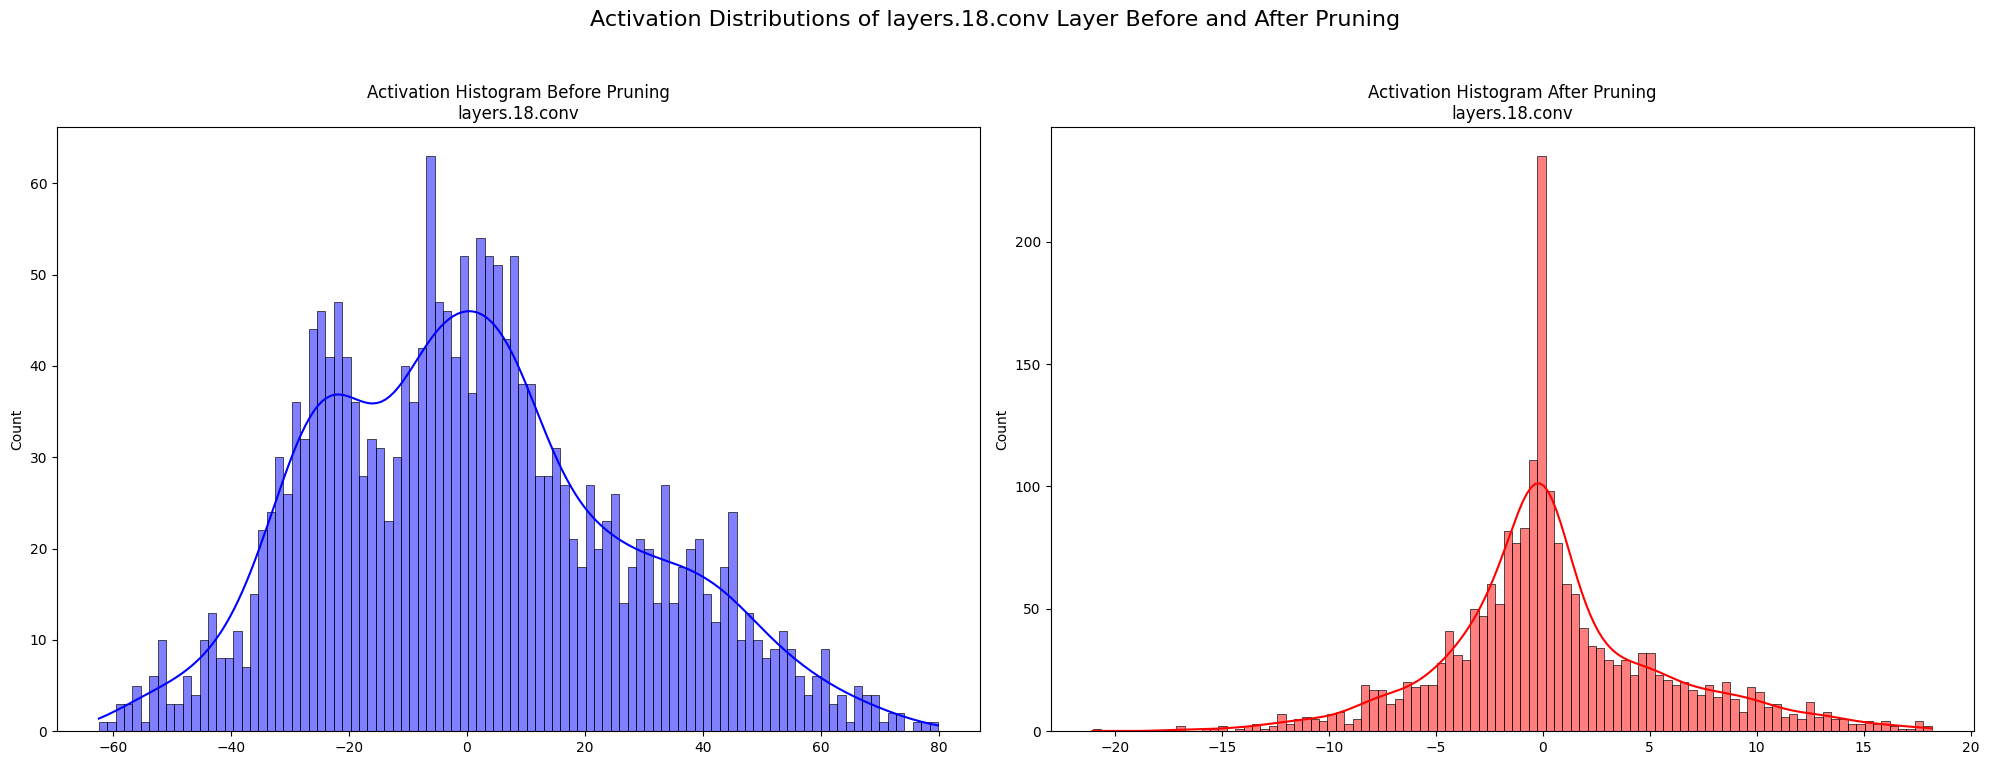

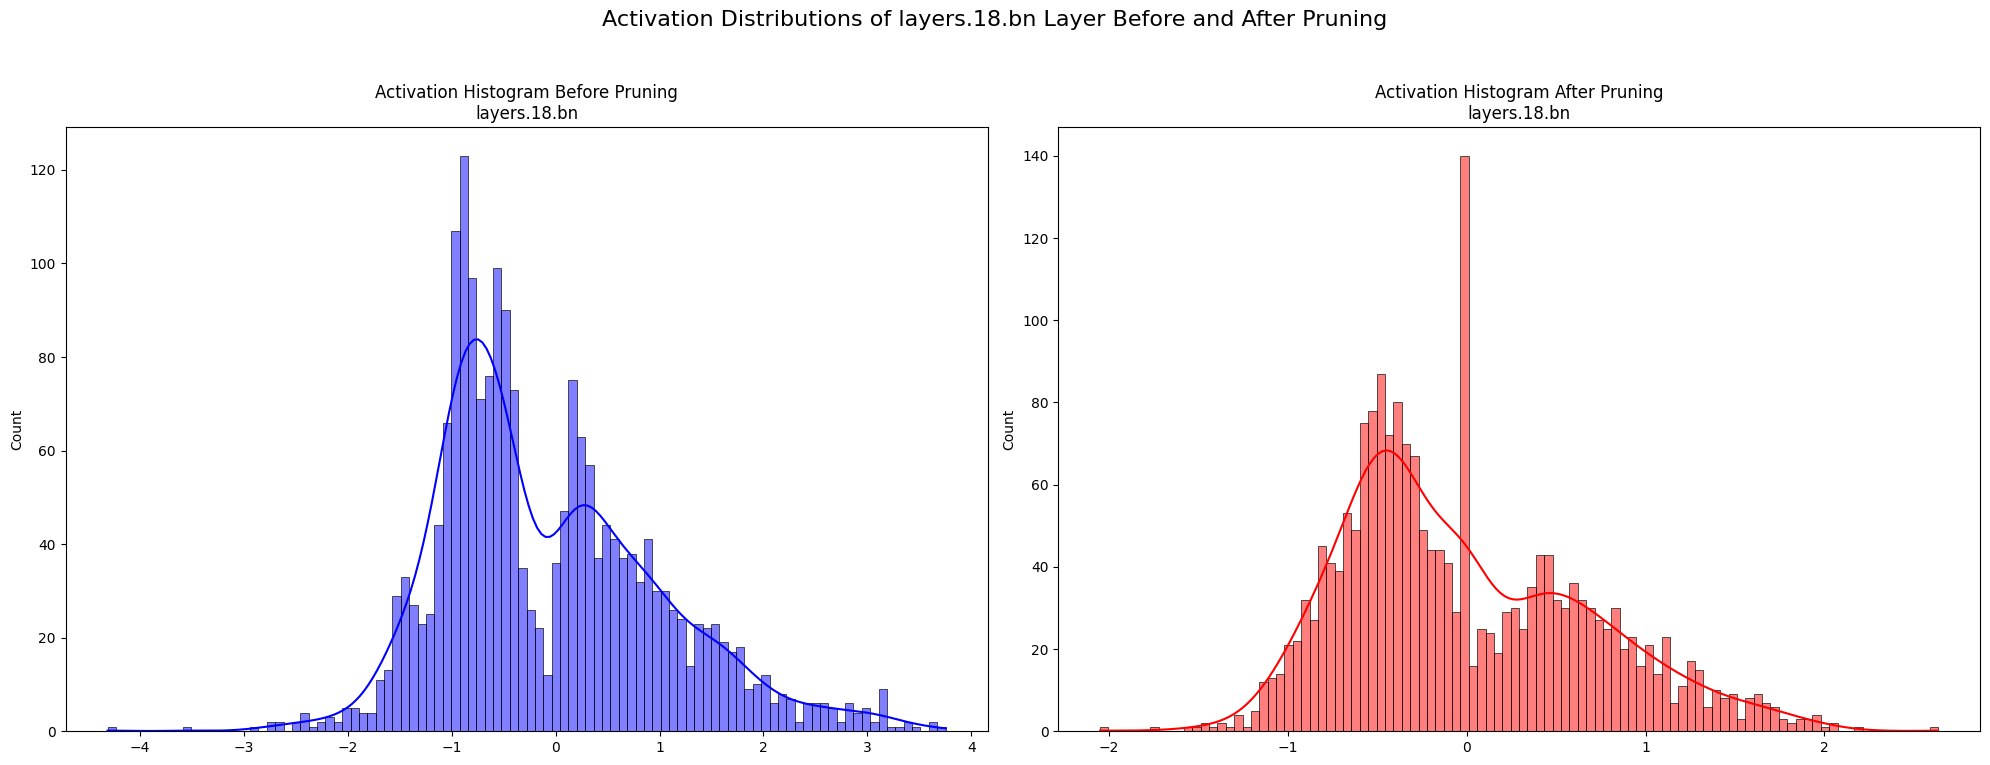

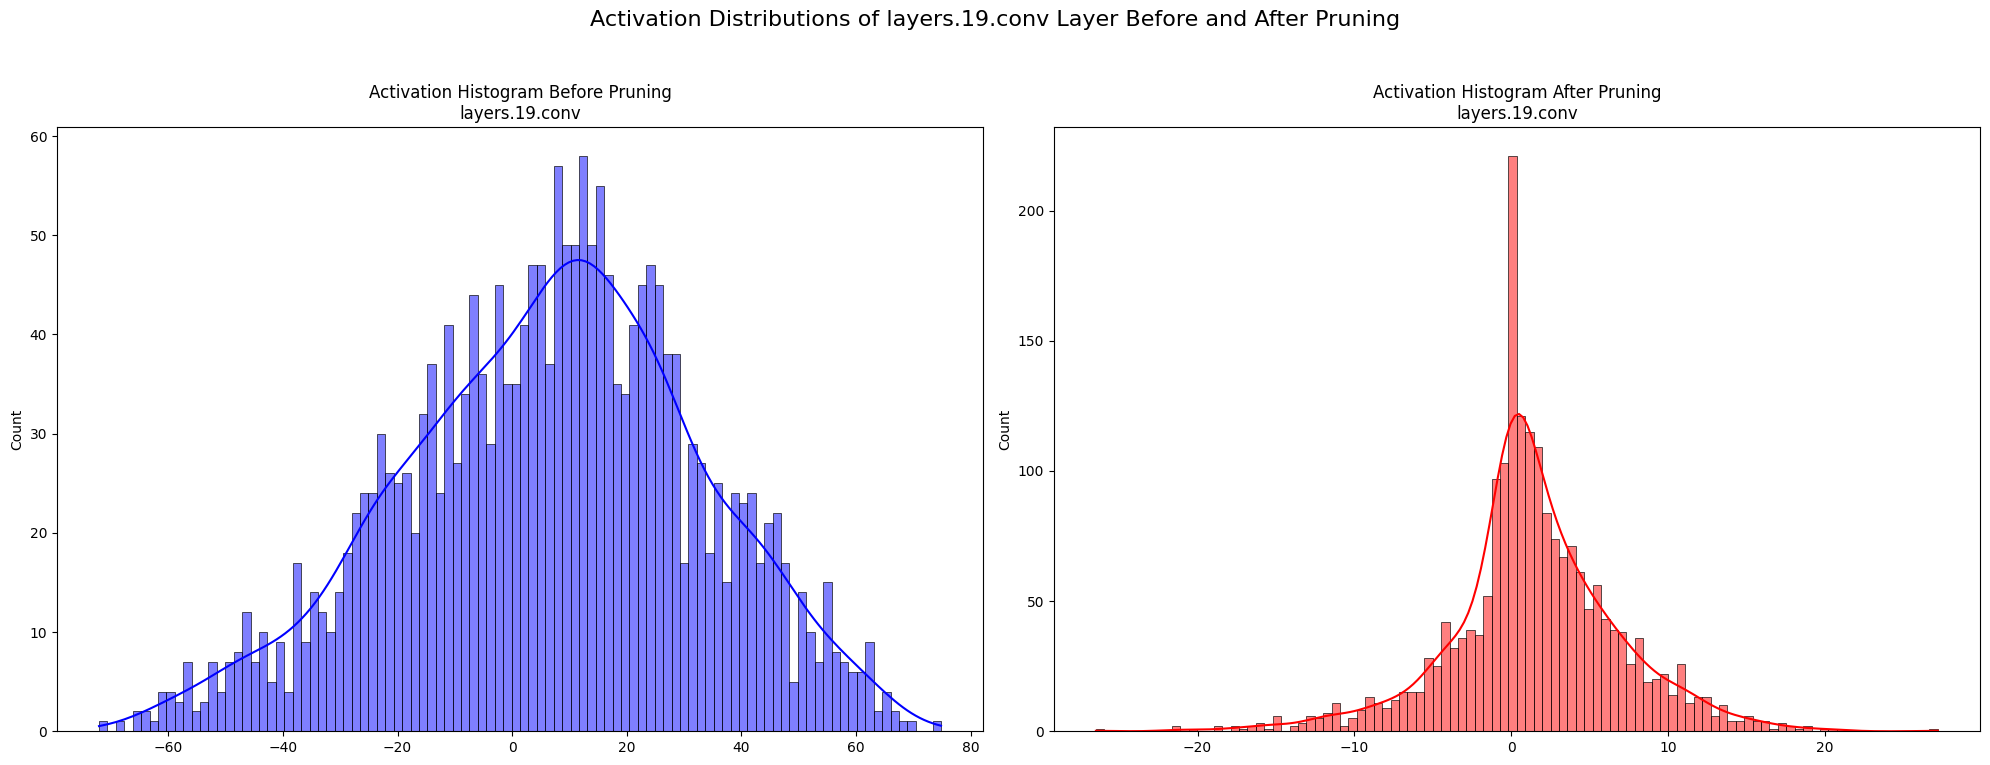

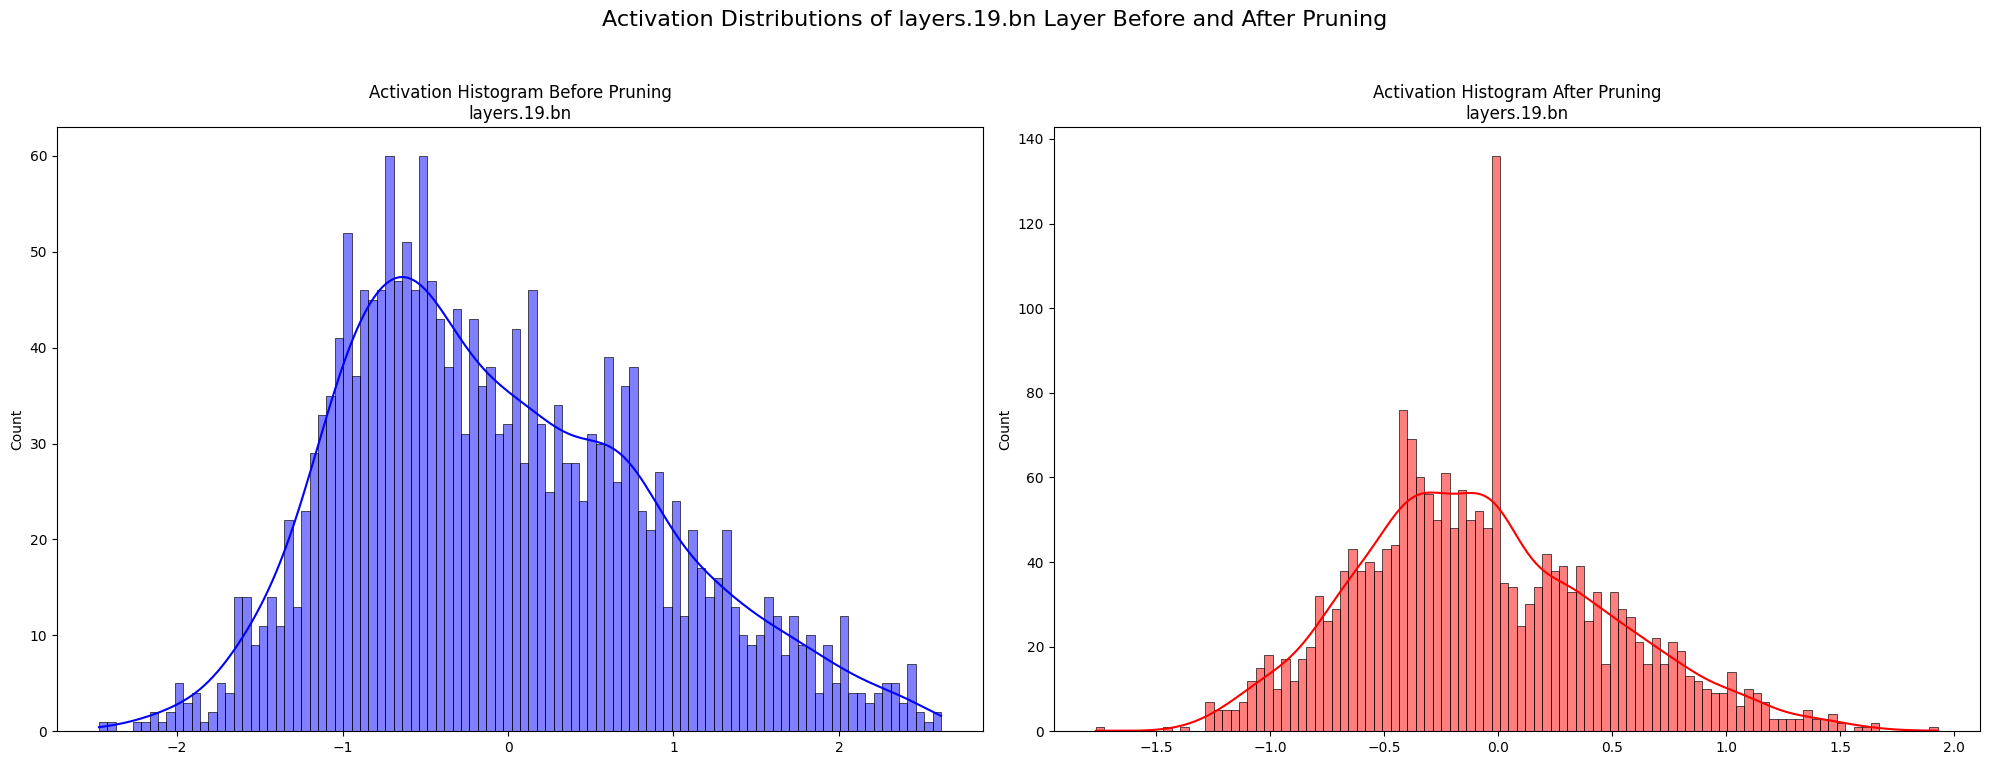

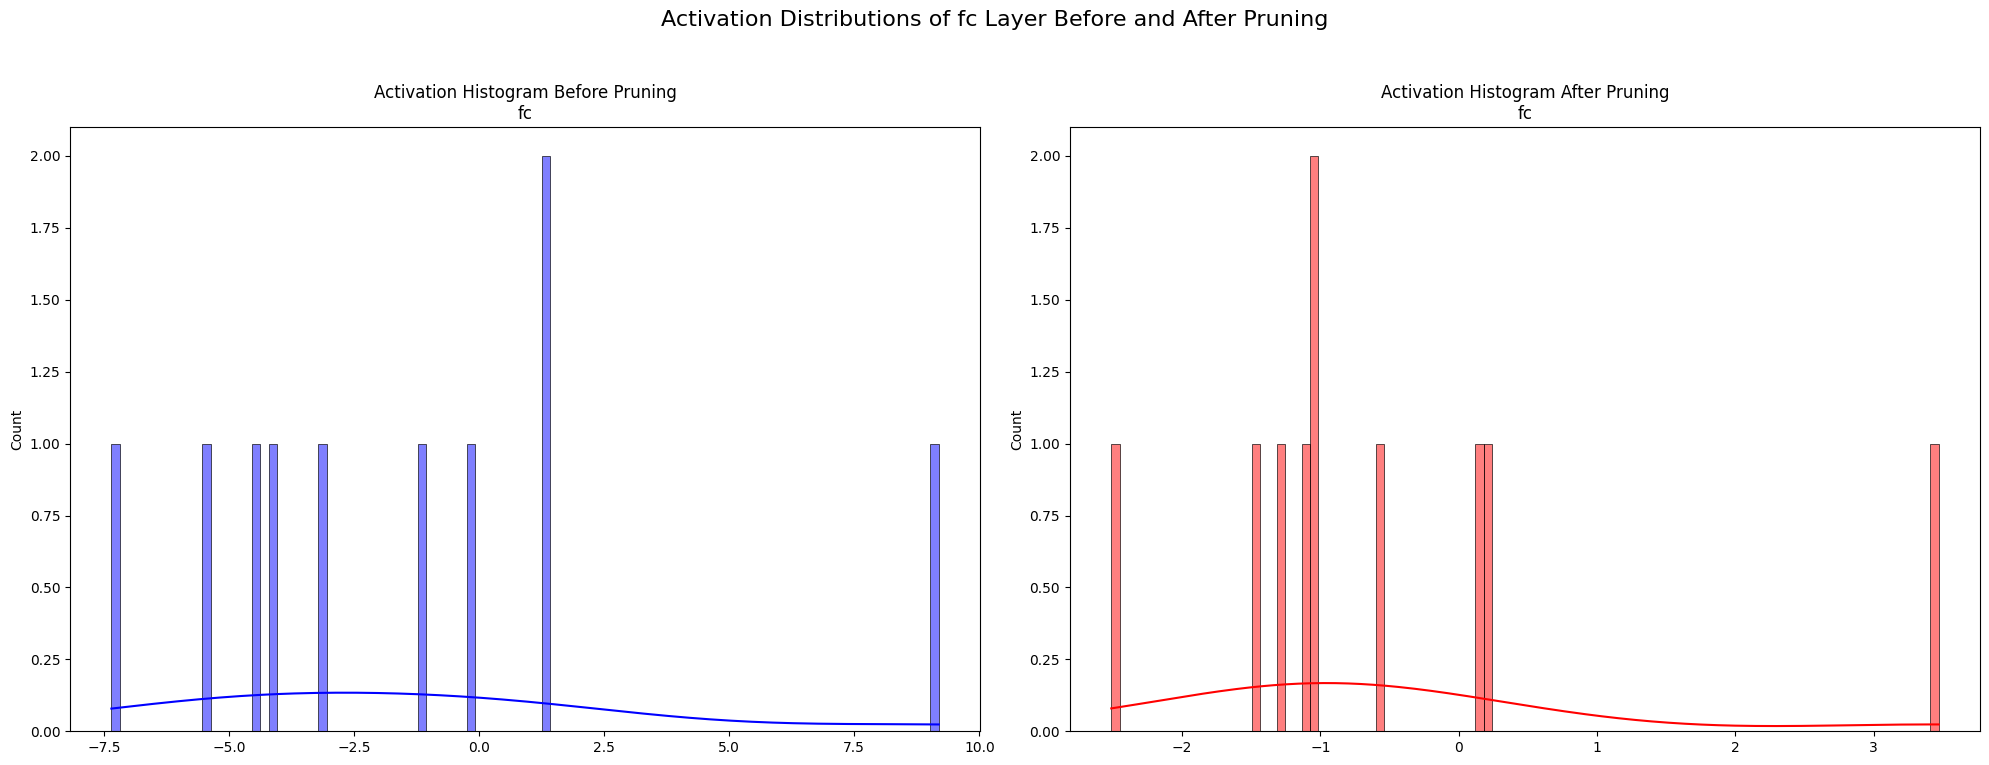

In [207]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a function to extract feature maps from a specified layer
def get_feature_maps(model, input_tensor, target_layer_name):
    feature_maps = {}
    
    def hook_fn(module, input, output):
        feature_maps[target_layer_name] = output.cpu().detach().numpy()
    
    hooks = []
    for name, module in model.named_modules():
        if name == target_layer_name:
            hooks.append(module.register_forward_hook(hook_fn))
    
    model(input_tensor.to(device))
    
    for hook in hooks:
        hook.remove()
    
    return feature_maps

# Define a function to plot histograms of feature maps before and after pruning
def plot_feature_maps_histogram(before_feature_maps, after_feature_maps, layer_name):
    before_maps = before_feature_maps[layer_name].flatten()
    after_maps = after_feature_maps[layer_name].flatten()
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 2, 1)
    sns.histplot(before_maps, bins=100, kde=True, color='blue')
    plt.title(f'Activation Histogram Before Pruning\n{layer_name}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(after_maps, bins=100, kde=True, color='red')
    plt.title(f'Activation Histogram After Pruning\n{layer_name}')
    
    plt.suptitle(f'Activation Distributions of {layer_name} Layer Before and After Pruning', size=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Instantiate the original and pruned models (for demonstration purposes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_model = original_model.to(device)
pruned_model = pruned_model.to(device)

# Generate a dummy input tensor
input_tensor = torch.randn(1, 3, 32, 32)

# Iterate through all the layers in the model and plot the histograms
for name, module in original_model.named_modules():
    # Skip non-leaf modules
    if len(list(module.children())) > 0:
        continue
    
    # Extract feature maps before and after pruning
    before_feature_maps = get_feature_maps(original_model, input_tensor, name)
    after_feature_maps = get_feature_maps(pruned_model, input_tensor, name)
    
    # Plot histograms for the current layer
    plot_feature_maps_histogram(before_feature_maps, after_feature_maps, layer_name=name)
